In [1]:
# read data
import pickle
import pandas as pd
import numpy as np
import networkx as nx

数据输入

In [2]:

# read pkl
with open('./data/scgpt_emb.pkl', 'rb') as f:
    scgpt_emb = pickle.load(f)

with open('./data/geneformer_gene_embs.pkl', 'rb') as f:
    geneformer_emb = pickle.load(f)


with open('./data/GenePT_gene_embedding_ada_text.pickle', 'rb') as f:
    genePT_emb = pickle.load(f)

with open('./data/gene_embeddings.pkl', 'rb') as f:
    gene_emb = pickle.load(f)

with open('./data/cell_embeddings_genePT-w.pkl', 'rb') as f:
    cell_emb = pickle.load(f)

# read protein_info.csv
protein_info = pd.read_csv('./data/protein_info.csv')

# read scgpt_gene2idx.txt
scgpt_gene2idx = pd.read_csv('./data/scgpt_gene2idx.txt', sep='\t', header=None)

# read ppi.csv
ppi = pd.read_csv('./data/ppi.csv')

# read gene_summary.csv
gene_info = pd.read_csv('./data/gene_summary.csv')

# read gene_expression.csv
gene_expression = pd.read_csv('./data/gene_expression.csv', index_col=0)

# read SLKB_rawSL.csv
sl_raw = pd.read_csv('./data/SLKB_rawSL.csv')


分析嵌入用的代码

In [3]:
# scgpt_emb类型输出
print(f'scgpt_emb type: {type(scgpt_emb)}')
# scgpt_emb长度输出
print(f'scgpt_emb length: {len(scgpt_emb)}')
# scgpt_emb元素长度输出
print(f'scgpt_emb[0] length: {len(next(iter(scgpt_emb.values())))}')
# scgpt_emb第一个元素输出
# print(f'scgpt_emb[0]: {next(iter(scgpt_emb.values()))}')

# geneformer_emb类型输出
print(f'geneformer_emb type: {type(geneformer_emb)}')
# geneformer_emb长度输出
print(f'geneformer_emb length: {len(geneformer_emb)}')
# geneformer_emb元素长度输出（这里默认选择其中一个实例进行输出）
# instance = next(iter(geneformer_emb.items()))
# print(f'geneformer_emb element length: {len(instance[1])}')  # instance[1]是真实embedding
# print(f'geneformer_emb example: {instance}')

# protein_info类型输出
print(f'protein_info type: {type(protein_info)}')
# protein_info长度输出
print(f'protein_info length: {len(protein_info)}')
# protein_info包含文件头
print(f'protein_info columns: {protein_info.columns}')
# protein_info示例输出
# print(f'protein_info example: {protein_info.head()}')

# ppi类型输出
print(f'ppi type: {type(ppi)}')
# ppi长度输出
print(f'ppi length: {len(ppi)}')
print("ppi is a adjacency List")
# ppi示例输出
# print(f'ppi example: {ppi.head()}')

# sl_raw类型输出
print(f'sl_raw type: {type(sl_raw)}')
# sl_raw长度输出
print(f'sl_raw length: {len(sl_raw)}')
# sl_raw包含文件头
print(f'sl_raw columns: {sl_raw.columns}')
# sl_raw示例输出
# print(f'sl_raw example: {sl_raw.head()}')

# gene_emb类型输出
print(f'gene_emb type: {type(gene_emb)}')
# gene_emb长度输出
print(f'gene_emb length: {len(gene_emb)}')
# gene_emb示例输出
# print(f'gene_emb example: {next(iter(gene_emb.items()))}')

# genePT_emb类型输出
print(f'genePT_emb type: {type(genePT_emb)}')
# genePT_emb长度输出
print(f'genePT_emb length: {len(genePT_emb)}')
# genePT_emb示例输出
# print(f'genePT_emb example: {next(iter(genePT_emb.items()))}')

# cell_emb类型输出
print(f'cell_emb type: {type(cell_emb)}')
# cell_emb长度输出
print(f'cell_emb length: {len(cell_emb)}')
# cell_emb示例输出
# print(f'cell_emb example: {next(iter(cell_emb.items()))}')

scgpt_emb type: <class 'dict'>
scgpt_emb length: 60697
scgpt_emb[0] length: 512
geneformer_emb type: <class 'dict'>
geneformer_emb length: 12550
protein_info type: <class 'pandas.core.frame.DataFrame'>
protein_info length: 9820
protein_info columns: Index(['Uniprot_entry_id', 'NCBI_gene_id', 'Protein names', 'Gene names',
       'Sequence'],
      dtype='object')
ppi type: <class 'pandas.core.frame.DataFrame'>
ppi length: 501299
ppi is a adjacency List
sl_raw type: <class 'pandas.core.frame.DataFrame'>
sl_raw length: 280483
sl_raw columns: Index(['Unnamed: 0', 'gene_pair', 'study_origin', 'cell_line_origin', 'gene_1',
       'gene_2', 'SL_or_not', 'SL_score', 'statistical_score',
       'SL_score_cutoff', 'statistical_score_cutoff'],
      dtype='object')
gene_emb type: <class 'dict'>
gene_emb length: 6096
genePT_emb type: <class 'dict'>
genePT_emb length: 93800
cell_emb type: <class 'dict'>
cell_emb length: 22


In [4]:
# 将 scgpt_gene2idx 的 '0' 列基因名称对应到 protein_info 的 Gene names 列
# 创建一个字典，将 scgpt_gene2idx 中的基因名映射到其索引
gene2idx_dict = dict(zip(scgpt_gene2idx[0], scgpt_gene2idx[1].astype(int)))
gene2name_dict = dict(zip(scgpt_gene2idx[1].astype(int), scgpt_gene2idx[0]))

# 提取 protein_info 中的基因名
# Gene names 列可能包含多个基因名，以空格分隔，我们需要处理这种情况
gene_names = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
protein_info['symbol'] = protein_info['Gene names'].str.split().apply(lambda x: x[0] if isinstance(x, list) and x else x)
# 将 protein_info 中的基因名映射到 scgpt_gene2idx 中的索引
mapped_ids = gene_names.map(gene2idx_dict)

# 添加映射成功的基因名和ID
protein_info['scGPT_id'] = mapped_ids.astype('Int64')  # 使用Int64类型支持NaN值
protein_info['scGPT_name'] = protein_info['scGPT_id'].map(gene2name_dict)

# 构建模型分类头,预测合成致死
# 将NCBI_gene_id映射到scGPT_id
# 创建映射字典
protein_info['NCBI_gene_id'] = protein_info['NCBI_gene_id'].astype(str)
ncbi_to_scgpt = dict(zip(protein_info['NCBI_gene_id'], protein_info['scGPT_id']))
ncbi_to_symbol = dict(zip(protein_info['NCBI_gene_id'], protein_info['symbol']))
symbol_to_scgpt = dict(zip(protein_info["symbol"], protein_info["scGPT_id"]))
symbol_to_ncbi = dict(zip(protein_info["symbol"], protein_info["NCBI_gene_id"]))

# 获取embedding维度
scgpt_dim = len(next(iter(scgpt_emb.values())))
gf_dim = len(next(iter(geneformer_emb.values())))

# 读取genePT_emb和gene_emb的嵌入维度
ge_dim = len(next(iter(gene_emb.values()))) if gene_emb else 0
gp_emb_dim = len(next(iter(genePT_emb.values()))) if genePT_emb else 0
cell_emb_dim = len(next(iter(cell_emb.values()))) if cell_emb else 0

# 将sl_train中的基因ID映射到scGPT_id
sl_raw = sl_raw.rename(columns={'gene_1': 'geneA_ID', 'gene_2': 'geneB_ID'})
sl_raw['SL_or_not'] = sl_raw['SL_or_not'].apply(lambda x: 1 if x == 'SL' else 0)
sl_raw = sl_raw.rename(columns={'SL_or_not': 'label'})
sl_raw['geneA_scGPT_id'] = sl_raw['geneA_ID'].map(symbol_to_scgpt)
sl_raw['geneB_scGPT_id'] = sl_raw['geneB_ID'].map(symbol_to_scgpt)
sl_raw['geneA_ncbi'] = sl_raw['geneA_ID'].map(symbol_to_ncbi)
sl_raw['geneB_ncbi'] = sl_raw['geneB_ID'].map(symbol_to_ncbi)


# 保留所有数据
sl_filtered = sl_raw.copy()


# 1. 基因名称映射统计
print("=== 基因名称映射统计 ===")
mapped_count = protein_info['scGPT_id'].notna().sum()
total_genes = len(protein_info)
print(f"成功映射的基因数量: {mapped_count}")
print(f"映射缺失的基因数量: {total_genes - mapped_count}")
print(f"总基因数量: {total_genes}")
print(f"映射成功率: {mapped_count / total_genes:.2%}\n")

# 2. 嵌入向量维度信息
print("=== 嵌入向量维度 ===")
print(f"scGPT嵌入向量维度: {scgpt_dim}")
print(f"geneformer嵌入向量维度: {gf_dim}")
print(f"gene嵌入向量维度: {ge_dim}")
print(f"genePT嵌入向量维度: {gp_emb_dim}")
print(f"cell line嵌入向量维度: {cell_emb_dim}\n")

# 3. 合成致死数据映射统计
print("=== 合成致死数据映射统计 ===")
total_pairs = len(sl_filtered)
print(f"总数据量: {total_pairs}")

geneA_ncbi_missing = sl_filtered['geneA_ncbi'].isna().sum()
print(f"geneA_ncbi - 成功映射: {total_pairs - geneA_ncbi_missing}")
print(f"geneA_ncbi - 映射缺失: {geneA_ncbi_missing}")

geneB_ncbi_missing = sl_filtered['geneB_ncbi'].isna().sum()
print(f"geneB_ncbi - 成功映射: {total_pairs - geneB_ncbi_missing}")
print(f"geneB_ncbi - 映射缺失: {geneB_ncbi_missing}")

geneA_scGPT_missing = sl_filtered['geneA_scGPT_id'].isna().sum()
print(f"geneA_scGPT_id - 成功映射: {total_pairs - geneA_scGPT_missing}")
print(f"geneA_scGPT_id - 映射缺失: {geneA_scGPT_missing}")

geneB_scGPT_missing = sl_filtered['geneB_scGPT_id'].isna().sum()
print(f"geneB_scGPT_id - 成功映射: {total_pairs - geneB_scGPT_missing}")
print(f"geneB_scGPT_id - 映射缺失: {geneB_scGPT_missing}")

=== 基因名称映射统计 ===
成功映射的基因数量: 9722
映射缺失的基因数量: 98
总基因数量: 9820
映射成功率: 99.00%

=== 嵌入向量维度 ===
scGPT嵌入向量维度: 512
geneformer嵌入向量维度: 256
gene嵌入向量维度: 768
genePT嵌入向量维度: 1536
cell line嵌入向量维度: 768

=== 合成致死数据映射统计 ===
总数据量: 280483
geneA_ncbi - 成功映射: 238328
geneA_ncbi - 映射缺失: 42155
geneB_ncbi - 成功映射: 238759
geneB_ncbi - 映射缺失: 41724
geneA_scGPT_id - 成功映射: 238328
geneA_scGPT_id - 映射缺失: 42155
geneB_scGPT_id - 成功映射: 238748
geneB_scGPT_id - 映射缺失: 41735


In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [6]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 输出设备信息
print(f"使用设备: {device}")

使用设备: cuda


In [7]:
# 构建 PPI 图（基于基因符号）
# 将 PPI 中的 NCBI ID 转为符号
ppi['symA'] = ppi['geneA_ID'].map(ncbi_to_symbol)
ppi['symB'] = ppi['geneB_ID'].map(ncbi_to_symbol)
# 去除映射失败的行
ppi = ppi.dropna(subset=['symA','symB'])
print("过滤后PPI数据量:", len(ppi))
# 构建图
G = nx.from_pandas_edgelist(ppi, source='symA', target='symB', create_using=nx.Graph())

过滤后PPI数据量: 210031


In [8]:
# 生成节点特征
node_list = list(G.nodes())
node_to_idx = {node: i for i, node in enumerate(node_list)}
num_nodes = len(node_list)
edge_index = torch.tensor(
    [[node_to_idx[u] for u, v in G.edges()],
     [node_to_idx[v] for u, v in G.edges()]],
    dtype=torch.long
)

x_features = np.zeros((num_nodes, gf_dim), dtype=np.float32)
for i, node in enumerate(node_list):
    if node in geneformer_emb:
        x_features[i] = geneformer_emb[node]

# 创建PyTorch Geometric数据对象并移动到设备
data = Data(
    x=torch.from_numpy(x_features).to(device),
    edge_index=edge_index.to(device)
)

# 定义GCN模型
class PPIGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        return self.conv2(x, edge_index)

# 初始化模型和优化器，并移动到设备
gnn = PPIGCN(gf_dim, 128, 64).to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)
sigmoid = torch.nn.Sigmoid()

# 无监督训练（示例使用随机游走负采样）
def train_gnn(model, data, epochs=150):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z = model(data)
        
        # 正样本损失（现有边）
        pos_scores = sigmoid((z[data.edge_index[0]] * z[data.edge_index[1]]).sum(dim=1))
        pos_loss = -torch.log(pos_scores + 1e-15).mean()
        
        # 负采样
        neg_edges = torch.randint(0, data.num_nodes, (2, data.edge_index.size(1)), dtype=torch.long, device=device)
        neg_scores = sigmoid((z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1))
        neg_loss = -torch.log(1 - neg_scores + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_gnn(gnn, data, epochs=150)

# 生成最终节点嵌入
gnn.eval()
with torch.no_grad():
    node_embeddings = gnn(data).cpu().numpy()  # 将结果从 GPU 移动到 CPU

# 创建嵌入字典
ppi_embeddings = {node: node_embeddings[i] for i, node in enumerate(node_list)}

Epoch 0, Loss: 1.2003
Epoch 10, Loss: 1.2852
Epoch 20, Loss: 1.1941
Epoch 30, Loss: 1.1404
Epoch 40, Loss: 1.1215
Epoch 50, Loss: 1.1153
Epoch 60, Loss: 1.0887
Epoch 70, Loss: 1.0828
Epoch 80, Loss: 1.0796
Epoch 90, Loss: 1.0590
Epoch 100, Loss: 1.0644
Epoch 110, Loss: 1.0524
Epoch 120, Loss: 1.0424
Epoch 130, Loss: 1.0454
Epoch 140, Loss: 1.0440


In [9]:
# 构建特征向量：将两个基因的embedding拼接
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc as auc_pr, balanced_accuracy_score
import matplotlib.pyplot as plt
import copy

In [10]:
# 加载ESM和BlueBERT嵌入
protein_embeddings = np.load('./esm_bluebert/esm_embeddings.npz')
bluebert_embeddings = np.load('./esm_bluebert/bluebert_embeddings.npz')

gene_ids = protein_embeddings['gene_ids']
embeddings = protein_embeddings['embeddings']
esm_emb = {int(gene_id): embedding for gene_id, embedding in zip(gene_ids, embeddings)}
esm_dim = embeddings.shape[1] if len(embeddings) > 0 else 0

bluebert_gene_ids = bluebert_embeddings['gene_ids']
bluebert_embeddings = bluebert_embeddings['embeddings']
bluebert_emb = {int(gene_id): embedding for gene_id, embedding in zip(bluebert_gene_ids, bluebert_embeddings)}
bluebert_dim = bluebert_embeddings.shape[1] if len(bluebert_embeddings) > 0 else 0

In [11]:
# 验证索引是否正确
print("验证 ESM 嵌入索引...")
for gene_id in gene_ids:
    try:
        int_gene_id = int(gene_id)
        if int_gene_id not in esm_emb:
            print(f"ESM 索引缺失: {gene_id}")
    except ValueError:
        print(f"ESM 索引无效: {gene_id}")

print("验证 BlueBERT 嵌入索引...")
for gene_id in bluebert_gene_ids:
    try:
        int_gene_id = int(gene_id)
        if int_gene_id not in bluebert_emb:
            print(f"BlueBERT 索引缺失: {gene_id}")
    except ValueError:
        print(f"BlueBERT 索引无效: {gene_id}")

print("验证完成！")

验证 ESM 嵌入索引...
验证 BlueBERT 嵌入索引...
验证完成！


In [12]:
from sklearn.decomposition import PCA

# PCA降维函数
def apply_pca(embeddings, original_dim, variance_ratio, name=""):
    """
    对嵌入向量进行PCA降维
    参数:
        embeddings: 要降维的嵌入向量列表
        original_dim: 原始维度
        variance_ratio: 要保留的方差比例
        name: 嵌入名称(用于打印信息)
    返回:
        降维后的嵌入向量和PCA模型
    """
    if variance_ratio >= 1.0:
        return embeddings, None
    
    # 将嵌入向量reshape为2D数组 (n_samples, n_features)
    emb_array = np.array(embeddings).reshape(-1, original_dim)
    
    # 计算保留至少variance_ratio方差所需的最小组件数
    pca = PCA(n_components=variance_ratio, svd_solver='full')
    reduced_emb = pca.fit_transform(emb_array)
    
    # 打印降维信息
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"{name} PCA降维信息:")
    print(f"  原始维度: {original_dim}")
    print(f"  降维后维度: {reduced_emb.shape[1]}")
    print(f"  保留方差比例: {explained_variance:.4f}")
    print(f"  设置保留率: {variance_ratio}")
    
    return reduced_emb, pca

# 获取特征向量，处理缺失的embedding
def get_gene_pair_features(df, is_train=True):
    # 设置每种嵌入的PCA保留方差比例 (可以根据需要调整)
    pca_settings = {
        'scGPT': 0.97,       
        'Geneformer': 0.97,   
        'gene_emb': 0.99,    
        'genePT': 0.97,       
        'PPI': 1.0,          
        'ESM': 0.9995,         
        'BlueBERT': 0.9995    
    }
    
    features = []
    labels = [] if is_train else None
    
    # 用于存储每种嵌入的所有样本
    emb_storage = {
        'scGPT_A': [], 'scGPT_B': [],
        'Geneformer_A': [], 'Geneformer_B': [],
        'gene_emb_A': [], 'gene_emb_B': [],
        'genePT_A': [], 'genePT_B': [],
        'PPI_A': [], 'PPI_B': [],
        'ESM_A': [], 'ESM_B': [],
        'BlueBERT_A': [], 'BlueBERT_B': []
    }
    
    # 首先收集所有嵌入数据
    for _, row in df.iterrows():
        # 原始特征
        a_idx = row['geneA_scGPT_id']
        b_idx = row['geneB_scGPT_id']
        symA = row['geneA_ID']
        symB = row['geneB_ID'] 
        a_ncbi_id = row['geneA_ncbi']
        b_ncbi_id = row['geneB_ncbi']
        # cell_line_name = row['cell_line_origin']
        '''
        检查索引和符号是否有效
        # 打印a_idx和b_idx的类型和内容
        if not pd.isna(a_idx):
            print(f"a_idx: {a_idx}, type: {type(a_idx)}")
        if not pd.isna(b_idx):
            print(f"b_idx: {b_idx}, type: {type(b_idx)}")
        # 打印symA和symB的类型和内容
        print(f"symA: {symA}, type: {type(symA)}")
        '''
        
        # 获取各嵌入向量并存储
        emb_storage['scGPT_A'].append(scgpt_emb.get(int(a_idx), np.zeros(scgpt_dim)) if not pd.isna(a_idx) else np.zeros(scgpt_dim))
        emb_storage['scGPT_B'].append(scgpt_emb.get(int(b_idx), np.zeros(scgpt_dim)) if not pd.isna(b_idx) else np.zeros(scgpt_dim))
        emb_storage['Geneformer_A'].append(geneformer_emb.get(symA, np.zeros(gf_dim)))
        emb_storage['Geneformer_B'].append(geneformer_emb.get(symB, np.zeros(gf_dim)))
        emb_storage['gene_emb_A'].append(gene_emb.get(symA, np.zeros(ge_dim)))
        emb_storage['gene_emb_B'].append(gene_emb.get(symB, np.zeros(ge_dim)))
        emb_storage['genePT_A'].append(genePT_emb.get(symA, np.zeros(gp_emb_dim)))
        emb_storage['genePT_B'].append(genePT_emb.get(symB, np.zeros(gp_emb_dim)))
        emb_storage['PPI_A'].append(ppi_embeddings.get(symA, np.zeros(64)))
        emb_storage['PPI_B'].append(ppi_embeddings.get(symB, np.zeros(64)))
        emb_storage['ESM_A'].append(esm_emb.get(int(a_ncbi_id), np.zeros(esm_dim)) if not pd.isna(a_ncbi_id) else np.zeros(esm_dim))
        emb_storage['ESM_B'].append(esm_emb.get(int(b_ncbi_id), np.zeros(esm_dim)) if not pd.isna(b_ncbi_id) else np.zeros(esm_dim))
        emb_storage['BlueBERT_A'].append(bluebert_emb.get(int(a_ncbi_id), np.zeros(bluebert_dim)) if not pd.isna(a_ncbi_id) else np.zeros(bluebert_dim))
        emb_storage['BlueBERT_B'].append(bluebert_emb.get(int(b_ncbi_id), np.zeros(bluebert_dim)) if not pd.isna(b_ncbi_id) else np.zeros(bluebert_dim))
        
        if is_train:
            labels.append(row['label'])
    
    # 对每种嵌入应用PCA
    reduced_embs = {}
    pca_models = {}
    
    # scGPT
    scA_reduced, pca_models['scGPT'] = apply_pca(emb_storage['scGPT_A'], scgpt_dim, pca_settings['scGPT'], 'scGPT')
    scB_reduced, _ = apply_pca(emb_storage['scGPT_B'], scgpt_dim, pca_settings['scGPT'], 'scGPT')
    
    # Geneformer
    gfA_reduced, pca_models['Geneformer'] = apply_pca(emb_storage['Geneformer_A'], gf_dim, pca_settings['Geneformer'], 'Geneformer')
    gfB_reduced, _ = apply_pca(emb_storage['Geneformer_B'], gf_dim, pca_settings['Geneformer'], 'Geneformer')
    
    # gene_emb
    geA_reduced, pca_models['gene_emb'] = apply_pca(emb_storage['gene_emb_A'], ge_dim, pca_settings['gene_emb'], 'gene_emb')
    geB_reduced, _ = apply_pca(emb_storage['gene_emb_B'], ge_dim, pca_settings['gene_emb'], 'gene_emb')
    
    # genePT
    gpA_reduced, pca_models['genePT'] = apply_pca(emb_storage['genePT_A'], gp_emb_dim, pca_settings['genePT'], 'genePT')
    gpB_reduced, _ = apply_pca(emb_storage['genePT_B'], gp_emb_dim, pca_settings['genePT'], 'genePT')
    
    # PPI (不降维)
    ppiA_reduced = np.array(emb_storage['PPI_A'])
    ppiB_reduced = np.array(emb_storage['PPI_B'])
    
    # ESM
    esmA_reduced, pca_models['ESM'] = apply_pca(emb_storage['ESM_A'], esm_dim, pca_settings['ESM'], 'ESM')
    esmB_reduced, _ = apply_pca(emb_storage['ESM_B'], esm_dim, pca_settings['ESM'], 'ESM')
    
    # BlueBERT
    bluebertA_reduced, pca_models['BlueBERT'] = apply_pca(emb_storage['BlueBERT_A'], bluebert_dim, pca_settings['BlueBERT'], 'BlueBERT')
    bluebertB_reduced, _ = apply_pca(emb_storage['BlueBERT_B'], bluebert_dim, pca_settings['BlueBERT'], 'BlueBERT')
    
    # 拼接所有特征
    features = []
    for i in range(len(df)):
        pair_feature = np.concatenate([
            scA_reduced[i], scB_reduced[i],      # scGPT
            gfA_reduced[i], gfB_reduced[i],      # Geneformer
            geA_reduced[i], geB_reduced[i],      # gene_emb
            gpA_reduced[i], gpB_reduced[i],      # genePT emb
            ppiA_reduced[i], ppiB_reduced[i],    # PPI嵌入
            esmA_reduced[i], esmB_reduced[i],    # ESM嵌入
            bluebertA_reduced[i], bluebertB_reduced[i]  # BlueBERT嵌入
        ])
        features.append(pair_feature)
    
    # 打印总维度信息
    original_total_dim = 2*(scgpt_dim + gf_dim + ge_dim + gp_emb_dim + 64 + esm_dim + bluebert_dim)
    reduced_total_dim = (scA_reduced.shape[1] + gfA_reduced.shape[1] + geA_reduced.shape[1] + 
                         gpA_reduced.shape[1] + 64 + esmA_reduced.shape[1] + bluebertA_reduced.shape[1]) * 2
    print("\n总维度信息:")
    print(f"  原始总维度: {original_total_dim}")
    print(f"  降维后总维度: {reduced_total_dim}")
    print(f"  维度压缩率: {reduced_total_dim/original_total_dim:.2%}")
    
    return (np.array(features), np.array(labels)) if is_train else np.array(features)

In [13]:
class SLClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.7),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.LeakyReLU(0.1), nn.Dropout(0.5),
        )
        self.attention = nn.Sequential(
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Softmax(dim=1)
        )
        self.sigmoid = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x): 
        x = self.net(x)
        att_weights = self.attention(x)
        x = att_weights * x
        return self.sigmoid(x).squeeze()

# 获取特征和标签
#features, labels = get_gene_pair_features(sl_filtered)

# 获取所有细胞系并划分
#all_cell_lines = sl_raw['cell_line_origin'].unique()


# 训练函数
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for inputs, labels in data_loader:
        # 将数据移动到CUDA设备
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # 记录损失和预测
        total_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float().detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    # 计算指标
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return total_loss / len(data_loader.dataset), acc, precision, recall, f1

# 验证函数
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            # 将数据移动到CUDA设备
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    bacc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    try:
        auc_score = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_score = 0.5
    
    metrics = {'loss': total_loss / len(data_loader.dataset), 'acc' : acc, 'bacc': bacc, 
               'precision': precision, 'recall' : recall,'f1': f1, 'auc': auc_score}
    
    return metrics, all_labels, all_probs

def balance_dataset(df, max_neg_ratio=3.0, min_pos_samples=5):

    pos_samples = df[df['label'] == 1]
    neg_samples = df[df['label'] == 0]
    
    n_pos = len(pos_samples)
    n_neg = len(neg_samples)
    
    # 确保最小正样本量
    if n_pos < min_pos_samples:
        return df  
    
    # 计算允许的最大负样本量
    max_allowed_neg = min(n_neg, int(n_pos * max_neg_ratio))
    
    # 随机采样负样本
    neg_sampled = neg_samples.sample(n=max_allowed_neg, random_state=42)

    # 如果 concatenation 后发现只有一类，也直接返回原 df
    if len(np.unique(pd.concat([pos_samples, neg_sampled])['label'])) < 2:
        return df
    
    return pd.concat([pos_samples, neg_sampled])

# 绘制训练曲线
def plot_training_curves(history, cell_line, fold_num):
    # 中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(12, 4))

    # 损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.title(f'{cell_line} 第{fold_num}折损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.title(f'{cell_line} 第{fold_num}折准确率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # F1和AUC曲线
    plt.subplot(1, 3, 3)
    plt.plot(history['train_f1'], label='训练F1')
    plt.plot(history['val_f1'], label='验证F1')
    plt.plot(history['val_auc'], label='验证AUC')
    plt.title(f'{cell_line} 第{fold_num}折F1/AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [14]:
from torch.optim.lr_scheduler import CosineAnnealingLR

class ImprovedAutoEncoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        # 编码器：渐进式降维
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 384),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3),  # 降低Dropout率
            
            # nn.Linear(384, 384),
            # nn.BatchNorm1d(384),  # 添加中间层BN
            # nn.LeakyReLU(negative_slope=0.1),
            # nn.Dropout(0.3),
            
            nn.Linear(384, bottleneck_dim),
            # nn.BatchNorm1d(bottleneck_dim),  # 启用瓶颈层BN
            # nn.Tanh()  # 约束输出范围
        )
        
        # 解码器：对称结构
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 384),
            # nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3),
            
            # nn.Linear(384, 384),
            # nn.BatchNorm1d(384),
            # nn.LeakyReLU(negative_slope=0.1),
            # nn.Dropout(0.3),
            
            nn.Linear(384, input_dim)
        )
    
    def forward(self, x):
        bottleneck = self.encoder(x)
        reconstructed = self.decoder(bottleneck)
        return bottleneck, reconstructed

# 训练优化
def train_autoencoder(autoencoder, X_train, X_val, device, epochs=500, batch_size=512):
    # 将训练和验证数据转换为TensorDataset
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val))
    
    # 使用DataLoader分batch加载数据
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 使用MSE损失
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(autoencoder.parameters(), 
                                  lr=1e-3 , weight_decay=0)
    
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        autoencoder.train()
        epoch_loss = 0.0
        
        # 动态方差惩罚系数：从0线性增加到0.0001
        var_coeff = min(0.00007, 0.00007 * (epoch / 20))
        
        # 分batch训练
        for batch in train_loader:
            train_tensor = batch[0].to(device)
            
            # 前向传播
            bottleneck, reconstructed = autoencoder(train_tensor)
            
            # 损失计算
            recon_loss = criterion(reconstructed, train_tensor)
            var_loss = var_coeff * torch.mean(torch.var(bottleneck, dim=0))
            total_loss = recon_loss + var_loss
            
            # 反向传播优化
            optimizer.zero_grad()
            total_loss.backward()
            
            # 梯度裁剪（在optimizer.step之前）
            torch.nn.utils.clip_grad_norm_(
                autoencoder.parameters(), 
                max_norm=1.0,
                norm_type=2.0  # L2范数裁剪
            )
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        scheduler.step()
        
        # 验证集评估
        autoencoder.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_loader:
                val_tensor = val_batch[0].to(device)
                val_bottleneck, val_reconstructed = autoencoder(val_tensor)
                val_loss += criterion(val_reconstructed, val_tensor).item()
        
        val_loss /= len(val_loader)  # 计算平均验证损失
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
        
        # 打印训练信息
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_loss / len(train_loader):.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"LR: {scheduler.get_last_lr()[0]:.2e}")
    
    # 加载最佳模型
    autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))
    return autoencoder

In [15]:
def check_variance_preservation(original_data, encoded_data):
    """计算原始数据和编码数据的方差保留率"""
    # 原始数据总方差
    original_var = np.var(original_data, axis=0).sum()
    
    # 编码数据总方差
    encoded_var = np.var(encoded_data, axis=0).sum()
    
    # 保留率
    variance_ratio = encoded_var / original_var
    
    # PCA基准对比（保留相同维度）
    n_components = min(encoded_data.shape[1], original_data.shape[0], original_data.shape[1])
    pca = PCA(n_components=n_components)
    pca.fit(original_data)
    pca_var = np.var(pca.transform(original_data), axis=0).sum()
    
    print(f"原始数据总方差: {original_var:.2f}")
    print(f"编码数据总方差: {encoded_var:.2f} (保留率: {variance_ratio:.1%})")
    print(f"PCA同维度保留方差: {pca_var:.2f} (基准比例: {pca_var/original_var:.1%})")
    
    return variance_ratio

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_feature_space(original_data, encoded_data, labels=None):
    """对比原始数据和编码数据的特征分布"""
    plt.figure(figsize=(12, 5))
    
    # 原始数据可视化（降维到2D）
    plt.subplot(1, 2, 1)
    if original_data.shape[1] > 2:
        original_2d = TSNE(n_components=2).fit_transform(original_data)
    else:
        original_2d = original_data
    plt.scatter(original_2d[:, 0], original_2d[:, 1], c=labels, alpha=0.6)
    plt.title("Original Data Space")
    
    # 编码数据可视化
    plt.subplot(1, 2, 2)
    if encoded_data.shape[1] > 2:
        encoded_2d = TSNE(n_components=2).fit_transform(encoded_data)
    else:
        encoded_2d = encoded_data
    plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, alpha=0.6)
    plt.title("Encoded Feature Space")
    
    plt.tight_layout()
    plt.show()

In [17]:
class WeightedBCELoss(nn.Module):
    def __init__(self, neg_weight=1.0):
        super().__init__()
        self.neg_weight = neg_weight
        
    def forward(self, input, target):
        # 原始BCE损失
        loss = F.binary_cross_entropy(input, target, reduction='none')
        
        # 对负样本施加额外权重
        neg_mask = (target == 0).float()
        weighted_loss = loss * (1 + (self.neg_weight - 1) * neg_mask)
        
        return weighted_loss.mean()

In [18]:
from torch.utils.data import ConcatDataset
# 重采样正样本
def oversample_positive_samples(features, labels):
    positive_indices = [i for i, label in enumerate(labels) if label == 1]
    positive_features = features[positive_indices]
    positive_labels = [labels[i] for i in positive_indices]

    oversampled_features = np.concatenate([positive_features] * 5, axis=0)
    oversampled_labels = positive_labels * 5

    # 合并原始数据和重采样数据
    features = np.concatenate([features, oversampled_features], axis=0)
    labels = np.concatenate([labels, oversampled_labels], axis=0)
    return features, labels


In [19]:
def cell_specific_cv(cell_line, df, n_splits=5):
    cell_data = df[df['cell_line_origin'] == cell_line].reset_index(drop=True)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_metrics = []
    fold_histories = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(cell_data, cell_data['label'])):
        if fold > 0:
            pass
            # break  # 仅处理第一个折
        
        print(f"\n=== 细胞系 {cell_line} 第 {fold+1} 折交叉验证 ===")
        # 数据划分
        tmp_fold = cell_data.iloc[train_idx].reset_index(drop=True) 
        test_fold = cell_data.iloc[test_idx].reset_index(drop=True)

        # 确保每个split至少有2个样本
        min_samples = 2
        if len(tmp_fold) < min_samples * 2:
            train_fold = tmp_fold
            val_fold = tmp_fold.sample(n=0, random_state=42)
        else:
            train_fold, val_fold = train_test_split(tmp_fold, test_size=0.15, stratify=tmp_fold['label'], random_state=42)
        
        # 平衡采样
        train_fold = balance_dataset(train_fold, max_neg_ratio=5.0)
        val_fold = balance_dataset(val_fold, max_neg_ratio=5.0)

        # 拼接数据
        all_data = pd.concat([train_fold, val_fold, test_fold], axis=0)

        # 统一进行特征工程
        X_all, y_all = get_gene_pair_features(all_data)

        # 根据原始数据集的索引分开
        train_size = len(train_fold)
        val_size = len(val_fold)

        X_train, y_train = X_all[:train_size], y_all[:train_size]
        X_val, y_val = X_all[train_size:train_size + val_size], y_all[train_size:train_size + val_size]
        X_test, y_test = X_all[train_size + val_size:], y_all[train_size + val_size:]

        print(f"特征维度: {X_train.shape[1]}")
        print(f"训练集: {X_train.shape[0]}")
        print(f"验证集: {X_val.shape[0]}") 
        print(f"测试集: {X_test.shape[0]}")

        # 修改后的训练和特征提取流程
        bottleneck_dim = 256
        input_dim = X_train.shape[1]

        # 2. 初始化改进版模型
        autoencoder = ImprovedAutoEncoder(input_dim, bottleneck_dim).to(device)

        # 3. 训练（使用改进的训练函数）
        # trained_ae_train = train_autoencoder(autoencoder, X_train, X_val, device, epochs=500)
        # trained_ae_val = train_autoencoder(autoencoder, X_val, X_val, device, epochs=150)
        
        # 将训练、验证和测试集从 numpy 转换为 PyTorch Tensor
        X_train_tensor = torch.FloatTensor(X_train)
        X_val_tensor = torch.FloatTensor(X_val)
        # X_test_tensor = torch.FloatTensor(X_test)

        # 拼接训练、验证和测试集
        full_dataset = torch.cat((X_train_tensor, X_val_tensor), dim=0)

        # 使用全数据集训练自编码器
        trained_ae_full = train_autoencoder(autoencoder, full_dataset, full_dataset, device, epochs=500)

        # 4. 特征提取与诊断
        autoencoder.eval()
        with torch.no_grad():
            # 分别处理三个数据集
            X_train_bottleneck = autoencoder.encoder(torch.FloatTensor(X_train).to(device)).cpu().numpy()
            X_val_bottleneck = autoencoder.encoder(torch.FloatTensor(X_val).to(device)).cpu().numpy()
            X_test_bottleneck = autoencoder.encoder(torch.FloatTensor(X_test).to(device)).cpu().numpy()

            # 诊断分析（仅用训练集）
            check_variance_preservation(X_train, X_train_bottleneck)
            print("零方差维度数量:", np.sum(np.var(X_train_bottleneck, axis=0) < 1e-6))
            
            # 检查各数据集维度匹配
            print(f"训练集特征: {X_train_bottleneck.shape}, 标签: {len(y_train)}")
            print(f"验证集特征: {X_val_bottleneck.shape}, 标签: {len(y_val)}")
            print(f"测试集特征: {X_test_bottleneck.shape}, 标签: {len(y_test)}")
        
        # 5. 创建PyTorch数据集
        def create_tensor_dataset(features, labels):
            features_tensor = torch.FloatTensor(features).to(device)
            labels_tensor = torch.FloatTensor(labels).to(device)
            return TensorDataset(features_tensor, labels_tensor)
        '''
        train_dataset = create_tensor_dataset(X_train_bottleneck, y_train)
        val_dataset = create_tensor_dataset(X_val_bottleneck, y_val)
        test_dataset = create_tensor_dataset(X_test_bottleneck, y_test)
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_dataset)))
        '''
        # 对训练集进行重采样
        X_train_resampled, y_train_resampled = oversample_positive_samples(X_train_bottleneck, y_train)

        # 创建PyTorch数据集
        train_dataset = create_tensor_dataset(X_train_resampled, y_train_resampled)
        val_dataset = create_tensor_dataset(X_val_bottleneck, y_val)
        test_dataset = create_tensor_dataset(X_test_bottleneck, y_test)

        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=min(128, len(train_dataset)), shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=min(128, len(val_dataset)))
        test_loader = DataLoader(test_dataset, batch_size=min(128, len(test_dataset)))

        # 输入向量维度
        input_dim = X_train_bottleneck.shape[1]
        print(f"输入向量维度: {input_dim}")
        
        # 初始化模型并移动到GPU
        model = SLClassifier(input_dim=input_dim).to(device)
        
        criterion = nn.BCELoss()
        # criterion = WeightedBCELoss(neg_weight=10.0)  # 可以调整neg_weight值

        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        # 训练参数
        best_loss = float('inf')
        best_model = None
        patience = 50
        counter = 0
        fold_history = {
            'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
        }
        epochs_main = 500
        # 训练循环
        for epoch in range(epochs_main):
            # 训练步骤
            train_loss, train_acc, _, _, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
            
            # 验证步骤（使用部分训练数据）
            val_metrics, _, _ = validate(model, val_loader, criterion)
            
            # 记录历史
            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['train_f1'].append(train_f1)
            fold_history['val_loss'].append(val_metrics['loss'])
            fold_history['val_acc'].append(val_metrics['acc'])
            fold_history['val_f1'].append(val_metrics['f1'])
            fold_history['val_auc'].append(val_metrics['auc'])
            
            # 打印进度
            print(f"Epoch {epoch+1}/{epochs_main} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['acc']:.4f} | Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")
            
            # 早停逻辑
            if val_metrics['loss'] < best_loss:
                best_loss = val_metrics['loss']
                best_model = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            scheduler.step(val_metrics['loss'])
            
        fold_histories.append(fold_history)

        # 评估模型
        model.load_state_dict(best_model)
        test_metrics, _, _ = validate(model, test_loader, criterion)
        fold_metrics.append(test_metrics)

    return fold_metrics, fold_histories

In [20]:
final_results = {}
all_histories = {}
cell_line_data = sl_filtered['cell_line_origin'].unique()
print("可用的细胞系：", cell_line_data)

# 只处理目标细胞系
# target_cell_lines = ['RPE1','K562', 'HSC5','A375']
# target_cell_lines = ['RPE1']
target_cell_lines = ['RPE1', 'K562', 'JURKAT', 'A549', 'GI1', 'HS936T', 'HS944T', 'HSC5', 'IPC298', 
 'MEL202', 'MELJUSO', 'MEWO', 'PATU8988S', 'PK1', 'PC9', 'HELA', '293T', 'A375', 
 'OVCAR8', '22RV1', 'HT29', '786O']
for cell_line in cell_line_data:
    if cell_line in target_cell_lines:
        metrics, histories = cell_specific_cv(cell_line, sl_filtered)
        final_results[cell_line] = {
            'loss': np.mean([m['loss'] for m in metrics]),
            'acc': np.mean([m['acc'] for m in metrics]),
            'auc': np.mean([m['auc'] for m in metrics]),
            'precision': np.mean([m['precision'] for m in metrics]),
            'recall': np.mean([m['recall'] for m in metrics]),
            'f1': np.mean([m['f1'] for m in metrics]),
            'bacc': np.mean([m['bacc'] for m in metrics])
        }
        all_histories[cell_line] = histories

可用的细胞系： ['RPE1' 'K562' 'JURKAT' 'A549' 'GI1' 'HS936T' 'HS944T' 'HSC5' 'IPC298'
 'MEL202' 'MELJUSO' 'MEWO' 'PATU8988S' 'PK1' 'PC9' 'HELA' '293T' 'A375'
 'OVCAR8' '22RV1' 'HT29' '786O']

=== 细胞系 RPE1 第 1 折交叉验证 ===
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 196
  保留方差比例: 0.9700
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 146
  保留方差比例: 0.9701
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 98
  保留方差比例: 0.9705
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 60
  保留方差比例: 0.9702
  设置保留率: 0.97
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 44
  保留方差比例: 0.9901
  设置保留率: 0.99
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 29
  保留方差比例: 0.9900
  设置保留率: 0.99
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 190
  保留方差比例: 0.9701
  设置保留率: 0.97
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 117
  保留方差比例: 0.9702
  设置保留率: 0.97
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 238
  保留方差比例: 0.9995
  设置保留率: 0.9995
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 166
  保留方差比例: 0.9995
  设置保留率: 0.9995
BlueBERT PCA降维信息:
  原始维度: 768
  降维后维度: 329
  保留方差比例: 0.9995
  

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 18
  保留方差比例: 0.9707
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 19
  保留方差比例: 0.9707
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 18
  保留方差比例: 0.9720
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 19
  保留方差比例: 0.9774
  设置保留率: 0.97
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 12
  保留方差比例: 0.9913
  设置保留率: 0.99
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 11
  保留方差比例: 0.9901
  设置保留率: 0.99
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 18
  保留方差比例: 0.9732
  设置保留率: 0.97
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 17
  保留方差比例: 0.9734
  设置保留率: 0.97
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 23
  保留方差比例: 1.0000
  设置保留率: 0.9995
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 22
  保留方差比例: 0.9999
  设置保留率: 0.9995
BlueBERT PCA降维信息:
  原始维度: 768
  降维后维度: 23
  保留方差比例: 1.0000
  设置保留率: 0.9995
BlueBERT PCA降维信息:
  原始维度: 768
  降维后维度: 22
  保留方差比例: 0.9997
  设置保留率: 0.9995

总维度信息:
  原始总维度: 9088
  降维后总维度: 352
  维度压缩率: 3.87%
特征维度: 350
训练集: 204
验证集: 36
测试集: 60
Epoch 1/500 | Train Loss: 4.2021 | Val Loss:

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 10/500 | Train Loss: 0.4068 | Train Acc: 0.8047
Val Loss: 0.6824 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 11/500 | Train Loss: 0.4056 | Train Acc: 0.8516
Val Loss: 0.6816 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4051 | Train Acc: 0.7656
Val Loss: 0.6808 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4058 | Train Acc: 0.8594
Val Loss: 0.6799 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4031 | Train Acc: 0.8594
Val Loss: 0.6791 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4025 | Train Acc: 0.9141
Val Loss: 0.6782 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4023 | Train Acc: 0.8750
Val Loss: 0.6776 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.3981 | Train Acc: 0.9062
Val Loss: 0.6768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.397

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 19/500 | Train Loss: 0.3989 | Train Acc: 0.9062
Val Loss: 0.6750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.3993 | Train Acc: 0.9297
Val Loss: 0.6742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.4002 | Train Acc: 0.9453
Val Loss: 0.6733 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.3964 | Train Acc: 0.9219
Val Loss: 0.6724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.3934 | Train Acc: 0.9453
Val Loss: 0.6716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.3951 | Train Acc: 0.9297
Val Loss: 0.6707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.3926 | Train Acc: 0.9297
Val Loss: 0.6695 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.3888 | Train Acc: 0.9219
Val Loss: 0.6686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.392

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 29/500 | Train Loss: 0.3843 | Train Acc: 0.9609
Val Loss: 0.6656 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.3828 | Train Acc: 0.9609
Val Loss: 0.6647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.3883 | Train Acc: 0.9688
Val Loss: 0.6635 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.3856 | Train Acc: 0.9844
Val Loss: 0.6624 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.3831 | Train Acc: 0.9453
Val Loss: 0.6612 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.3829 | Train Acc: 0.9531
Val Loss: 0.6602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.3805 | Train Acc: 0.9531
Val Loss: 0.6589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.3745 | Train Acc: 0.9688
Val Loss: 0.6578 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.381

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 39/500 | Train Loss: 0.3769 | Train Acc: 0.9609
Val Loss: 0.6537 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3795 | Train Acc: 0.9219
Val Loss: 0.6522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3751 | Train Acc: 0.9375
Val Loss: 0.6508 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3710 | Train Acc: 0.9219
Val Loss: 0.6492 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3710 | Train Acc: 0.9609
Val Loss: 0.6480 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3690 | Train Acc: 0.9609
Val Loss: 0.6467 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3726 | Train Acc: 0.9688
Val Loss: 0.6456 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3659 | Train Acc: 0.9453
Val Loss: 0.6439 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.365

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 49/500 | Train Loss: 0.3651 | Train Acc: 0.9609
Val Loss: 0.6398 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3541 | Train Acc: 0.9531
Val Loss: 0.6382 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3639 | Train Acc: 0.9688
Val Loss: 0.6367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3538 | Train Acc: 0.9453
Val Loss: 0.6349 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3597 | Train Acc: 0.9609
Val Loss: 0.6331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3511 | Train Acc: 0.9531
Val Loss: 0.6319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3515 | Train Acc: 0.9375
Val Loss: 0.6305 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.3483 | Train Acc: 0.9609
Val Loss: 0.6295 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.349

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 58/500 | Train Loss: 0.3483 | Train Acc: 0.9609
Val Loss: 0.6259 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3464 | Train Acc: 0.9219
Val Loss: 0.6232 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3470 | Train Acc: 0.9453
Val Loss: 0.6212 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3403 | Train Acc: 0.9453
Val Loss: 0.6191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3332 | Train Acc: 0.9531
Val Loss: 0.6166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3460 | Train Acc: 0.9531
Val Loss: 0.6154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3363 | Train Acc: 0.9453
Val Loss: 0.6132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3290 | Train Acc: 0.9609
Val Loss: 0.6115 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.338

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 68/500 | Train Loss: 0.3325 | Train Acc: 0.9375
Val Loss: 0.6052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3246 | Train Acc: 0.9531
Val Loss: 0.6029 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3315 | Train Acc: 0.9531
Val Loss: 0.6013 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3296 | Train Acc: 0.9688
Val Loss: 0.5999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3375 | Train Acc: 0.9453
Val Loss: 0.5980 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3238 | Train Acc: 0.9531
Val Loss: 0.5953 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3196 | Train Acc: 0.9453
Val Loss: 0.5938 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.3227 | Train Acc: 0.9531
Val Loss: 0.5907 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.323

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 78/500 | Train Loss: 0.3188 | Train Acc: 0.9531
Val Loss: 0.5841 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3061 | Train Acc: 0.9531
Val Loss: 0.5815 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3212 | Train Acc: 0.9531
Val Loss: 0.5781 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3184 | Train Acc: 0.9531
Val Loss: 0.5757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3121 | Train Acc: 0.9297
Val Loss: 0.5724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.2934 | Train Acc: 0.9375
Val Loss: 0.5696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.2980 | Train Acc: 0.9375
Val Loss: 0.5659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.3158 | Train Acc: 0.9375
Val Loss: 0.5632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.303

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 90/500 | Train Loss: 0.2978 | Train Acc: 0.9375
Val Loss: 0.5516 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.2900 | Train Acc: 0.9297
Val Loss: 0.5485 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2855 | Train Acc: 0.9453
Val Loss: 0.5456 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.2838 | Train Acc: 0.9453
Val Loss: 0.5437 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.2961 | Train Acc: 0.9531
Val Loss: 0.5416 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.2824 | Train Acc: 0.9453
Val Loss: 0.5398 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 96/500 | Train Loss: 0.2925 | Train Acc: 0.9297
Val Loss: 0.5362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2727 | Train Acc: 0.9219
Val Loss: 0.5331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.275

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 100/500 | Train Loss: 0.2799 | Train Acc: 0.9375
Val Loss: 0.5243 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2752 | Train Acc: 0.9375
Val Loss: 0.5217 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2647 | Train Acc: 0.9297
Val Loss: 0.5197 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2716 | Train Acc: 0.9453
Val Loss: 0.5171 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 0.2682 | Train Acc: 0.9531
Val Loss: 0.5142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 105/500 | Train Loss: 0.2671 | Train Acc: 0.9453
Val Loss: 0.5111 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.2541 | Train Acc: 0.9531
Val Loss: 0.5079 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2679 | Train Acc: 0.9453
Val Loss: 0.5044 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 110/500 | Train Loss: 0.2634 | Train Acc: 0.9453
Val Loss: 0.4943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2502 | Train Acc: 0.9453
Val Loss: 0.4927 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2688 | Train Acc: 0.9531
Val Loss: 0.4911 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2713 | Train Acc: 0.9609
Val Loss: 0.4887 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Loss: 0.2314 | Train Acc: 0.9531
Val Loss: 0.4853 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 115/500 | Train Loss: 0.2572 | Train Acc: 0.9141
Val Loss: 0.4818 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.2515 | Train Acc: 0.9531
Val Loss: 0.4790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2623 | Train Acc: 0.9375
Val Loss: 0.4754 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 120/500 | Train Loss: 0.2418 | Train Acc: 0.9375
Val Loss: 0.4666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2768 | Train Acc: 0.9453
Val Loss: 0.4639 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2367 | Train Acc: 0.9688
Val Loss: 0.4623 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2440 | Train Acc: 0.9375
Val Loss: 0.4593 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Loss: 0.2610 | Train Acc: 0.9609
Val Loss: 0.4572 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Loss: 0.2449 | Train Acc: 0.9375
Val Loss: 0.4544 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2409 | Train Acc: 0.9219
Val Loss: 0.4529 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.2253 | Train Acc: 0.9375
Val Loss: 0.4501 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 130/500 | Train Loss: 0.2356 | Train Acc: 0.9531
Val Loss: 0.4427 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2347 | Train Acc: 0.9375
Val Loss: 0.4392 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2356 | Train Acc: 0.9531
Val Loss: 0.4373 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.2287 | Train Acc: 0.9453
Val Loss: 0.4340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2168 | Train Acc: 0.9453
Val Loss: 0.4308 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.2114 | Train Acc: 0.9609
Val Loss: 0.4285 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2325 | Train Acc: 0.9297
Val Loss: 0.4256 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2224 | Train Acc: 0.9297
Val Loss: 0.4229 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 139/500 | Train Loss: 0.2289 | Train Acc: 0.9219
Val Loss: 0.4170 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2299 | Train Acc: 0.9609
Val Loss: 0.4152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2279 | Train Acc: 0.9375
Val Loss: 0.4120 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2434 | Train Acc: 0.9297
Val Loss: 0.4098 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.2210 | Train Acc: 0.9453
Val Loss: 0.4082 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.2069 | Train Acc: 0.9531
Val Loss: 0.4062 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.2009 | Train Acc: 0.9297
Val Loss: 0.4039 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.2204 | Train Acc: 0.9219
Val Loss: 0.4036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 149/500 | Train Loss: 0.2148 | Train Acc: 0.9375
Val Loss: 0.3988 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.1978 | Train Acc: 0.9609
Val Loss: 0.3982 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.1972 | Train Acc: 0.9297
Val Loss: 0.3954 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.2015 | Train Acc: 0.9375
Val Loss: 0.3942 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.2311 | Train Acc: 0.9141
Val Loss: 0.3919 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.2184 | Train Acc: 0.9531
Val Loss: 0.3908 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.2085 | Train Acc: 0.9453
Val Loss: 0.3900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.1914 | Train Acc: 0.9609
Val Loss: 0.3897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 159/500 | Train Loss: 0.1929 | Train Acc: 0.9375
Val Loss: 0.3854 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.2135 | Train Acc: 0.9375
Val Loss: 0.3845 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.2157 | Train Acc: 0.9531
Val Loss: 0.3823 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.1910 | Train Acc: 0.9531
Val Loss: 0.3823 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.1909 | Train Acc: 0.9688
Val Loss: 0.3804 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.1925 | Train Acc: 0.9453
Val Loss: 0.3790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.1928 | Train Acc: 0.9531
Val Loss: 0.3781 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.1681 | Train Acc: 0.9453
Val Loss: 0.3775 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 169/500 | Train Loss: 0.1970 | Train Acc: 0.9297
Val Loss: 0.3752 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.2004 | Train Acc: 0.9141
Val Loss: 0.3739 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1760 | Train Acc: 0.9375
Val Loss: 0.3728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.1957 | Train Acc: 0.9453
Val Loss: 0.3705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.1757 | Train Acc: 0.9453
Val Loss: 0.3712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1897 | Train Acc: 0.9531
Val Loss: 0.3710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.1934 | Train Acc: 0.9453
Val Loss: 0.3702 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1751 | Train Acc: 0.9453
Val Loss: 0.3694 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 179/500 | Train Loss: 0.1738 | Train Acc: 0.9609
Val Loss: 0.3643 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1738 | Train Acc: 0.9531
Val Loss: 0.3633 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.1841 | Train Acc: 0.9531
Val Loss: 0.3622 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.1634 | Train Acc: 0.9453
Val Loss: 0.3606 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.1761 | Train Acc: 0.9375
Val Loss: 0.3579 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.1829 | Train Acc: 0.9297
Val Loss: 0.3552 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.1776 | Train Acc: 0.9531
Val Loss: 0.3534 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1776 | Train Acc: 0.9297
Val Loss: 0.3513 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 188/500 | Train Loss: 0.1773 | Train Acc: 0.9375
Val Loss: 0.3485 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1838 | Train Acc: 0.9375
Val Loss: 0.3472 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1874 | Train Acc: 0.9297
Val Loss: 0.3448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.1695 | Train Acc: 0.9297
Val Loss: 0.3452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1787 | Train Acc: 0.9453
Val Loss: 0.3434 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.1496 | Train Acc: 0.9688
Val Loss: 0.3426 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.1797 | Train Acc: 0.9375
Val Loss: 0.3414 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.1503 | Train Acc: 0.9609
Val Loss: 0.3409 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 198/500 | Train Loss: 0.1831 | Train Acc: 0.9219
Val Loss: 0.3394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1486 | Train Acc: 0.9531
Val Loss: 0.3386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1598 | Train Acc: 0.9531
Val Loss: 0.3377 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.1438 | Train Acc: 0.9531
Val Loss: 0.3353 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1595 | Train Acc: 0.9453
Val Loss: 0.3340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1686 | Train Acc: 0.9531
Val Loss: 0.3329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.1543 | Train Acc: 0.9375
Val Loss: 0.3314 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1691 | Train Acc: 0.9297
Val Loss: 0.3303 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 208/500 | Train Loss: 0.1546 | Train Acc: 0.9297
Val Loss: 0.3281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1575 | Train Acc: 0.9453
Val Loss: 0.3269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.1793 | Train Acc: 0.9453
Val Loss: 0.3254 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1590 | Train Acc: 0.9609
Val Loss: 0.3246 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1514 | Train Acc: 0.9531
Val Loss: 0.3238 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1624 | Train Acc: 0.9219
Val Loss: 0.3217 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1605 | Train Acc: 0.9375
Val Loss: 0.3210 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1544 | Train Acc: 0.9453
Val Loss: 0.3200 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 217/500 | Train Loss: 0.1530 | Train Acc: 0.9609
Val Loss: 0.3182 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1697 | Train Acc: 0.9531
Val Loss: 0.3184 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1529 | Train Acc: 0.9453
Val Loss: 0.3183 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.1365 | Train Acc: 0.9375
Val Loss: 0.3179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.1669 | Train Acc: 0.9219
Val Loss: 0.3169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1583 | Train Acc: 0.9531
Val Loss: 0.3171 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1442 | Train Acc: 0.9453
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1536 | Train Acc: 0.9375
Val Loss: 0.3144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 227/500 | Train Loss: 0.1535 | Train Acc: 0.9297
Val Loss: 0.3141 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1427 | Train Acc: 0.9297
Val Loss: 0.3129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Loss: 0.1407 | Train Acc: 0.9453
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 230/500 | Train Loss: 0.1427 | Train Acc: 0.9531
Val Loss: 0.3131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.1332 | Train Acc: 0.9531
Val Loss: 0.3131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1479 | Train Acc: 0.9219
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1381 | Train Acc: 0.9609
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.1416 | Train Acc: 0.9453
Val Loss: 0.3120 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 237/500 | Train Loss: 0.1487 | Train Acc: 0.9453
Val Loss: 0.3079 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1488 | Train Acc: 0.9297
Val Loss: 0.3070 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.1259 | Train Acc: 0.9531
Val Loss: 0.3054 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.1382 | Train Acc: 0.9453
Val Loss: 0.3048 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.1300 | Train Acc: 0.9453
Val Loss: 0.3040 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1457 | Train Acc: 0.9375
Val Loss: 0.3019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1482 | Train Acc: 0.9375
Val Loss: 0.3008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.1340 | Train Acc: 0.9531
Val Loss: 0.3013 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 247/500 | Train Loss: 0.1446 | Train Acc: 0.9453
Val Loss: 0.2989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.1323 | Train Acc: 0.9688
Val Loss: 0.2989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.1336 | Train Acc: 0.9219
Val Loss: 0.2974 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.1394 | Train Acc: 0.9531
Val Loss: 0.2966 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.1342 | Train Acc: 0.9453
Val Loss: 0.2964 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1282 | Train Acc: 0.9531
Val Loss: 0.2956 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.1201 | Train Acc: 0.9297
Val Loss: 0.2946 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.1377 | Train Acc: 0.9219
Val Loss: 0.2940 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 257/500 | Train Loss: 0.1307 | Train Acc: 0.9375
Val Loss: 0.2890 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.1324 | Train Acc: 0.9297
Val Loss: 0.2874 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.1361 | Train Acc: 0.9531
Val Loss: 0.2866 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.1250 | Train Acc: 0.9453
Val Loss: 0.2868 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.1542 | Train Acc: 0.9375
Val Loss: 0.2867 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.1274 | Train Acc: 0.9453
Val Loss: 0.2876 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1319 | Train Acc: 0.9375
Val Loss: 0.2873 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.1451 | Train Acc: 0.9297
Val Loss: 0.2864 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 267/500 | Train Loss: 0.1304 | Train Acc: 0.9453
Val Loss: 0.2840 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.1213 | Train Acc: 0.9453
Val Loss: 0.2834 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.1128 | Train Acc: 0.9531
Val Loss: 0.2821 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.1286 | Train Acc: 0.9531
Val Loss: 0.2815 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.1252 | Train Acc: 0.9453
Val Loss: 0.2807 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.1449 | Train Acc: 0.9297
Val Loss: 0.2796 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.1289 | Train Acc: 0.9297
Val Loss: 0.2780 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.1268 | Train Acc: 0.9531
Val Loss: 0.2778 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 277/500 | Train Loss: 0.1243 | Train Acc: 0.9219
Val Loss: 0.2750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.1282 | Train Acc: 0.9453
Val Loss: 0.2746 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.1177 | Train Acc: 0.9453
Val Loss: 0.2738 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.1158 | Train Acc: 0.9453
Val Loss: 0.2727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.1367 | Train Acc: 0.9297
Val Loss: 0.2731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.1250 | Train Acc: 0.9375
Val Loss: 0.2719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.1322 | Train Acc: 0.9219
Val Loss: 0.2719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.1163 | Train Acc: 0.9453
Val Loss: 0.2720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 287/500 | Train Loss: 0.1357 | Train Acc: 0.9141
Val Loss: 0.2711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.1226 | Train Acc: 0.9297
Val Loss: 0.2710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.1165 | Train Acc: 0.9375
Val Loss: 0.2714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.1153 | Train Acc: 0.9297
Val Loss: 0.2696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.1144 | Train Acc: 0.9609
Val Loss: 0.2694 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.1084 | Train Acc: 0.9375
Val Loss: 0.2677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.1249 | Train Acc: 0.9453
Val Loss: 0.2669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.1099 | Train Acc: 0.9375
Val Loss: 0.2659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 297/500 | Train Loss: 0.1112 | Train Acc: 0.9609
Val Loss: 0.2659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.1082 | Train Acc: 0.9688
Val Loss: 0.2664 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.1144 | Train Acc: 0.9453
Val Loss: 0.2648 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.1253 | Train Acc: 0.9297
Val Loss: 0.2635 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.1273 | Train Acc: 0.9375
Val Loss: 0.2629 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1136 | Train Acc: 0.9375
Val Loss: 0.2617 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.1205 | Train Acc: 0.9375
Val Loss: 0.2618 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.1151 | Train Acc: 0.9688
Val Loss: 0.2610 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 307/500 | Train Loss: 0.1093 | Train Acc: 0.9531
Val Loss: 0.2592 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Loss: 0.1051 | Train Acc: 0.9531
Val Loss: 0.2592 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.1024 | Train Acc: 0.9375
Val Loss: 0.2586 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.1188 | Train Acc: 0.9375
Val Loss: 0.2576 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.1017 | Train Acc: 0.9453
Val Loss: 0.2561 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1122 | Train Acc: 0.9141
Val Loss: 0.2549 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.1157 | Train Acc: 0.9375
Val Loss: 0.2533 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.1035 | Train Acc: 0.9453
Val Loss: 0.2529 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 317/500 | Train Loss: 0.1110 | Train Acc: 0.9375
Val Loss: 0.2506 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Loss: 0.1083 | Train Acc: 0.9531
Val Loss: 0.2493 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.1148 | Train Acc: 0.9453
Val Loss: 0.2484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.1149 | Train Acc: 0.9375
Val Loss: 0.2474 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.1050 | Train Acc: 0.9297
Val Loss: 0.2466 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.1086 | Train Acc: 0.9453
Val Loss: 0.2454 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.1058 | Train Acc: 0.9531
Val Loss: 0.2451 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.1043 | Train Acc: 0.9609
Val Loss: 0.2446 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 326/500 | Train Loss: 0.1134 | Train Acc: 0.9375
Val Loss: 0.2426 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.1054 | Train Acc: 0.9453
Val Loss: 0.2431 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.0943 | Train Acc: 0.9531
Val Loss: 0.2429 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.1103 | Train Acc: 0.9375
Val Loss: 0.2419 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.0976 | Train Acc: 0.9531
Val Loss: 0.2419 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.1294 | Train Acc: 0.9375
Val Loss: 0.2410 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.1091 | Train Acc: 0.9297
Val Loss: 0.2411 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.0970 | Train Acc: 0.9531
Val Loss: 0.2406 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 336/500 | Train Loss: 0.1070 | Train Acc: 0.9375
Val Loss: 0.2389 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.1018 | Train Acc: 0.9609
Val Loss: 0.2386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.1027 | Train Acc: 0.9453
Val Loss: 0.2390 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.1061 | Train Acc: 0.9453
Val Loss: 0.2387 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.0999 | Train Acc: 0.9453
Val Loss: 0.2384 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.1204 | Train Acc: 0.9453
Val Loss: 0.2381 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.1092 | Train Acc: 0.9453
Val Loss: 0.2378 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.0957 | Train Acc: 0.9297
Val Loss: 0.2387 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 346/500 | Train Loss: 0.1063 | Train Acc: 0.9297
Val Loss: 0.2374 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.1158 | Train Acc: 0.9375
Val Loss: 0.2367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.0886 | Train Acc: 0.9531
Val Loss: 0.2359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.0870 | Train Acc: 0.9609
Val Loss: 0.2345 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.0902 | Train Acc: 0.9688
Val Loss: 0.2339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.1012 | Train Acc: 0.9609
Val Loss: 0.2328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.1124 | Train Acc: 0.9375
Val Loss: 0.2311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Loss: 0.1061 | Train Acc: 0.9297
Val Loss: 0.2312 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 356/500 | Train Loss: 0.1147 | Train Acc: 0.9375
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.1031 | Train Acc: 0.9531
Val Loss: 0.2281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Loss: 0.0756 | Train Acc: 0.9609
Val Loss: 0.2268 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.1047 | Train Acc: 0.9141
Val Loss: 0.2251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.0995 | Train Acc: 0.9609
Val Loss: 0.2253 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.1050 | Train Acc: 0.9375
Val Loss: 0.2247 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.1055 | Train Acc: 0.9375
Val Loss: 0.2245 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.0933 | Train Acc: 0.9766
Val Loss: 0.2231 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 365/500 | Train Loss: 0.0847 | Train Acc: 0.9531
Val Loss: 0.2222 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.0864 | Train Acc: 0.9453
Val Loss: 0.2213 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.0890 | Train Acc: 0.9531
Val Loss: 0.2209 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.0890 | Train Acc: 0.9375
Val Loss: 0.2217 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.0787 | Train Acc: 0.9531
Val Loss: 0.2209 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.0959 | Train Acc: 0.9531
Val Loss: 0.2202 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.0769 | Train Acc: 0.9609
Val Loss: 0.2189 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.1095 | Train Acc: 0.9453
Val Loss: 0.2195 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 375/500 | Train Loss: 0.1086 | Train Acc: 0.9219
Val Loss: 0.2167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.0900 | Train Acc: 0.9375
Val Loss: 0.2155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.0979 | Train Acc: 0.9219
Val Loss: 0.2139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.1034 | Train Acc: 0.9375
Val Loss: 0.2143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.0943 | Train Acc: 0.9609
Val Loss: 0.2144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.1071 | Train Acc: 0.9375
Val Loss: 0.2133 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.0992 | Train Acc: 0.9297
Val Loss: 0.2140 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0844 | Train Acc: 0.9375
Val Loss: 0.2144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 385/500 | Train Loss: 0.0982 | Train Acc: 0.9219
Val Loss: 0.2110 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.0912 | Train Acc: 0.9297
Val Loss: 0.2105 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.0844 | Train Acc: 0.9453
Val Loss: 0.2111 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.0795 | Train Acc: 0.9453
Val Loss: 0.2104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.1081 | Train Acc: 0.9453
Val Loss: 0.2096 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.0875 | Train Acc: 0.9531
Val Loss: 0.2105 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.0861 | Train Acc: 0.9453
Val Loss: 0.2104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0925 | Train Acc: 0.9375
Val Loss: 0.2101 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 395/500 | Train Loss: 0.0767 | Train Acc: 0.9297
Val Loss: 0.2089 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.1060 | Train Acc: 0.9062
Val Loss: 0.2081 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.0838 | Train Acc: 0.9609
Val Loss: 0.2076 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.1055 | Train Acc: 0.9453
Val Loss: 0.2086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.0807 | Train Acc: 0.9453
Val Loss: 0.2094 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.0691 | Train Acc: 0.9531
Val Loss: 0.2093 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.0772 | Train Acc: 0.9688
Val Loss: 0.2089 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.0845 | Train Acc: 0.9297
Val Loss: 0.2083 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 405/500 | Train Loss: 0.0918 | Train Acc: 0.9375
Val Loss: 0.2075 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.0760 | Train Acc: 0.9766
Val Loss: 0.2068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.0749 | Train Acc: 0.9531
Val Loss: 0.2072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Loss: 0.1052 | Train Acc: 0.9531
Val Loss: 0.2061 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 409/500 | Train Loss: 0.0907 | Train Acc: 0.9375
Val Loss: 0.2068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 410/500 | Train Loss: 0.0890 | Train Acc: 0.9453
Val Loss: 0.2072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.0940 | Train Acc: 0.9141
Val Loss: 0.2056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Loss: 0.0979 | Train Acc: 0.9375
Val Loss: 0.2065 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 413/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 416/500 | Train Loss: 0.0897 | Train Acc: 0.9375
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.0856 | Train Acc: 0.9453
Val Loss: 0.2026 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.0999 | Train Acc: 0.9609
Val Loss: 0.2024 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.0830 | Train Acc: 0.9531
Val Loss: 0.2026 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.0915 | Train Acc: 0.9219
Val Loss: 0.2010 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0846 | Train Acc: 0.9688
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0897 | Train Acc: 0.9219
Val Loss: 0.2002 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0929 | Train Acc: 0.9609
Val Loss: 0.1999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 425/500 | Train Loss: 0.0804 | Train Acc: 0.9531
Val Loss: 0.2001 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.0759 | Train Acc: 0.9219
Val Loss: 0.1996 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.0814 | Train Acc: 0.9609
Val Loss: 0.1996 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.0754 | Train Acc: 0.9688
Val Loss: 0.2000 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.0970 | Train Acc: 0.9531
Val Loss: 0.1995 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.0844 | Train Acc: 0.9531
Val Loss: 0.2008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.0844 | Train Acc: 0.9609
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0994 | Train Acc: 0.9297
Val Loss: 0.2004 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 436/500 | Train Loss: 0.0910 | Train Acc: 0.9375
Val Loss: 0.2026 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.1015 | Train Acc: 0.9297
Val Loss: 0.2019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.1021 | Train Acc: 0.9297
Val Loss: 0.2021 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.0798 | Train Acc: 0.9688
Val Loss: 0.2030 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 440/500 | Train Loss: 0.0828 | Train Acc: 0.9453
Val Loss: 0.2026 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.0867 | Train Acc: 0.9531
Val Loss: 0.2024 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.0853 | Train Acc: 0.9375
Val Loss: 0.2024 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Loss: 0.0804 | Train Acc: 0.9375
Val Loss: 0.2022 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 444/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 447/500 | Train Loss: 0.0779 | Train Acc: 0.9609
Val Loss: 0.2012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Loss: 0.0898 | Train Acc: 0.9453
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Loss: 0.0804 | Train Acc: 0.9453
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 450/500 | Train Loss: 0.0683 | Train Acc: 0.9531
Val Loss: 0.2009 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 451/500 | Train Loss: 0.0842 | Train Acc: 0.9375
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0878 | Train Acc: 0.9453
Val Loss: 0.2019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0955 | Train Acc: 0.9219
Val Loss: 0.2007 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Loss: 0.0756 | Train Acc: 0.9609
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 455/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 457/500 | Train Loss: 0.1018 | Train Acc: 0.9141
Val Loss: 0.2012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.0902 | Train Acc: 0.9453
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Loss: 0.0866 | Train Acc: 0.9766
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 460/500 | Train Loss: 0.0847 | Train Acc: 0.9453
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 461/500 | Train Loss: 0.0740 | Train Acc: 0.9609
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 462/500 | Train Loss: 0.0872 | Train Acc: 0.9531
Val Loss: 0.2022 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.0919 | Train Acc: 0.9375
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Loss: 0.0881 | Train Acc: 0.9219
Val Loss: 0.2023 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 465/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 468/500 | Train Loss: 0.0963 | Train Acc: 0.9453
Val Loss: 0.2008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 469/500 | Train Loss: 0.0641 | Train Acc: 0.9609
Val Loss: 0.2015 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 470/500 | Train Loss: 0.0877 | Train Acc: 0.9453
Val Loss: 0.2015 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 471/500 | Train Loss: 0.0784 | Train Acc: 0.9453
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 472/500 | Train Loss: 0.0897 | Train Acc: 0.9531
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.0686 | Train Acc: 0.9453
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Loss: 0.0842 | Train Acc: 0.9531
Val Loss: 0.2023 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 475/500 | Train Loss: 0.0894 | Train Acc: 0.9453
Val Loss: 0.2013 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 476/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 479/500 | Train Loss: 0.0745 | Train Acc: 0.9609
Val Loss: 0.1995 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Loss: 0.0763 | Train Acc: 0.9609
Val Loss: 0.1999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 481/500 | Train Loss: 0.0971 | Train Acc: 0.9453
Val Loss: 0.1989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 482/500 | Train Loss: 0.0744 | Train Acc: 0.9688
Val Loss: 0.1998 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 483/500 | Train Loss: 0.0921 | Train Acc: 0.9531
Val Loss: 0.1992 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Loss: 0.0824 | Train Acc: 0.9531
Val Loss: 0.1991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 485/500 | Train Loss: 0.0962 | Train Acc: 0.9453
Val Loss: 0.1994 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 486/500 | Train Loss: 0.0844 | Train Acc: 0.9375
Val Loss: 0.2002 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 487/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 490/500 | Train Loss: 0.0897 | Train Acc: 0.9453
Val Loss: 0.1995 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 491/500 | Train Loss: 0.0833 | Train Acc: 0.9453
Val Loss: 0.1996 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 492/500 | Train Loss: 0.0931 | Train Acc: 0.9297
Val Loss: 0.1998 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 493/500 | Train Loss: 0.0905 | Train Acc: 0.9453
Val Loss: 0.2008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 494/500 | Train Loss: 0.0848 | Train Acc: 0.9531
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 495/500 | Train Loss: 0.0860 | Train Acc: 0.9375
Val Loss: 0.2001 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 496/500 | Train Loss: 0.1036 | Train Acc: 0.9297
Val Loss: 0.1999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 497/500 | Train Loss: 0.1057 | Train Acc: 0.9297
Val Loss: 0.1999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 498/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 499/500 | Train Loss: 0.0955 | Train Acc: 0.9609
Val Loss: 0.2000 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 500/500 | Train Loss: 0.0914 | Train Acc: 0.9375
Val Loss: 0.1991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan

=== 细胞系 HT29 第 2 折交叉验证 ===
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 18
  保留方差比例: 0.9707
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 19
  保留方差比例: 0.9707
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 18
  保留方差比例: 0.9720
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 19
  保留方差比例: 0.9774
  设置保留率: 0.97
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 12
  保留方差比例: 0.9913
  设置保留率: 0.99
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 11
  保留方差比例: 0.9901
  设置保留率: 0.99
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 18
  保留方差比例: 0.9732
  设置保留率: 0.97
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 17
  保留方差比例: 0.9734
  设置保留率: 0.97
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 23
  保留方差比例: 1.0000
  设置保留率: 0.9995
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 22
  保留方差比例: 0.9999
  设置保留率: 0.9995
BlueBERT

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 11/500 | Train Loss: 0.4061 | Train Acc: 0.7891
Val Loss: 0.6830 | Val Acc: 0.9444 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4069 | Train Acc: 0.7266
Val Loss: 0.6818 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4047 | Train Acc: 0.8672
Val Loss: 0.6807 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4048 | Train Acc: 0.7969
Val Loss: 0.6796 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4046 | Train Acc: 0.8359
Val Loss: 0.6783 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4037 | Train Acc: 0.8672
Val Loss: 0.6771 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4007 | Train Acc: 0.8594
Val Loss: 0.6759 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.4022 | Train Acc: 0.8906
Val Loss: 0.6746 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 19/500 | Train Loss: 0.401

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 20/500 | Train Loss: 0.3991 | Train Acc: 0.8906
Val Loss: 0.6722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.3997 | Train Acc: 0.8906
Val Loss: 0.6707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.3981 | Train Acc: 0.8750
Val Loss: 0.6690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.3982 | Train Acc: 0.8828
Val Loss: 0.6674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.3988 | Train Acc: 0.8984
Val Loss: 0.6658 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.3944 | Train Acc: 0.9062
Val Loss: 0.6644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.3939 | Train Acc: 0.9297
Val Loss: 0.6632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.3937 | Train Acc: 0.9297
Val Loss: 0.6619 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 28/500 | Train Loss: 0.394

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 30/500 | Train Loss: 0.3915 | Train Acc: 0.9141
Val Loss: 0.6563 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.3885 | Train Acc: 0.9375
Val Loss: 0.6547 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.3834 | Train Acc: 0.9531
Val Loss: 0.6532 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.3828 | Train Acc: 0.9375
Val Loss: 0.6514 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.3808 | Train Acc: 0.9297
Val Loss: 0.6498 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.3839 | Train Acc: 0.9531
Val Loss: 0.6475 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.3812 | Train Acc: 0.9297
Val Loss: 0.6448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.3791 | Train Acc: 0.9297
Val Loss: 0.6413 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 38/500 | Train Loss: 0.380

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 39/500 | Train Loss: 0.3773 | Train Acc: 0.9531
Val Loss: 0.6365 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3800 | Train Acc: 0.9375
Val Loss: 0.6335 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3739 | Train Acc: 0.9609
Val Loss: 0.6310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3720 | Train Acc: 0.9531
Val Loss: 0.6282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3734 | Train Acc: 0.9531
Val Loss: 0.6251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3735 | Train Acc: 0.9219
Val Loss: 0.6207 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3736 | Train Acc: 0.9688
Val Loss: 0.6177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3742 | Train Acc: 0.9219
Val Loss: 0.6141 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.361

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 49/500 | Train Loss: 0.3567 | Train Acc: 0.9531
Val Loss: 0.6031 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3553 | Train Acc: 0.9219
Val Loss: 0.5981 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3518 | Train Acc: 0.9375
Val Loss: 0.5946 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3594 | Train Acc: 0.9375
Val Loss: 0.5891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3560 | Train Acc: 0.9531
Val Loss: 0.5842 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3537 | Train Acc: 0.9062
Val Loss: 0.5804 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3456 | Train Acc: 0.9609
Val Loss: 0.5779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.3377 | Train Acc: 0.9453
Val Loss: 0.5754 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.341

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 58/500 | Train Loss: 0.3321 | Train Acc: 0.9297
Val Loss: 0.5671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3456 | Train Acc: 0.9453
Val Loss: 0.5636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3286 | Train Acc: 0.9766
Val Loss: 0.5599 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3325 | Train Acc: 0.9453
Val Loss: 0.5563 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3408 | Train Acc: 0.9531
Val Loss: 0.5522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3320 | Train Acc: 0.9297
Val Loss: 0.5483 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3298 | Train Acc: 0.9531
Val Loss: 0.5466 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3272 | Train Acc: 0.9375
Val Loss: 0.5417 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.323

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 68/500 | Train Loss: 0.3167 | Train Acc: 0.9531
Val Loss: 0.5334 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3218 | Train Acc: 0.9453
Val Loss: 0.5299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3137 | Train Acc: 0.9375
Val Loss: 0.5249 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3419 | Train Acc: 0.9609
Val Loss: 0.5213 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3238 | Train Acc: 0.9375
Val Loss: 0.5164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3214 | Train Acc: 0.9297
Val Loss: 0.5117 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.2974 | Train Acc: 0.9453
Val Loss: 0.5082 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.3077 | Train Acc: 0.9375
Val Loss: 0.5048 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.310

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 78/500 | Train Loss: 0.3123 | Train Acc: 0.9375
Val Loss: 0.4981 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3085 | Train Acc: 0.9688
Val Loss: 0.4962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3076 | Train Acc: 0.9609
Val Loss: 0.4943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.2841 | Train Acc: 0.9688
Val Loss: 0.4933 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3021 | Train Acc: 0.9219
Val Loss: 0.4907 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.2886 | Train Acc: 0.9609
Val Loss: 0.4876 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.2949 | Train Acc: 0.9531
Val Loss: 0.4831 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.2981 | Train Acc: 0.9375
Val Loss: 0.4796 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.303

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 87/500 | Train Loss: 0.2905 | Train Acc: 0.9453
Val Loss: 0.4756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.2848 | Train Acc: 0.9609
Val Loss: 0.4720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.2910 | Train Acc: 0.9531
Val Loss: 0.4688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.2943 | Train Acc: 0.9609
Val Loss: 0.4673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.3010 | Train Acc: 0.9531
Val Loss: 0.4664 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2782 | Train Acc: 0.9531
Val Loss: 0.4638 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.2847 | Train Acc: 0.9375
Val Loss: 0.4615 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.2721 | Train Acc: 0.9453
Val Loss: 0.4579 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.291

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 97/500 | Train Loss: 0.2728 | Train Acc: 0.9219
Val Loss: 0.4496 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2673 | Train Acc: 0.9375
Val Loss: 0.4489 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2655 | Train Acc: 0.9375
Val Loss: 0.4465 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2751 | Train Acc: 0.9453
Val Loss: 0.4452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2767 | Train Acc: 0.9453
Val Loss: 0.4428 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2692 | Train Acc: 0.9219
Val Loss: 0.4401 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2450 | Train Acc: 0.9453
Val Loss: 0.4361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 0.2599 | Train Acc: 0.9531
Val Loss: 0.4332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 105/500 | Train Loss:

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 106/500 | Train Loss: 0.2546 | Train Acc: 0.9609
Val Loss: 0.4289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2540 | Train Acc: 0.9297
Val Loss: 0.4262 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2656 | Train Acc: 0.9688
Val Loss: 0.4242 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2687 | Train Acc: 0.9453
Val Loss: 0.4222 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2593 | Train Acc: 0.9688
Val Loss: 0.4192 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2559 | Train Acc: 0.9688
Val Loss: 0.4175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2810 | Train Acc: 0.9375
Val Loss: 0.4156 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2524 | Train Acc: 0.9609
Val Loss: 0.4142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 116/500 | Train Loss: 0.2650 | Train Acc: 0.9453
Val Loss: 0.4087 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2532 | Train Acc: 0.9375
Val Loss: 0.4067 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2395 | Train Acc: 0.9453
Val Loss: 0.4047 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2430 | Train Acc: 0.9453
Val Loss: 0.4032 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2219 | Train Acc: 0.9609
Val Loss: 0.4009 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2450 | Train Acc: 0.9453
Val Loss: 0.3978 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2557 | Train Acc: 0.9531
Val Loss: 0.3955 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2208 | Train Acc: 0.9375
Val Loss: 0.3935 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 125/500 | Train Loss: 0.2456 | Train Acc: 0.9609
Val Loss: 0.3904 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2368 | Train Acc: 0.9531
Val Loss: 0.3889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.2549 | Train Acc: 0.9453
Val Loss: 0.3869 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2330 | Train Acc: 0.9375
Val Loss: 0.3851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2316 | Train Acc: 0.9375
Val Loss: 0.3841 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2376 | Train Acc: 0.9531
Val Loss: 0.3836 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2060 | Train Acc: 0.9766
Val Loss: 0.3834 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2443 | Train Acc: 0.9219
Val Loss: 0.3801 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 135/500 | Train Loss: 0.2328 | Train Acc: 0.9453
Val Loss: 0.3767 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2274 | Train Acc: 0.9375
Val Loss: 0.3757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2281 | Train Acc: 0.9219
Val Loss: 0.3740 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2312 | Train Acc: 0.9297
Val Loss: 0.3730 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2342 | Train Acc: 0.9297
Val Loss: 0.3717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2142 | Train Acc: 0.9375
Val Loss: 0.3693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2132 | Train Acc: 0.9531
Val Loss: 0.3685 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2328 | Train Acc: 0.9531
Val Loss: 0.3678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 144/500 | Train Loss: 0.2290 | Train Acc: 0.9453
Val Loss: 0.3645 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.2145 | Train Acc: 0.9688
Val Loss: 0.3642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.2064 | Train Acc: 0.9453
Val Loss: 0.3640 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.2016 | Train Acc: 0.9531
Val Loss: 0.3627 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.1961 | Train Acc: 0.9531
Val Loss: 0.3613 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2301 | Train Acc: 0.9531
Val Loss: 0.3616 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.2156 | Train Acc: 0.9453
Val Loss: 0.3603 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.2106 | Train Acc: 0.9531
Val Loss: 0.3583 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 154/500 | Train Loss: 0.2017 | Train Acc: 0.9609
Val Loss: 0.3540 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.1940 | Train Acc: 0.9531
Val Loss: 0.3526 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.2257 | Train Acc: 0.9453
Val Loss: 0.3523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.1891 | Train Acc: 0.9219
Val Loss: 0.3515 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1902 | Train Acc: 0.9375
Val Loss: 0.3507 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.2130 | Train Acc: 0.9297
Val Loss: 0.3487 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.2078 | Train Acc: 0.9531
Val Loss: 0.3461 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.2142 | Train Acc: 0.9453
Val Loss: 0.3449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 164/500 | Train Loss: 0.1885 | Train Acc: 0.9609
Val Loss: 0.3445 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.1853 | Train Acc: 0.9375
Val Loss: 0.3425 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.2250 | Train Acc: 0.9453
Val Loss: 0.3408 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.1854 | Train Acc: 0.9453
Val Loss: 0.3391 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.2118 | Train Acc: 0.9375
Val Loss: 0.3386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1969 | Train Acc: 0.9375
Val Loss: 0.3380 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.2016 | Train Acc: 0.9531
Val Loss: 0.3376 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1912 | Train Acc: 0.9375
Val Loss: 0.3367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 173/500 | Train Loss: 0.1919 | Train Acc: 0.9531
Val Loss: 0.3365 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1863 | Train Acc: 0.9453
Val Loss: 0.3348 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.1872 | Train Acc: 0.9219
Val Loss: 0.3339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1837 | Train Acc: 0.9453
Val Loss: 0.3333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1842 | Train Acc: 0.9375
Val Loss: 0.3324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.2002 | Train Acc: 0.9375
Val Loss: 0.3313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1944 | Train Acc: 0.9219
Val Loss: 0.3301 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1718 | Train Acc: 0.9688
Val Loss: 0.3304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 183/500 | Train Loss: 0.1825 | Train Acc: 0.9531
Val Loss: 0.3279 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.1966 | Train Acc: 0.9297
Val Loss: 0.3260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.1801 | Train Acc: 0.9531
Val Loss: 0.3236 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1838 | Train Acc: 0.9375
Val Loss: 0.3229 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1772 | Train Acc: 0.9453
Val Loss: 0.3222 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1801 | Train Acc: 0.9219
Val Loss: 0.3215 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1888 | Train Acc: 0.9531
Val Loss: 0.3221 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1826 | Train Acc: 0.9453
Val Loss: 0.3218 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 193/500 | Train Loss: 0.1875 | Train Acc: 0.9375
Val Loss: 0.3197 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.1588 | Train Acc: 0.9844
Val Loss: 0.3200 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.1808 | Train Acc: 0.9375
Val Loss: 0.3181 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1822 | Train Acc: 0.9375
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1603 | Train Acc: 0.9609
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1721 | Train Acc: 0.9375
Val Loss: 0.3141 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1668 | Train Acc: 0.9375
Val Loss: 0.3132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1680 | Train Acc: 0.9297
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 202/500 | Train Loss: 0.1440 | Train Acc: 0.9453
Val Loss: 0.3099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1785 | Train Acc: 0.9531
Val Loss: 0.3098 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.1643 | Train Acc: 0.9375
Val Loss: 0.3098 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1668 | Train Acc: 0.9219
Val Loss: 0.3086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1760 | Train Acc: 0.9375
Val Loss: 0.3084 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1767 | Train Acc: 0.9609
Val Loss: 0.3079 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1787 | Train Acc: 0.9219
Val Loss: 0.3080 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1519 | Train Acc: 0.9688
Val Loss: 0.3068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 212/500 | Train Loss: 0.1504 | Train Acc: 0.9297
Val Loss: 0.3050 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1502 | Train Acc: 0.9609
Val Loss: 0.3043 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1434 | Train Acc: 0.9453
Val Loss: 0.3036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1492 | Train Acc: 0.9297
Val Loss: 0.3035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.1549 | Train Acc: 0.9375
Val Loss: 0.3017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1539 | Train Acc: 0.9297
Val Loss: 0.3003 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1416 | Train Acc: 0.9531
Val Loss: 0.2991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1549 | Train Acc: 0.9453
Val Loss: 0.2990 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 221/500 | Train Loss: 0.1556 | Train Acc: 0.9531
Val Loss: 0.2963 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1513 | Train Acc: 0.9688
Val Loss: 0.2962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1452 | Train Acc: 0.9609
Val Loss: 0.2958 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1612 | Train Acc: 0.9297
Val Loss: 0.2948 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.1466 | Train Acc: 0.9453
Val Loss: 0.2937 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 226/500 | Train Loss: 0.1489 | Train Acc: 0.9531
Val Loss: 0.2916 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1423 | Train Acc: 0.9375
Val Loss: 0.2904 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1633 | Train Acc: 0.9453
Val Loss: 0.2894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 231/500 | Train Loss: 0.1424 | Train Acc: 0.9297
Val Loss: 0.2887 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1439 | Train Acc: 0.9453
Val Loss: 0.2874 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1593 | Train Acc: 0.9297
Val Loss: 0.2867 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.1437 | Train Acc: 0.9375
Val Loss: 0.2857 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Loss: 0.1604 | Train Acc: 0.9297
Val Loss: 0.2848 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1379 | Train Acc: 0.9375
Val Loss: 0.2837 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1531 | Train Acc: 0.9453
Val Loss: 0.2830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1438 | Train Acc: 0.9375
Val Loss: 0.2818 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 241/500 | Train Loss: 0.1360 | Train Acc: 0.9375
Val Loss: 0.2782 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1530 | Train Acc: 0.9219
Val Loss: 0.2768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1288 | Train Acc: 0.9531
Val Loss: 0.2760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.1217 | Train Acc: 0.9219
Val Loss: 0.2756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Loss: 0.1281 | Train Acc: 0.9609
Val Loss: 0.2758 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.1403 | Train Acc: 0.9453
Val Loss: 0.2753 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.1377 | Train Acc: 0.9453
Val Loss: 0.2747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.1627 | Train Acc: 0.9297
Val Loss: 0.2741 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 251/500 | Train Loss: 0.1262 | Train Acc: 0.9531
Val Loss: 0.2725 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1350 | Train Acc: 0.9375
Val Loss: 0.2728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.1374 | Train Acc: 0.9531
Val Loss: 0.2720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.1439 | Train Acc: 0.9219
Val Loss: 0.2721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Loss: 0.1161 | Train Acc: 0.9609
Val Loss: 0.2723 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.1381 | Train Acc: 0.9531
Val Loss: 0.2718 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.1532 | Train Acc: 0.9453
Val Loss: 0.2712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.1473 | Train Acc: 0.9219
Val Loss: 0.2694 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 261/500 | Train Loss: 0.1217 | Train Acc: 0.9688
Val Loss: 0.2675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.1250 | Train Acc: 0.9609
Val Loss: 0.2661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1350 | Train Acc: 0.9453
Val Loss: 0.2661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.1374 | Train Acc: 0.9609
Val Loss: 0.2660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Loss: 0.1400 | Train Acc: 0.9141
Val Loss: 0.2655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.1149 | Train Acc: 0.9609
Val Loss: 0.2642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.1155 | Train Acc: 0.9453
Val Loss: 0.2639 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.1243 | Train Acc: 0.9688
Val Loss: 0.2649 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 271/500 | Train Loss: 0.1208 | Train Acc: 0.9453
Val Loss: 0.2637 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.1443 | Train Acc: 0.9141
Val Loss: 0.2624 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.1363 | Train Acc: 0.9531
Val Loss: 0.2615 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.1361 | Train Acc: 0.9375
Val Loss: 0.2608 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.1260 | Train Acc: 0.9531
Val Loss: 0.2610 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.1245 | Train Acc: 0.9297
Val Loss: 0.2599 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.1025 | Train Acc: 0.9531
Val Loss: 0.2594 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.1373 | Train Acc: 0.9297
Val Loss: 0.2591 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 280/500 | Train Loss: 0.1312 | Train Acc: 0.9453
Val Loss: 0.2575 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.1229 | Train Acc: 0.9375
Val Loss: 0.2571 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.1300 | Train Acc: 0.9453
Val Loss: 0.2567 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.1175 | Train Acc: 0.9375
Val Loss: 0.2552 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.1048 | Train Acc: 0.9609
Val Loss: 0.2539 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.1299 | Train Acc: 0.9297
Val Loss: 0.2532 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.1144 | Train Acc: 0.9531
Val Loss: 0.2521 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.1081 | Train Acc: 0.9531
Val Loss: 0.2527 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 290/500 | Train Loss: 0.1077 | Train Acc: 0.9531
Val Loss: 0.2532 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.1301 | Train Acc: 0.9375
Val Loss: 0.2523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.1215 | Train Acc: 0.9531
Val Loss: 0.2525 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.1173 | Train Acc: 0.9609
Val Loss: 0.2534 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.1058 | Train Acc: 0.9531
Val Loss: 0.2529 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.1053 | Train Acc: 0.9453
Val Loss: 0.2526 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.1187 | Train Acc: 0.9297
Val Loss: 0.2515 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.1074 | Train Acc: 0.9609
Val Loss: 0.2502 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 300/500 | Train Loss: 0.1113 | Train Acc: 0.9609
Val Loss: 0.2495 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.1086 | Train Acc: 0.9453
Val Loss: 0.2492 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1093 | Train Acc: 0.9375
Val Loss: 0.2487 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.1347 | Train Acc: 0.9219
Val Loss: 0.2486 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.1079 | Train Acc: 0.9531
Val Loss: 0.2487 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.1066 | Train Acc: 0.9375
Val Loss: 0.2483 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Loss: 0.1201 | Train Acc: 0.9297
Val Loss: 0.2469 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.1326 | Train Acc: 0.9531
Val Loss: 0.2465 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 310/500 | Train Loss: 0.1161 | Train Acc: 0.9297
Val Loss: 0.2472 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.1020 | Train Acc: 0.9531
Val Loss: 0.2463 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1219 | Train Acc: 0.9297
Val Loss: 0.2452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.1038 | Train Acc: 0.9453
Val Loss: 0.2450 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.1036 | Train Acc: 0.9453
Val Loss: 0.2449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Loss: 0.1100 | Train Acc: 0.9375
Val Loss: 0.2451 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Loss: 0.1146 | Train Acc: 0.9453
Val Loss: 0.2448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.0990 | Train Acc: 0.9688
Val Loss: 0.2453 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 323/500 | Train Loss: 0.1178 | Train Acc: 0.9531
Val Loss: 0.2449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.1215 | Train Acc: 0.9297
Val Loss: 0.2447 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Loss: 0.1064 | Train Acc: 0.9375
Val Loss: 0.2442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.1028 | Train Acc: 0.9531
Val Loss: 0.2442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.1220 | Train Acc: 0.9375
Val Loss: 0.2435 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.1127 | Train Acc: 0.9453
Val Loss: 0.2431 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.1239 | Train Acc: 0.9219
Val Loss: 0.2428 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.0994 | Train Acc: 0.9531
Val Loss: 0.2427 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 332/500 | Train Loss: 0.1036 | Train Acc: 0.9375
Val Loss: 0.2409 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.1059 | Train Acc: 0.9375
Val Loss: 0.2411 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.1166 | Train Acc: 0.9219
Val Loss: 0.2407 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Loss: 0.1093 | Train Acc: 0.9453
Val Loss: 0.2396 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.1244 | Train Acc: 0.9375
Val Loss: 0.2396 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.1057 | Train Acc: 0.9453
Val Loss: 0.2392 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.1150 | Train Acc: 0.9531
Val Loss: 0.2398 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.1185 | Train Acc: 0.9141
Val Loss: 0.2387 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 342/500 | Train Loss: 0.1182 | Train Acc: 0.9375
Val Loss: 0.2386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.1087 | Train Acc: 0.9375
Val Loss: 0.2386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Loss: 0.0981 | Train Acc: 0.9531
Val Loss: 0.2386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 345/500 | Train Loss: 0.1063 | Train Acc: 0.9453
Val Loss: 0.2383 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.1040 | Train Acc: 0.9609
Val Loss: 0.2388 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.1189 | Train Acc: 0.9375
Val Loss: 0.2389 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.0956 | Train Acc: 0.9531
Val Loss: 0.2394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.1250 | Train Acc: 0.9219
Val Loss: 0.2381 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 353/500 | Train Loss: 0.1187 | Train Acc: 0.9531
Val Loss: 0.2385 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Loss: 0.0887 | Train Acc: 0.9609
Val Loss: 0.2373 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 355/500 | Train Loss: 0.1038 | Train Acc: 0.9453
Val Loss: 0.2369 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.1062 | Train Acc: 0.9609
Val Loss: 0.2369 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.1038 | Train Acc: 0.9375
Val Loss: 0.2356 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Loss: 0.1025 | Train Acc: 0.9375
Val Loss: 0.2355 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.0972 | Train Acc: 0.9375
Val Loss: 0.2355 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.1060 | Train Acc: 0.9453
Val Loss: 0.2353 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 363/500 | Train Loss: 0.1010 | Train Acc: 0.9609
Val Loss: 0.2348 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Loss: 0.1278 | Train Acc: 0.9219
Val Loss: 0.2351 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.1078 | Train Acc: 0.9453
Val Loss: 0.2348 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.1222 | Train Acc: 0.9453
Val Loss: 0.2333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.0948 | Train Acc: 0.9375
Val Loss: 0.2333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.1160 | Train Acc: 0.9531
Val Loss: 0.2336 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.1204 | Train Acc: 0.9453
Val Loss: 0.2347 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.1047 | Train Acc: 0.9375
Val Loss: 0.2339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 373/500 | Train Loss: 0.1132 | Train Acc: 0.9375
Val Loss: 0.2340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.1126 | Train Acc: 0.9375
Val Loss: 0.2336 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.0943 | Train Acc: 0.9453
Val Loss: 0.2326 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.1177 | Train Acc: 0.9375
Val Loss: 0.2325 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.1203 | Train Acc: 0.9297
Val Loss: 0.2323 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.1075 | Train Acc: 0.9375
Val Loss: 0.2320 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.1027 | Train Acc: 0.9453
Val Loss: 0.2324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.0934 | Train Acc: 0.9609
Val Loss: 0.2337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 383/500 | Train Loss: 0.1180 | Train Acc: 0.9297
Val Loss: 0.2337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.0980 | Train Acc: 0.9531
Val Loss: 0.2340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Loss: 0.0914 | Train Acc: 0.9609
Val Loss: 0.2339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.1229 | Train Acc: 0.9375
Val Loss: 0.2331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.1074 | Train Acc: 0.9219
Val Loss: 0.2322 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.0989 | Train Acc: 0.9453
Val Loss: 0.2323 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.0940 | Train Acc: 0.9453
Val Loss: 0.2321 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.1119 | Train Acc: 0.9453
Val Loss: 0.2324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 394/500 | Train Loss: 0.1097 | Train Acc: 0.9453
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Loss: 0.0906 | Train Acc: 0.9375
Val Loss: 0.2298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.1214 | Train Acc: 0.9297
Val Loss: 0.2303 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.0937 | Train Acc: 0.9609
Val Loss: 0.2301 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.0963 | Train Acc: 0.9453
Val Loss: 0.2293 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.1038 | Train Acc: 0.9531
Val Loss: 0.2292 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.1042 | Train Acc: 0.9375
Val Loss: 0.2297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.1105 | Train Acc: 0.9531
Val Loss: 0.2300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 404/500 | Train Loss: 0.1098 | Train Acc: 0.9453
Val Loss: 0.2295 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Loss: 0.0984 | Train Acc: 0.9844
Val Loss: 0.2305 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.0911 | Train Acc: 0.9531
Val Loss: 0.2304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.1089 | Train Acc: 0.9453
Val Loss: 0.2304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Loss: 0.1099 | Train Acc: 0.9531
Val Loss: 0.2304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 409/500 | Train Loss: 0.1006 | Train Acc: 0.9531
Val Loss: 0.2298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 410/500 | Train Loss: 0.1087 | Train Acc: 0.9375
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.0952 | Train Acc: 0.9609
Val Loss: 0.2303 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 415/500 | Train Loss: 0.1074 | Train Acc: 0.9062
Val Loss: 0.2295 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 416/500 | Train Loss: 0.1187 | Train Acc: 0.9375
Val Loss: 0.2292 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.1083 | Train Acc: 0.9375
Val Loss: 0.2292 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.0956 | Train Acc: 0.9453
Val Loss: 0.2300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.1055 | Train Acc: 0.9609
Val Loss: 0.2306 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.1013 | Train Acc: 0.9219
Val Loss: 0.2301 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0854 | Train Acc: 0.9688
Val Loss: 0.2313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0972 | Train Acc: 0.9531
Val Loss: 0.2310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 425/500 | Train Loss: 0.0974 | Train Acc: 0.9219
Val Loss: 0.2308 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.1119 | Train Acc: 0.9531
Val Loss: 0.2309 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.1073 | Train Acc: 0.9219
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.1025 | Train Acc: 0.9453
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.1050 | Train Acc: 0.9297
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.0916 | Train Acc: 0.9531
Val Loss: 0.2287 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.0959 | Train Acc: 0.9609
Val Loss: 0.2287 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0977 | Train Acc: 0.9219
Val Loss: 0.2288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 435/500 | Train Loss: 0.0953 | Train Acc: 0.9531
Val Loss: 0.2280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 436/500 | Train Loss: 0.1008 | Train Acc: 0.9609
Val Loss: 0.2280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.1065 | Train Acc: 0.9219
Val Loss: 0.2281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.1038 | Train Acc: 0.9531
Val Loss: 0.2289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.1000 | Train Acc: 0.9531
Val Loss: 0.2298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 440/500 | Train Loss: 0.1179 | Train Acc: 0.9531
Val Loss: 0.2297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.1089 | Train Acc: 0.9453
Val Loss: 0.2302 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.1021 | Train Acc: 0.9297
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 446/500 | Train Loss: 0.1116 | Train Acc: 0.9375
Val Loss: 0.2300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 447/500 | Train Loss: 0.1030 | Train Acc: 0.9531
Val Loss: 0.2297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Loss: 0.0903 | Train Acc: 0.9688
Val Loss: 0.2295 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Loss: 0.1059 | Train Acc: 0.9453
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 450/500 | Train Loss: 0.1034 | Train Acc: 0.9531
Val Loss: 0.2308 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 451/500 | Train Loss: 0.1083 | Train Acc: 0.9453
Val Loss: 0.2300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0975 | Train Acc: 0.9297
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0893 | Train Acc: 0.9609
Val Loss: 0.2288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 456/500 | Train Loss: 0.1061 | Train Acc: 0.9453
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 457/500 | Train Loss: 0.1164 | Train Acc: 0.9453
Val Loss: 0.2300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.1177 | Train Acc: 0.9375
Val Loss: 0.2288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Loss: 0.1141 | Train Acc: 0.9375
Val Loss: 0.2284 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 460/500 | Train Loss: 0.1036 | Train Acc: 0.9531
Val Loss: 0.2285 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 461/500 | Train Loss: 0.0980 | Train Acc: 0.9453
Val Loss: 0.2289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 462/500 | Train Loss: 0.0971 | Train Acc: 0.9688
Val Loss: 0.2298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.1018 | Train Acc: 0.9375
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 467/500 | Train Loss: 0.0973 | Train Acc: 0.9453
Val Loss: 0.2317 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 468/500 | Train Loss: 0.1133 | Train Acc: 0.9453
Val Loss: 0.2311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 469/500 | Train Loss: 0.1017 | Train Acc: 0.9453
Val Loss: 0.2311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 470/500 | Train Loss: 0.1180 | Train Acc: 0.9141
Val Loss: 0.2313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 471/500 | Train Loss: 0.0873 | Train Acc: 0.9453
Val Loss: 0.2322 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 472/500 | Train Loss: 0.1042 | Train Acc: 0.9531
Val Loss: 0.2332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.1064 | Train Acc: 0.9609
Val Loss: 0.2333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Loss: 0.0922 | Train Acc: 0.9609
Val Loss: 0.2329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 475/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 477/500 | Train Loss: 0.1087 | Train Acc: 0.9453
Val Loss: 0.2349 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 478/500 | Train Loss: 0.1006 | Train Acc: 0.9453
Val Loss: 0.2339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 479/500 | Train Loss: 0.1202 | Train Acc: 0.9219
Val Loss: 0.2327 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Loss: 0.0966 | Train Acc: 0.9375
Val Loss: 0.2324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 481/500 | Train Loss: 0.1002 | Train Acc: 0.9531
Val Loss: 0.2328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 482/500 | Train Loss: 0.0917 | Train Acc: 0.9531
Val Loss: 0.2321 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 483/500 | Train Loss: 0.0978 | Train Acc: 0.9531
Val Loss: 0.2321 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Loss: 0.0928 | Train Acc: 0.9375
Val Loss: 0.2319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 485/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 17/500 | Train Loss: 0.4035 | Train Acc: 0.8438
Val Loss: 0.6769 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.4028 | Train Acc: 0.9219
Val Loss: 0.6760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 19/500 | Train Loss: 0.4021 | Train Acc: 0.8438
Val Loss: 0.6750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.4000 | Train Acc: 0.9062
Val Loss: 0.6741 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.3983 | Train Acc: 0.8906
Val Loss: 0.6732 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.3987 | Train Acc: 0.8906
Val Loss: 0.6722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.3995 | Train Acc: 0.9219
Val Loss: 0.6715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.3957 | Train Acc: 0.9375
Val Loss: 0.6705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.398

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 27/500 | Train Loss: 0.3940 | Train Acc: 0.9219
Val Loss: 0.6671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 28/500 | Train Loss: 0.3944 | Train Acc: 0.9297
Val Loss: 0.6659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 29/500 | Train Loss: 0.3960 | Train Acc: 0.9062
Val Loss: 0.6648 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.3963 | Train Acc: 0.9219
Val Loss: 0.6635 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.3922 | Train Acc: 0.9453
Val Loss: 0.6623 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.3882 | Train Acc: 0.9766
Val Loss: 0.6612 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.3882 | Train Acc: 0.9375
Val Loss: 0.6602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.3900 | Train Acc: 0.9688
Val Loss: 0.6589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.386

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 36/500 | Train Loss: 0.3845 | Train Acc: 0.9375
Val Loss: 0.6562 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.3870 | Train Acc: 0.9453
Val Loss: 0.6547 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 38/500 | Train Loss: 0.3876 | Train Acc: 0.9297
Val Loss: 0.6531 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 39/500 | Train Loss: 0.3845 | Train Acc: 0.9219
Val Loss: 0.6513 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3771 | Train Acc: 0.9688
Val Loss: 0.6497 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3762 | Train Acc: 0.9766
Val Loss: 0.6481 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3822 | Train Acc: 0.9453
Val Loss: 0.6463 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3790 | Train Acc: 0.9375
Val Loss: 0.6445 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.374

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 46/500 | Train Loss: 0.3692 | Train Acc: 0.9531
Val Loss: 0.6378 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.3713 | Train Acc: 0.9453
Val Loss: 0.6361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 48/500 | Train Loss: 0.3674 | Train Acc: 0.9453
Val Loss: 0.6337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3708 | Train Acc: 0.9531
Val Loss: 0.6316 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3667 | Train Acc: 0.9297
Val Loss: 0.6281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3616 | Train Acc: 0.9688
Val Loss: 0.6260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3676 | Train Acc: 0.9375
Val Loss: 0.6230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3601 | Train Acc: 0.9531
Val Loss: 0.6195 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.363

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 56/500 | Train Loss: 0.3571 | Train Acc: 0.9453
Val Loss: 0.6111 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.3520 | Train Acc: 0.9531
Val Loss: 0.6070 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 58/500 | Train Loss: 0.3432 | Train Acc: 0.9453
Val Loss: 0.6036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3495 | Train Acc: 0.9453
Val Loss: 0.6012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3524 | Train Acc: 0.9531
Val Loss: 0.5987 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3517 | Train Acc: 0.9531
Val Loss: 0.5961 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3498 | Train Acc: 0.9531
Val Loss: 0.5932 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3296 | Train Acc: 0.9453
Val Loss: 0.5899 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.333

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 65/500 | Train Loss: 0.3324 | Train Acc: 0.9453
Val Loss: 0.5837 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.3372 | Train Acc: 0.9375
Val Loss: 0.5793 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 67/500 | Train Loss: 0.3320 | Train Acc: 0.9375
Val Loss: 0.5757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3261 | Train Acc: 0.9531
Val Loss: 0.5713 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3275 | Train Acc: 0.9375
Val Loss: 0.5686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3312 | Train Acc: 0.9375
Val Loss: 0.5645 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3187 | Train Acc: 0.9766
Val Loss: 0.5625 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3255 | Train Acc: 0.9531
Val Loss: 0.5590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.334

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 75/500 | Train Loss: 0.3210 | Train Acc: 0.9375
Val Loss: 0.5504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.3053 | Train Acc: 0.9453
Val Loss: 0.5458 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 77/500 | Train Loss: 0.3162 | Train Acc: 0.9609
Val Loss: 0.5418 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3133 | Train Acc: 0.9609
Val Loss: 0.5368 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.2964 | Train Acc: 0.9531
Val Loss: 0.5329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3084 | Train Acc: 0.9531
Val Loss: 0.5293 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.2984 | Train Acc: 0.9453
Val Loss: 0.5263 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3009 | Train Acc: 0.9531
Val Loss: 0.5240 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.304

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 85/500 | Train Loss: 0.2964 | Train Acc: 0.9297
Val Loss: 0.5136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.2951 | Train Acc: 0.9375
Val Loss: 0.5104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 87/500 | Train Loss: 0.2886 | Train Acc: 0.9297
Val Loss: 0.5077 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.2963 | Train Acc: 0.9219
Val Loss: 0.5035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.2965 | Train Acc: 0.9531
Val Loss: 0.5012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.3040 | Train Acc: 0.9297
Val Loss: 0.4990 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.2950 | Train Acc: 0.9297
Val Loss: 0.4943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2758 | Train Acc: 0.9453
Val Loss: 0.4921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.290

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 94/500 | Train Loss: 0.2989 | Train Acc: 0.9453
Val Loss: 0.4867 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.2869 | Train Acc: 0.9531
Val Loss: 0.4852 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 96/500 | Train Loss: 0.2690 | Train Acc: 0.9219
Val Loss: 0.4795 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2756 | Train Acc: 0.9375
Val Loss: 0.4756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2861 | Train Acc: 0.9297
Val Loss: 0.4726 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2817 | Train Acc: 0.9453
Val Loss: 0.4686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2729 | Train Acc: 0.9531
Val Loss: 0.4661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2779 | Train Acc: 0.9375
Val Loss: 0.4638 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 107/500 | Train Loss: 0.2554 | Train Acc: 0.9219
Val Loss: 0.4438 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2584 | Train Acc: 0.9531
Val Loss: 0.4403 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2649 | Train Acc: 0.9375
Val Loss: 0.4360 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2478 | Train Acc: 0.9609
Val Loss: 0.4340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2700 | Train Acc: 0.9141
Val Loss: 0.4296 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2577 | Train Acc: 0.9453
Val Loss: 0.4284 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2530 | Train Acc: 0.9609
Val Loss: 0.4266 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Loss: 0.2460 | Train Acc: 0.9375
Val Loss: 0.4247 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 115/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 117/500 | Train Loss: 0.2488 | Train Acc: 0.9375
Val Loss: 0.4194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2414 | Train Acc: 0.9609
Val Loss: 0.4182 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2490 | Train Acc: 0.9219
Val Loss: 0.4166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2313 | Train Acc: 0.9453
Val Loss: 0.4136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2323 | Train Acc: 0.9375
Val Loss: 0.4107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2482 | Train Acc: 0.9297
Val Loss: 0.4108 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2404 | Train Acc: 0.9531
Val Loss: 0.4093 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Loss: 0.2390 | Train Acc: 0.9531
Val Loss: 0.4075 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 127/500 | Train Loss: 0.2392 | Train Acc: 0.9297
Val Loss: 0.4008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2181 | Train Acc: 0.9609
Val Loss: 0.3991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2358 | Train Acc: 0.9531
Val Loss: 0.3968 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2140 | Train Acc: 0.9688
Val Loss: 0.3946 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2135 | Train Acc: 0.9219
Val Loss: 0.3924 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2234 | Train Acc: 0.9375
Val Loss: 0.3911 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.2225 | Train Acc: 0.9375
Val Loss: 0.3900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2361 | Train Acc: 0.9609
Val Loss: 0.3888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 137/500 | Train Loss: 0.2173 | Train Acc: 0.9375
Val Loss: 0.3862 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2195 | Train Acc: 0.9531
Val Loss: 0.3853 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2182 | Train Acc: 0.9297
Val Loss: 0.3821 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2046 | Train Acc: 0.9531
Val Loss: 0.3799 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2206 | Train Acc: 0.9141
Val Loss: 0.3774 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2169 | Train Acc: 0.9297
Val Loss: 0.3763 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.2128 | Train Acc: 0.9453
Val Loss: 0.3753 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.2179 | Train Acc: 0.9531
Val Loss: 0.3728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 146/500 | Train Loss: 0.2095 | Train Acc: 0.9531
Val Loss: 0.3685 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.2094 | Train Acc: 0.9531
Val Loss: 0.3663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.2075 | Train Acc: 0.9531
Val Loss: 0.3644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2035 | Train Acc: 0.9219
Val Loss: 0.3623 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.2113 | Train Acc: 0.9375
Val Loss: 0.3590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.1932 | Train Acc: 0.9453
Val Loss: 0.3562 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.2308 | Train Acc: 0.9609
Val Loss: 0.3540 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.2041 | Train Acc: 0.9453
Val Loss: 0.3528 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 156/500 | Train Loss: 0.1882 | Train Acc: 0.9453
Val Loss: 0.3457 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.1983 | Train Acc: 0.9219
Val Loss: 0.3450 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1870 | Train Acc: 0.9453
Val Loss: 0.3444 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.2071 | Train Acc: 0.9297
Val Loss: 0.3421 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1992 | Train Acc: 0.9453
Val Loss: 0.3423 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.1899 | Train Acc: 0.9531
Val Loss: 0.3413 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.1896 | Train Acc: 0.9453
Val Loss: 0.3402 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.1906 | Train Acc: 0.9297
Val Loss: 0.3386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 165/500 | Train Loss: 0.1828 | Train Acc: 0.9453
Val Loss: 0.3367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.1885 | Train Acc: 0.9453
Val Loss: 0.3362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.1912 | Train Acc: 0.9375
Val Loss: 0.3348 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1925 | Train Acc: 0.9375
Val Loss: 0.3335 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1677 | Train Acc: 0.9766
Val Loss: 0.3332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.1914 | Train Acc: 0.9375
Val Loss: 0.3317 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1842 | Train Acc: 0.9453
Val Loss: 0.3294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.1746 | Train Acc: 0.9375
Val Loss: 0.3283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 175/500 | Train Loss: 0.1704 | Train Acc: 0.9453
Val Loss: 0.3277 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1670 | Train Acc: 0.9609
Val Loss: 0.3288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1672 | Train Acc: 0.9688
Val Loss: 0.3297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1570 | Train Acc: 0.9453
Val Loss: 0.3282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1855 | Train Acc: 0.9297
Val Loss: 0.3274 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1768 | Train Acc: 0.9375
Val Loss: 0.3280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.1554 | Train Acc: 0.9531
Val Loss: 0.3285 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.1805 | Train Acc: 0.9688
Val Loss: 0.3283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 185/500 | Train Loss: 0.1655 | Train Acc: 0.9531
Val Loss: 0.3266 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1485 | Train Acc: 0.9609
Val Loss: 0.3267 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1597 | Train Acc: 0.9297
Val Loss: 0.3250 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1662 | Train Acc: 0.9453
Val Loss: 0.3263 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1683 | Train Acc: 0.9844
Val Loss: 0.3266 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1656 | Train Acc: 0.9609
Val Loss: 0.3270 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.1835 | Train Acc: 0.9219
Val Loss: 0.3261 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1762 | Train Acc: 0.9375
Val Loss: 0.3247 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 195/500 | Train Loss: 0.1718 | Train Acc: 0.9531
Val Loss: 0.3239 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1616 | Train Acc: 0.9609
Val Loss: 0.3237 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1633 | Train Acc: 0.9531
Val Loss: 0.3226 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1665 | Train Acc: 0.9453
Val Loss: 0.3227 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1652 | Train Acc: 0.9297
Val Loss: 0.3212 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1636 | Train Acc: 0.9453
Val Loss: 0.3215 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.1614 | Train Acc: 0.9453
Val Loss: 0.3210 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1638 | Train Acc: 0.9453
Val Loss: 0.3219 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 205/500 | Train Loss: 0.1703 | Train Acc: 0.9375
Val Loss: 0.3208 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1486 | Train Acc: 0.9453
Val Loss: 0.3200 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1470 | Train Acc: 0.9375
Val Loss: 0.3191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1596 | Train Acc: 0.9609
Val Loss: 0.3182 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1752 | Train Acc: 0.9609
Val Loss: 0.3184 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.1468 | Train Acc: 0.9453
Val Loss: 0.3161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1864 | Train Acc: 0.9688
Val Loss: 0.3162 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1688 | Train Acc: 0.9375
Val Loss: 0.3172 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 215/500 | Train Loss: 0.1605 | Train Acc: 0.9453
Val Loss: 0.3169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.1589 | Train Acc: 0.9375
Val Loss: 0.3179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1570 | Train Acc: 0.9453
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1716 | Train Acc: 0.9375
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1625 | Train Acc: 0.9375
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.1528 | Train Acc: 0.9453
Val Loss: 0.3177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.1566 | Train Acc: 0.9688
Val Loss: 0.3175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1639 | Train Acc: 0.9297
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 236/500 | Train Loss: 0.1453 | Train Acc: 0.9688
Val Loss: 0.3156 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1658 | Train Acc: 0.9219
Val Loss: 0.3162 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1615 | Train Acc: 0.9453
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.1454 | Train Acc: 0.9453
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.1592 | Train Acc: 0.9375
Val Loss: 0.3151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.1756 | Train Acc: 0.9531
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1731 | Train Acc: 0.9453
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1618 | Train Acc: 0.9531
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 246/500 | Train Loss: 0.1672 | Train Acc: 0.9375
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.1587 | Train Acc: 0.9531
Val Loss: 0.3159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.1568 | Train Acc: 0.9219
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.1632 | Train Acc: 0.9375
Val Loss: 0.3167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.1683 | Train Acc: 0.9375
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.1689 | Train Acc: 0.9531
Val Loss: 0.3160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1523 | Train Acc: 0.9609
Val Loss: 0.3169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.1555 | Train Acc: 0.9453
Val Loss: 0.3167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 256/500 | Train Loss: 0.1878 | Train Acc: 0.9375
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.1454 | Train Acc: 0.9531
Val Loss: 0.3157 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.1543 | Train Acc: 0.9609
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.1590 | Train Acc: 0.9375
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.1602 | Train Acc: 0.9531
Val Loss: 0.3159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.1613 | Train Acc: 0.9375
Val Loss: 0.3159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.1587 | Train Acc: 0.9453
Val Loss: 0.3174 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1709 | Train Acc: 0.9219
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 267/500 | Train Loss: 0.1587 | Train Acc: 0.9375
Val Loss: 0.3144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.1626 | Train Acc: 0.9453
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.1610 | Train Acc: 0.9375
Val Loss: 0.3129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.1534 | Train Acc: 0.9531
Val Loss: 0.3133 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.1535 | Train Acc: 0.9453
Val Loss: 0.3131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.1762 | Train Acc: 0.9375
Val Loss: 0.3126 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.1492 | Train Acc: 0.9453
Val Loss: 0.3127 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.1700 | Train Acc: 0.9375
Val Loss: 0.3123 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 277/500 | Train Loss: 0.1569 | Train Acc: 0.9453
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.1501 | Train Acc: 0.9609
Val Loss: 0.3143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.1680 | Train Acc: 0.9297
Val Loss: 0.3140 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.1659 | Train Acc: 0.9453
Val Loss: 0.3131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.1600 | Train Acc: 0.9453
Val Loss: 0.3130 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.1707 | Train Acc: 0.9766
Val Loss: 0.3129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.1710 | Train Acc: 0.9219
Val Loss: 0.3130 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.1554 | Train Acc: 0.9375
Val Loss: 0.3121 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 287/500 | Train Loss: 0.1676 | Train Acc: 0.9375
Val Loss: 0.3122 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.1514 | Train Acc: 0.9453
Val Loss: 0.3126 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.1549 | Train Acc: 0.9531
Val Loss: 0.3128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.1584 | Train Acc: 0.9453
Val Loss: 0.3133 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.1529 | Train Acc: 0.9375
Val Loss: 0.3114 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.1736 | Train Acc: 0.9219
Val Loss: 0.3104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.1588 | Train Acc: 0.9531
Val Loss: 0.3096 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.1677 | Train Acc: 0.9375
Val Loss: 0.3102 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 297/500 | Train Loss: 0.1684 | Train Acc: 0.9375
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.1626 | Train Acc: 0.9453
Val Loss: 0.3128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.1505 | Train Acc: 0.9453
Val Loss: 0.3129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.1615 | Train Acc: 0.9531
Val Loss: 0.3128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.1716 | Train Acc: 0.9297
Val Loss: 0.3122 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1508 | Train Acc: 0.9375
Val Loss: 0.3119 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.1594 | Train Acc: 0.9297
Val Loss: 0.3122 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.1587 | Train Acc: 0.9531
Val Loss: 0.3119 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 308/500 | Train Loss: 0.1827 | Train Acc: 0.9453
Val Loss: 0.3139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.1432 | Train Acc: 0.9531
Val Loss: 0.3132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.1616 | Train Acc: 0.9688
Val Loss: 0.3147 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.1631 | Train Acc: 0.9453
Val Loss: 0.3149 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1487 | Train Acc: 0.9766
Val Loss: 0.3150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.1725 | Train Acc: 0.9375
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.1509 | Train Acc: 0.9453
Val Loss: 0.3143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Loss: 0.1461 | Train Acc: 0.9609
Val Loss: 0.3138 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 318/500 | Train Loss: 0.1518 | Train Acc: 0.9609
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.1477 | Train Acc: 0.9375
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.1553 | Train Acc: 0.9141
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.1533 | Train Acc: 0.9453
Val Loss: 0.3157 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.1809 | Train Acc: 0.9141
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.1485 | Train Acc: 0.9453
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.1445 | Train Acc: 0.9688
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Loss: 0.1306 | Train Acc: 0.9609
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 329/500 | Train Loss: 0.1605 | Train Acc: 0.9297
Val Loss: 0.3156 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.1722 | Train Acc: 0.9453
Val Loss: 0.3151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.1482 | Train Acc: 0.9375
Val Loss: 0.3150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.1517 | Train Acc: 0.9609
Val Loss: 0.3144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.1549 | Train Acc: 0.9531
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.1490 | Train Acc: 0.9375
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Loss: 0.1527 | Train Acc: 0.9453
Val Loss: 0.3122 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.1461 | Train Acc: 0.9453
Val Loss: 0.3129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 339/500 | Train Loss: 0.1674 | Train Acc: 0.9375
Val Loss: 0.3139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.1720 | Train Acc: 0.9219
Val Loss: 0.3143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.1673 | Train Acc: 0.9453
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.1493 | Train Acc: 0.9141
Val Loss: 0.3149 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.1571 | Train Acc: 0.9453
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Early stopping at epoch 343

=== 细胞系 HT29 第 4 折交叉验证 ===
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 18
  保留方差比例: 0.9707
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 19
  保留方差比例: 0.9707
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 18
  保留方差比例: 0.9720
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 19
  保留方差比例: 0.9774
  设置保留率: 0.97
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 12
  

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 10/500 | Train Loss: 0.3992 | Train Acc: 0.7109
Val Loss: 0.6804 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 11/500 | Train Loss: 0.3981 | Train Acc: 0.7969
Val Loss: 0.6796 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.3959 | Train Acc: 0.8125
Val Loss: 0.6790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.3968 | Train Acc: 0.8594
Val Loss: 0.6782 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.3968 | Train Acc: 0.8750
Val Loss: 0.6774 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.3963 | Train Acc: 0.8281
Val Loss: 0.6765 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.3958 | Train Acc: 0.8594
Val Loss: 0.6756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.3936 | Train Acc: 0.8984
Val Loss: 0.6747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.393

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 19/500 | Train Loss: 0.3922 | Train Acc: 0.9141
Val Loss: 0.6730 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.3926 | Train Acc: 0.9062
Val Loss: 0.6719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.3905 | Train Acc: 0.9219
Val Loss: 0.6710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.3887 | Train Acc: 0.9062
Val Loss: 0.6700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.3889 | Train Acc: 0.9062
Val Loss: 0.6688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.3886 | Train Acc: 0.9297
Val Loss: 0.6676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.3902 | Train Acc: 0.8906
Val Loss: 0.6661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.3869 | Train Acc: 0.9297
Val Loss: 0.6649 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.387

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 33/500 | Train Loss: 0.3784 | Train Acc: 0.9453
Val Loss: 0.6553 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.3779 | Train Acc: 0.8984
Val Loss: 0.6536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.3816 | Train Acc: 0.8984
Val Loss: 0.6526 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.3796 | Train Acc: 0.9297
Val Loss: 0.6509 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.3772 | Train Acc: 0.9297
Val Loss: 0.6484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 38/500 | Train Loss: 0.3779 | Train Acc: 0.8906
Val Loss: 0.6465 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 39/500 | Train Loss: 0.3767 | Train Acc: 0.9219
Val Loss: 0.6436 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3742 | Train Acc: 0.8984
Val Loss: 0.6411 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.371

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 43/500 | Train Loss: 0.3709 | Train Acc: 0.9141
Val Loss: 0.6350 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3720 | Train Acc: 0.8828
Val Loss: 0.6330 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3635 | Train Acc: 0.9453
Val Loss: 0.6313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3716 | Train Acc: 0.8906
Val Loss: 0.6289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.3653 | Train Acc: 0.9141
Val Loss: 0.6259 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 48/500 | Train Loss: 0.3597 | Train Acc: 0.9375
Val Loss: 0.6240 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3601 | Train Acc: 0.9531
Val Loss: 0.6212 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3590 | Train Acc: 0.9062
Val Loss: 0.6179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.366

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 53/500 | Train Loss: 0.3608 | Train Acc: 0.9141
Val Loss: 0.6094 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3606 | Train Acc: 0.8984
Val Loss: 0.6072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3568 | Train Acc: 0.9375
Val Loss: 0.6036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.3510 | Train Acc: 0.9062
Val Loss: 0.6018 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.3467 | Train Acc: 0.9141
Val Loss: 0.5986 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 58/500 | Train Loss: 0.3583 | Train Acc: 0.8906
Val Loss: 0.5950 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3457 | Train Acc: 0.9141
Val Loss: 0.5918 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3406 | Train Acc: 0.9297
Val Loss: 0.5891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.350

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 66/500 | Train Loss: 0.3414 | Train Acc: 0.9062
Val Loss: 0.5736 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 67/500 | Train Loss: 0.3375 | Train Acc: 0.8984
Val Loss: 0.5707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3355 | Train Acc: 0.9219
Val Loss: 0.5676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3374 | Train Acc: 0.9297
Val Loss: 0.5642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3418 | Train Acc: 0.9062
Val Loss: 0.5606 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3341 | Train Acc: 0.8984
Val Loss: 0.5572 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3410 | Train Acc: 0.9062
Val Loss: 0.5534 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3280 | Train Acc: 0.9062
Val Loss: 0.5495 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.335

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 75/500 | Train Loss: 0.3378 | Train Acc: 0.9219
Val Loss: 0.5432 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.3269 | Train Acc: 0.9141
Val Loss: 0.5412 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 77/500 | Train Loss: 0.3379 | Train Acc: 0.9219
Val Loss: 0.5392 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3365 | Train Acc: 0.9375
Val Loss: 0.5363 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3279 | Train Acc: 0.9141
Val Loss: 0.5328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3178 | Train Acc: 0.9062
Val Loss: 0.5305 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3224 | Train Acc: 0.9219
Val Loss: 0.5269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3216 | Train Acc: 0.9141
Val Loss: 0.5230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.322

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 85/500 | Train Loss: 0.3337 | Train Acc: 0.9062
Val Loss: 0.5168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.3160 | Train Acc: 0.8984
Val Loss: 0.5161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 87/500 | Train Loss: 0.3117 | Train Acc: 0.9375
Val Loss: 0.5140 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.3183 | Train Acc: 0.8984
Val Loss: 0.5119 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.3083 | Train Acc: 0.9297
Val Loss: 0.5099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.3047 | Train Acc: 0.9219
Val Loss: 0.5069 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.3108 | Train Acc: 0.9141
Val Loss: 0.5028 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.3008 | Train Acc: 0.9219
Val Loss: 0.4998 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.318

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 95/500 | Train Loss: 0.3051 | Train Acc: 0.9453
Val Loss: 0.4936 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 96/500 | Train Loss: 0.2999 | Train Acc: 0.9141
Val Loss: 0.4926 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.3064 | Train Acc: 0.8984
Val Loss: 0.4909 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.3056 | Train Acc: 0.9141
Val Loss: 0.4883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2974 | Train Acc: 0.9375
Val Loss: 0.4862 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2874 | Train Acc: 0.9297
Val Loss: 0.4838 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2996 | Train Acc: 0.8906
Val Loss: 0.4815 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2991 | Train Acc: 0.9453
Val Loss: 0.4798 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 105/500 | Train Loss: 0.3094 | Train Acc: 0.8984
Val Loss: 0.4729 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.2941 | Train Acc: 0.9062
Val Loss: 0.4707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2998 | Train Acc: 0.8984
Val Loss: 0.4708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.3057 | Train Acc: 0.9453
Val Loss: 0.4705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2878 | Train Acc: 0.8984
Val Loss: 0.4689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2892 | Train Acc: 0.9297
Val Loss: 0.4678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2748 | Train Acc: 0.9219
Val Loss: 0.4665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.3167 | Train Acc: 0.9297
Val Loss: 0.4654 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 115/500 | Train Loss: 0.2816 | Train Acc: 0.9141
Val Loss: 0.4603 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.2809 | Train Acc: 0.9375
Val Loss: 0.4592 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2821 | Train Acc: 0.8906
Val Loss: 0.4573 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2801 | Train Acc: 0.9062
Val Loss: 0.4553 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2829 | Train Acc: 0.9297
Val Loss: 0.4546 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2952 | Train Acc: 0.9062
Val Loss: 0.4530 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2810 | Train Acc: 0.9141
Val Loss: 0.4514 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2707 | Train Acc: 0.9375
Val Loss: 0.4504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 125/500 | Train Loss: 0.2890 | Train Acc: 0.9062
Val Loss: 0.4447 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2756 | Train Acc: 0.8906
Val Loss: 0.4425 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.2789 | Train Acc: 0.9141
Val Loss: 0.4419 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2740 | Train Acc: 0.9219
Val Loss: 0.4423 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2626 | Train Acc: 0.9297
Val Loss: 0.4422 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2897 | Train Acc: 0.8906
Val Loss: 0.4394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2540 | Train Acc: 0.9453
Val Loss: 0.4394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2766 | Train Acc: 0.9141
Val Loss: 0.4385 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 135/500 | Train Loss: 0.2635 | Train Acc: 0.9219
Val Loss: 0.4359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2532 | Train Acc: 0.9141
Val Loss: 0.4356 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2627 | Train Acc: 0.9375
Val Loss: 0.4363 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2603 | Train Acc: 0.9141
Val Loss: 0.4352 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2755 | Train Acc: 0.9062
Val Loss: 0.4333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2501 | Train Acc: 0.9297
Val Loss: 0.4343 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2619 | Train Acc: 0.9141
Val Loss: 0.4331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2620 | Train Acc: 0.9297
Val Loss: 0.4313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 144/500 | Train Loss: 0.2630 | Train Acc: 0.9219
Val Loss: 0.4306 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.2710 | Train Acc: 0.9219
Val Loss: 0.4289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.2509 | Train Acc: 0.9219
Val Loss: 0.4286 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.2554 | Train Acc: 0.9062
Val Loss: 0.4281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.2576 | Train Acc: 0.9141
Val Loss: 0.4266 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2591 | Train Acc: 0.9219
Val Loss: 0.4260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.2494 | Train Acc: 0.9062
Val Loss: 0.4231 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.2485 | Train Acc: 0.9219
Val Loss: 0.4221 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 154/500 | Train Loss: 0.2571 | Train Acc: 0.8984
Val Loss: 0.4194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.2451 | Train Acc: 0.9375
Val Loss: 0.4192 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.2530 | Train Acc: 0.9062
Val Loss: 0.4178 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.2428 | Train Acc: 0.9375
Val Loss: 0.4166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.2501 | Train Acc: 0.9297
Val Loss: 0.4150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.2464 | Train Acc: 0.9141
Val Loss: 0.4144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.2553 | Train Acc: 0.9141
Val Loss: 0.4118 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.2387 | Train Acc: 0.9297
Val Loss: 0.4095 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan


c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 162/500 | Train Loss: 0.2266 | Train Acc: 0.9141
Val Loss: 0.4095 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.2525 | Train Acc: 0.9219
Val Loss: 0.4081 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.2385 | Train Acc: 0.9062
Val Loss: 0.4052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.2328 | Train Acc: 0.9375
Val Loss: 0.4038 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.2308 | Train Acc: 0.8984
Val Loss: 0.4019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.2411 | Train Acc: 0.9453
Val Loss: 0.4011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.2552 | Train Acc: 0.9219
Val Loss: 0.4002 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.2704 | Train Acc: 0.9297
Val Loss: 0.3988 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 172/500 | Train Loss: 0.2305 | Train Acc: 0.9297
Val Loss: 0.3963 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.2336 | Train Acc: 0.9219
Val Loss: 0.3955 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.2399 | Train Acc: 0.9297
Val Loss: 0.3943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.2153 | Train Acc: 0.9219
Val Loss: 0.3926 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.2128 | Train Acc: 0.9219
Val Loss: 0.3922 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.2178 | Train Acc: 0.9453
Val Loss: 0.3912 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.2078 | Train Acc: 0.9297
Val Loss: 0.3902 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.2280 | Train Acc: 0.9219
Val Loss: 0.3889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 181/500 | Train Loss: 0.2221 | Train Acc: 0.9141
Val Loss: 0.3879 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.2169 | Train Acc: 0.9297
Val Loss: 0.3864 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.2334 | Train Acc: 0.8984
Val Loss: 0.3847 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.2153 | Train Acc: 0.8984
Val Loss: 0.3831 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.2296 | Train Acc: 0.9297
Val Loss: 0.3838 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.2326 | Train Acc: 0.9062
Val Loss: 0.3831 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.2203 | Train Acc: 0.8984
Val Loss: 0.3816 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.2102 | Train Acc: 0.9375
Val Loss: 0.3807 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 191/500 | Train Loss: 0.1986 | Train Acc: 0.8984
Val Loss: 0.3769 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.2098 | Train Acc: 0.8984
Val Loss: 0.3751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.2070 | Train Acc: 0.9062
Val Loss: 0.3744 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.2129 | Train Acc: 0.9297
Val Loss: 0.3746 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.2162 | Train Acc: 0.9297
Val Loss: 0.3745 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1999 | Train Acc: 0.9453
Val Loss: 0.3737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.2055 | Train Acc: 0.8984
Val Loss: 0.3726 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.2129 | Train Acc: 0.9375
Val Loss: 0.3725 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 201/500 | Train Loss: 0.1966 | Train Acc: 0.9297
Val Loss: 0.3704 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.2128 | Train Acc: 0.8984
Val Loss: 0.3689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.2116 | Train Acc: 0.8906
Val Loss: 0.3675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.2013 | Train Acc: 0.9219
Val Loss: 0.3670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1950 | Train Acc: 0.9375
Val Loss: 0.3658 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1947 | Train Acc: 0.9219
Val Loss: 0.3653 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1881 | Train Acc: 0.9219
Val Loss: 0.3654 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1905 | Train Acc: 0.9141
Val Loss: 0.3639 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 210/500 | Train Loss: 0.2109 | Train Acc: 0.9141
Val Loss: 0.3625 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1819 | Train Acc: 0.8984
Val Loss: 0.3597 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1885 | Train Acc: 0.9219
Val Loss: 0.3590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.2004 | Train Acc: 0.9062
Val Loss: 0.3582 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1987 | Train Acc: 0.9141
Val Loss: 0.3567 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1936 | Train Acc: 0.9141
Val Loss: 0.3565 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.2053 | Train Acc: 0.9062
Val Loss: 0.3559 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1846 | Train Acc: 0.9141
Val Loss: 0.3536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 220/500 | Train Loss: 0.1897 | Train Acc: 0.9062
Val Loss: 0.3515 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.1790 | Train Acc: 0.9219
Val Loss: 0.3508 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.2059 | Train Acc: 0.9141
Val Loss: 0.3492 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1739 | Train Acc: 0.9219
Val Loss: 0.3483 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1829 | Train Acc: 0.9062
Val Loss: 0.3468 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.1752 | Train Acc: 0.9219
Val Loss: 0.3464 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 226/500 | Train Loss: 0.1737 | Train Acc: 0.9219
Val Loss: 0.3452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1693 | Train Acc: 0.8906
Val Loss: 0.3431 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 230/500 | Train Loss: 0.1950 | Train Acc: 0.8906
Val Loss: 0.3415 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.1843 | Train Acc: 0.8906
Val Loss: 0.3403 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1838 | Train Acc: 0.9062
Val Loss: 0.3391 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1731 | Train Acc: 0.9141
Val Loss: 0.3381 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.1658 | Train Acc: 0.8984
Val Loss: 0.3381 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Loss: 0.1618 | Train Acc: 0.9297
Val Loss: 0.3372 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1647 | Train Acc: 0.9375
Val Loss: 0.3369 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1560 | Train Acc: 0.9141
Val Loss: 0.3367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 240/500 | Train Loss: 0.1750 | Train Acc: 0.8906
Val Loss: 0.3349 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.1642 | Train Acc: 0.9219
Val Loss: 0.3333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1426 | Train Acc: 0.9297
Val Loss: 0.3337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1726 | Train Acc: 0.9219
Val Loss: 0.3340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.1568 | Train Acc: 0.9219
Val Loss: 0.3329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Loss: 0.1575 | Train Acc: 0.9219
Val Loss: 0.3307 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.1552 | Train Acc: 0.9141
Val Loss: 0.3298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.1482 | Train Acc: 0.9141
Val Loss: 0.3283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 250/500 | Train Loss: 0.1391 | Train Acc: 0.9453
Val Loss: 0.3248 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.1578 | Train Acc: 0.9062
Val Loss: 0.3229 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1643 | Train Acc: 0.9062
Val Loss: 0.3209 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.1551 | Train Acc: 0.8984
Val Loss: 0.3194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.1500 | Train Acc: 0.9219
Val Loss: 0.3191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Loss: 0.1542 | Train Acc: 0.9141
Val Loss: 0.3180 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.1554 | Train Acc: 0.9375
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.1438 | Train Acc: 0.9141
Val Loss: 0.3161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 259/500 | Train Loss: 0.1368 | Train Acc: 0.9375
Val Loss: 0.3142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.1497 | Train Acc: 0.9297
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.1556 | Train Acc: 0.9453
Val Loss: 0.3134 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.1434 | Train Acc: 0.9297
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1227 | Train Acc: 0.9297
Val Loss: 0.3127 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.1521 | Train Acc: 0.9219
Val Loss: 0.3130 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Loss: 0.1545 | Train Acc: 0.9062
Val Loss: 0.3132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.1392 | Train Acc: 0.9141
Val Loss: 0.3120 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 269/500 | Train Loss: 0.1482 | Train Acc: 0.9062
Val Loss: 0.3078 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.1531 | Train Acc: 0.9141
Val Loss: 0.3053 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.1422 | Train Acc: 0.9297
Val Loss: 0.3046 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.1415 | Train Acc: 0.9219
Val Loss: 0.3037 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.1517 | Train Acc: 0.9141
Val Loss: 0.3023 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.1328 | Train Acc: 0.9219
Val Loss: 0.3009 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.1368 | Train Acc: 0.8984
Val Loss: 0.2999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.1368 | Train Acc: 0.9297
Val Loss: 0.2998 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 278/500 | Train Loss: 0.1277 | Train Acc: 0.9141
Val Loss: 0.2977 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.1463 | Train Acc: 0.9219
Val Loss: 0.2971 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.1240 | Train Acc: 0.9219
Val Loss: 0.2965 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.1351 | Train Acc: 0.9219
Val Loss: 0.2951 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.1355 | Train Acc: 0.9141
Val Loss: 0.2943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.1346 | Train Acc: 0.9297
Val Loss: 0.2932 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.1404 | Train Acc: 0.9141
Val Loss: 0.2928 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.1289 | Train Acc: 0.9375
Val Loss: 0.2926 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 288/500 | Train Loss: 0.1585 | Train Acc: 0.8828
Val Loss: 0.2893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.1302 | Train Acc: 0.8984
Val Loss: 0.2873 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.1295 | Train Acc: 0.9141
Val Loss: 0.2860 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.1392 | Train Acc: 0.9297
Val Loss: 0.2864 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.1413 | Train Acc: 0.9141
Val Loss: 0.2851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.1268 | Train Acc: 0.9375
Val Loss: 0.2843 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.1307 | Train Acc: 0.8984
Val Loss: 0.2827 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.1441 | Train Acc: 0.9141
Val Loss: 0.2814 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 298/500 | Train Loss: 0.1557 | Train Acc: 0.9062
Val Loss: 0.2772 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.1437 | Train Acc: 0.8984
Val Loss: 0.2767 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.1209 | Train Acc: 0.9219
Val Loss: 0.2757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.1378 | Train Acc: 0.8984
Val Loss: 0.2745 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1389 | Train Acc: 0.9062
Val Loss: 0.2737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.1192 | Train Acc: 0.9609
Val Loss: 0.2740 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.1332 | Train Acc: 0.8984
Val Loss: 0.2732 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.1208 | Train Acc: 0.9062
Val Loss: 0.2744 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 308/500 | Train Loss: 0.1236 | Train Acc: 0.9141
Val Loss: 0.2749 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.1189 | Train Acc: 0.9453
Val Loss: 0.2759 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.1394 | Train Acc: 0.9141
Val Loss: 0.2757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.1359 | Train Acc: 0.9141
Val Loss: 0.2753 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1103 | Train Acc: 0.9375
Val Loss: 0.2755 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.1170 | Train Acc: 0.9141
Val Loss: 0.2755 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.1261 | Train Acc: 0.9219
Val Loss: 0.2744 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Loss: 0.1411 | Train Acc: 0.8984
Val Loss: 0.2743 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 319/500 | Train Loss: 0.1448 | Train Acc: 0.8906
Val Loss: 0.2752 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.1066 | Train Acc: 0.9531
Val Loss: 0.2760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.1183 | Train Acc: 0.9219
Val Loss: 0.2750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.1272 | Train Acc: 0.9375
Val Loss: 0.2742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.1270 | Train Acc: 0.9062
Val Loss: 0.2737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.1166 | Train Acc: 0.9453
Val Loss: 0.2739 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Loss: 0.1140 | Train Acc: 0.9375
Val Loss: 0.2747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.1251 | Train Acc: 0.9219
Val Loss: 0.2751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 330/500 | Train Loss: 0.1258 | Train Acc: 0.9141
Val Loss: 0.2717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.1273 | Train Acc: 0.9375
Val Loss: 0.2705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.1278 | Train Acc: 0.9375
Val Loss: 0.2717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.1382 | Train Acc: 0.9219
Val Loss: 0.2706 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.1238 | Train Acc: 0.8984
Val Loss: 0.2700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Loss: 0.1208 | Train Acc: 0.9062
Val Loss: 0.2697 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.1195 | Train Acc: 0.9297
Val Loss: 0.2703 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.1391 | Train Acc: 0.8906
Val Loss: 0.2691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 340/500 | Train Loss: 0.1243 | Train Acc: 0.9219
Val Loss: 0.2692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.1269 | Train Acc: 0.9375
Val Loss: 0.2689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.1339 | Train Acc: 0.8984
Val Loss: 0.2684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.1373 | Train Acc: 0.8906
Val Loss: 0.2678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Loss: 0.1318 | Train Acc: 0.9297
Val Loss: 0.2678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 345/500 | Train Loss: 0.1228 | Train Acc: 0.9219
Val Loss: 0.2674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.1152 | Train Acc: 0.9297
Val Loss: 0.2680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.1128 | Train Acc: 0.9297
Val Loss: 0.2682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 350/500 | Train Loss: 0.1251 | Train Acc: 0.9375
Val Loss: 0.2692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.1212 | Train Acc: 0.9375
Val Loss: 0.2691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.1274 | Train Acc: 0.9141
Val Loss: 0.2693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Loss: 0.1009 | Train Acc: 0.9375
Val Loss: 0.2688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Loss: 0.1272 | Train Acc: 0.8984
Val Loss: 0.2694 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 355/500 | Train Loss: 0.1250 | Train Acc: 0.9062
Val Loss: 0.2691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.1148 | Train Acc: 0.9453
Val Loss: 0.2701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.1216 | Train Acc: 0.9141
Val Loss: 0.2690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 361/500 | Train Loss: 0.1167 | Train Acc: 0.9609
Val Loss: 0.2715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.1366 | Train Acc: 0.9141
Val Loss: 0.2707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.1277 | Train Acc: 0.9219
Val Loss: 0.2714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Loss: 0.1174 | Train Acc: 0.9141
Val Loss: 0.2721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.1451 | Train Acc: 0.9062
Val Loss: 0.2707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.1124 | Train Acc: 0.9297
Val Loss: 0.2715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.1317 | Train Acc: 0.8984
Val Loss: 0.2700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.1264 | Train Acc: 0.9062
Val Loss: 0.2701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 371/500 | Train Loss: 0.1142 | Train Acc: 0.9375
Val Loss: 0.2680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.1310 | Train Acc: 0.8984
Val Loss: 0.2676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Loss: 0.1067 | Train Acc: 0.9375
Val Loss: 0.2681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.1241 | Train Acc: 0.9141
Val Loss: 0.2681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.1464 | Train Acc: 0.8984
Val Loss: 0.2667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.1218 | Train Acc: 0.9531
Val Loss: 0.2677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.1335 | Train Acc: 0.9141
Val Loss: 0.2665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.1257 | Train Acc: 0.9141
Val Loss: 0.2658 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 381/500 | Train Loss: 0.1223 | Train Acc: 0.9141
Val Loss: 0.2666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.1194 | Train Acc: 0.9141
Val Loss: 0.2663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Loss: 0.1312 | Train Acc: 0.9141
Val Loss: 0.2657 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.1383 | Train Acc: 0.8984
Val Loss: 0.2655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Loss: 0.1227 | Train Acc: 0.9062
Val Loss: 0.2653 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.1096 | Train Acc: 0.8984
Val Loss: 0.2648 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.1330 | Train Acc: 0.8984
Val Loss: 0.2642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.1505 | Train Acc: 0.8906
Val Loss: 0.2637 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 391/500 | Train Loss: 0.1307 | Train Acc: 0.9062
Val Loss: 0.2638 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.1192 | Train Acc: 0.9062
Val Loss: 0.2644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Loss: 0.1243 | Train Acc: 0.9141
Val Loss: 0.2641 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 394/500 | Train Loss: 0.0969 | Train Acc: 0.9297
Val Loss: 0.2642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Loss: 0.1313 | Train Acc: 0.9141
Val Loss: 0.2644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.1470 | Train Acc: 0.9062
Val Loss: 0.2649 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.1096 | Train Acc: 0.9141
Val Loss: 0.2659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.1260 | Train Acc: 0.9062
Val Loss: 0.2652 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 401/500 | Train Loss: 0.1340 | Train Acc: 0.8984
Val Loss: 0.2638 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.1406 | Train Acc: 0.9219
Val Loss: 0.2644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.1285 | Train Acc: 0.9297
Val Loss: 0.2654 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Loss: 0.1342 | Train Acc: 0.9062
Val Loss: 0.2667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Loss: 0.1246 | Train Acc: 0.9219
Val Loss: 0.2665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.1115 | Train Acc: 0.9141
Val Loss: 0.2665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.1389 | Train Acc: 0.9297
Val Loss: 0.2666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Loss: 0.1227 | Train Acc: 0.9141
Val Loss: 0.2670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 409/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 412/500 | Train Loss: 0.1119 | Train Acc: 0.9141
Val Loss: 0.2675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 413/500 | Train Loss: 0.1179 | Train Acc: 0.9062
Val Loss: 0.2673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 414/500 | Train Loss: 0.1074 | Train Acc: 0.9297
Val Loss: 0.2678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 415/500 | Train Loss: 0.1160 | Train Acc: 0.9062
Val Loss: 0.2670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 416/500 | Train Loss: 0.1169 | Train Acc: 0.9219
Val Loss: 0.2672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.1258 | Train Acc: 0.9141
Val Loss: 0.2681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.1312 | Train Acc: 0.9141
Val Loss: 0.2674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.1158 | Train Acc: 0.9219
Val Loss: 0.2677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 423/500 | Train Loss: 0.1208 | Train Acc: 0.8906
Val Loss: 0.2677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.1358 | Train Acc: 0.9219
Val Loss: 0.2679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Loss: 0.1103 | Train Acc: 0.9219
Val Loss: 0.2672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.1183 | Train Acc: 0.9297
Val Loss: 0.2678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.1242 | Train Acc: 0.9297
Val Loss: 0.2682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.1259 | Train Acc: 0.9141
Val Loss: 0.2666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.1411 | Train Acc: 0.9141
Val Loss: 0.2667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.1303 | Train Acc: 0.8984
Val Loss: 0.2660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 433/500 | Train Loss: 0.1334 | Train Acc: 0.9219
Val Loss: 0.2660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 434/500 | Train Loss: 0.1277 | Train Acc: 0.9062
Val Loss: 0.2647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 435/500 | Train Loss: 0.1181 | Train Acc: 0.9141
Val Loss: 0.2657 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 436/500 | Train Loss: 0.1208 | Train Acc: 0.8984
Val Loss: 0.2660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.1261 | Train Acc: 0.8984
Val Loss: 0.2657 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.1330 | Train Acc: 0.8984
Val Loss: 0.2651 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.1384 | Train Acc: 0.8906
Val Loss: 0.2655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Early stopping at epoch 439

=== 细胞系 HT29 第 5 折交叉验证 ===
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 18
  保留方差比例: 0.9707
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 10/500 | Train Loss: 0.4002 | Train Acc: 0.7500
Val Loss: 0.6842 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 11/500 | Train Loss: 0.4008 | Train Acc: 0.7031
Val Loss: 0.6834 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4000 | Train Acc: 0.7578
Val Loss: 0.6826 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4004 | Train Acc: 0.7578
Val Loss: 0.6818 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.3961 | Train Acc: 0.8438
Val Loss: 0.6810 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.3981 | Train Acc: 0.7656
Val Loss: 0.6802 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.3961 | Train Acc: 0.7969
Val Loss: 0.6796 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.3950 | Train Acc: 0.8516
Val Loss: 0.6787 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.397

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 29/500 | Train Loss: 0.3856 | Train Acc: 0.8984
Val Loss: 0.6686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.3855 | Train Acc: 0.9219
Val Loss: 0.6677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.3867 | Train Acc: 0.9141
Val Loss: 0.6667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.3861 | Train Acc: 0.9219
Val Loss: 0.6657 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.3851 | Train Acc: 0.9062
Val Loss: 0.6648 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.3848 | Train Acc: 0.8594
Val Loss: 0.6636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.3820 | Train Acc: 0.9141
Val Loss: 0.6627 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.3850 | Train Acc: 0.9062
Val Loss: 0.6616 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.381

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 38/500 | Train Loss: 0.3790 | Train Acc: 0.9141
Val Loss: 0.6589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 39/500 | Train Loss: 0.3785 | Train Acc: 0.9141
Val Loss: 0.6579 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3773 | Train Acc: 0.9141
Val Loss: 0.6565 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3758 | Train Acc: 0.9141
Val Loss: 0.6552 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3742 | Train Acc: 0.9375
Val Loss: 0.6536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3722 | Train Acc: 0.9219
Val Loss: 0.6519 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3783 | Train Acc: 0.9062
Val Loss: 0.6504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3759 | Train Acc: 0.9297
Val Loss: 0.6490 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.373

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 48/500 | Train Loss: 0.3694 | Train Acc: 0.9297
Val Loss: 0.6438 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3673 | Train Acc: 0.9141
Val Loss: 0.6423 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3624 | Train Acc: 0.8984
Val Loss: 0.6404 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3626 | Train Acc: 0.9297
Val Loss: 0.6377 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3616 | Train Acc: 0.9141
Val Loss: 0.6353 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3600 | Train Acc: 0.9062
Val Loss: 0.6329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3616 | Train Acc: 0.9062
Val Loss: 0.6303 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3619 | Train Acc: 0.9531
Val Loss: 0.6282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.354

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 58/500 | Train Loss: 0.3572 | Train Acc: 0.9297
Val Loss: 0.6195 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3566 | Train Acc: 0.9062
Val Loss: 0.6170 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3504 | Train Acc: 0.9062
Val Loss: 0.6138 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3463 | Train Acc: 0.9062
Val Loss: 0.6105 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3500 | Train Acc: 0.8906
Val Loss: 0.6066 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3467 | Train Acc: 0.9453
Val Loss: 0.6035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3386 | Train Acc: 0.9297
Val Loss: 0.6005 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3399 | Train Acc: 0.9219
Val Loss: 0.5964 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.340

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 67/500 | Train Loss: 0.3373 | Train Acc: 0.9219
Val Loss: 0.5889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3290 | Train Acc: 0.9141
Val Loss: 0.5851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3259 | Train Acc: 0.8984
Val Loss: 0.5810 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3375 | Train Acc: 0.8906
Val Loss: 0.5770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3273 | Train Acc: 0.9609
Val Loss: 0.5732 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3280 | Train Acc: 0.9141
Val Loss: 0.5690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3277 | Train Acc: 0.9062
Val Loss: 0.5647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3260 | Train Acc: 0.8906
Val Loss: 0.5604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.311

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 77/500 | Train Loss: 0.3158 | Train Acc: 0.9219
Val Loss: 0.5494 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3091 | Train Acc: 0.9062
Val Loss: 0.5452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3093 | Train Acc: 0.9062
Val Loss: 0.5414 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3200 | Train Acc: 0.9297
Val Loss: 0.5370 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3039 | Train Acc: 0.8984
Val Loss: 0.5334 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3080 | Train Acc: 0.9141
Val Loss: 0.5304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.2934 | Train Acc: 0.9141
Val Loss: 0.5264 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.2947 | Train Acc: 0.9141
Val Loss: 0.5234 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.307

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 86/500 | Train Loss: 0.2922 | Train Acc: 0.9141
Val Loss: 0.5166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 87/500 | Train Loss: 0.2987 | Train Acc: 0.9141
Val Loss: 0.5142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.3049 | Train Acc: 0.9219
Val Loss: 0.5113 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.3021 | Train Acc: 0.9297
Val Loss: 0.5090 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.2817 | Train Acc: 0.8906
Val Loss: 0.5064 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.2887 | Train Acc: 0.9219
Val Loss: 0.5036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2898 | Train Acc: 0.9219
Val Loss: 0.5011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.2796 | Train Acc: 0.9453
Val Loss: 0.4991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.286

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 96/500 | Train Loss: 0.2923 | Train Acc: 0.9062
Val Loss: 0.4920 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2834 | Train Acc: 0.9297
Val Loss: 0.4898 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2947 | Train Acc: 0.9062
Val Loss: 0.4883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2807 | Train Acc: 0.9062
Val Loss: 0.4869 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2662 | Train Acc: 0.9141
Val Loss: 0.4842 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2821 | Train Acc: 0.9297
Val Loss: 0.4817 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2607 | Train Acc: 0.9062
Val Loss: 0.4788 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2702 | Train Acc: 0.9062
Val Loss: 0.4768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 106/500 | Train Loss: 0.2484 | Train Acc: 0.9219
Val Loss: 0.4722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2737 | Train Acc: 0.9297
Val Loss: 0.4699 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2587 | Train Acc: 0.9141
Val Loss: 0.4676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2735 | Train Acc: 0.9141
Val Loss: 0.4655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2606 | Train Acc: 0.9141
Val Loss: 0.4636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2701 | Train Acc: 0.9531
Val Loss: 0.4625 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2652 | Train Acc: 0.9297
Val Loss: 0.4611 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2472 | Train Acc: 0.9453
Val Loss: 0.4597 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 116/500 | Train Loss: 0.2542 | Train Acc: 0.8906
Val Loss: 0.4538 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2407 | Train Acc: 0.9219
Val Loss: 0.4510 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2586 | Train Acc: 0.8984
Val Loss: 0.4484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2385 | Train Acc: 0.9219
Val Loss: 0.4464 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2237 | Train Acc: 0.9062
Val Loss: 0.4442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2497 | Train Acc: 0.9297
Val Loss: 0.4440 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2716 | Train Acc: 0.9141
Val Loss: 0.4429 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2409 | Train Acc: 0.9297
Val Loss: 0.4413 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 128/500 | Train Loss: 0.2224 | Train Acc: 0.9219
Val Loss: 0.4319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2267 | Train Acc: 0.8984
Val Loss: 0.4310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2449 | Train Acc: 0.8984
Val Loss: 0.4282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2410 | Train Acc: 0.8984
Val Loss: 0.4279 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2365 | Train Acc: 0.9375
Val Loss: 0.4264 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.2299 | Train Acc: 0.9297
Val Loss: 0.4254 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2269 | Train Acc: 0.9297
Val Loss: 0.4240 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.2346 | Train Acc: 0.9141
Val Loss: 0.4220 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 138/500 | Train Loss: 0.2421 | Train Acc: 0.9297
Val Loss: 0.4175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2271 | Train Acc: 0.9062
Val Loss: 0.4143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2172 | Train Acc: 0.9609
Val Loss: 0.4125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2294 | Train Acc: 0.9375
Val Loss: 0.4107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2243 | Train Acc: 0.8906
Val Loss: 0.4076 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.2359 | Train Acc: 0.9141
Val Loss: 0.4068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.2294 | Train Acc: 0.8828
Val Loss: 0.4048 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.2242 | Train Acc: 0.9141
Val Loss: 0.4043 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 147/500 | Train Loss: 0.2205 | Train Acc: 0.9297
Val Loss: 0.4031 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.2224 | Train Acc: 0.9219
Val Loss: 0.4022 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2226 | Train Acc: 0.9141
Val Loss: 0.4007 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.2102 | Train Acc: 0.9141
Val Loss: 0.3989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.2110 | Train Acc: 0.9141
Val Loss: 0.3953 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.2224 | Train Acc: 0.9219
Val Loss: 0.3937 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.2125 | Train Acc: 0.9141
Val Loss: 0.3940 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.2127 | Train Acc: 0.9375
Val Loss: 0.3922 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 157/500 | Train Loss: 0.1874 | Train Acc: 0.9062
Val Loss: 0.3879 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1949 | Train Acc: 0.9297
Val Loss: 0.3853 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.2030 | Train Acc: 0.9219
Val Loss: 0.3847 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1918 | Train Acc: 0.9141
Val Loss: 0.3836 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.2114 | Train Acc: 0.9141
Val Loss: 0.3822 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.1928 | Train Acc: 0.9062
Val Loss: 0.3806 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.2179 | Train Acc: 0.8984
Val Loss: 0.3790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.2064 | Train Acc: 0.9297
Val Loss: 0.3779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 167/500 | Train Loss: 0.1956 | Train Acc: 0.9219
Val Loss: 0.3768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1870 | Train Acc: 0.9219
Val Loss: 0.3761 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1826 | Train Acc: 0.9375
Val Loss: 0.3747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.1968 | Train Acc: 0.9141
Val Loss: 0.3737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1632 | Train Acc: 0.9531
Val Loss: 0.3719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.1879 | Train Acc: 0.8984
Val Loss: 0.3706 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.1896 | Train Acc: 0.9453
Val Loss: 0.3704 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1928 | Train Acc: 0.9062
Val Loss: 0.3685 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 176/500 | Train Loss: 0.1916 | Train Acc: 0.8984
Val Loss: 0.3654 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1792 | Train Acc: 0.8906
Val Loss: 0.3625 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1707 | Train Acc: 0.9375
Val Loss: 0.3602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1830 | Train Acc: 0.9297
Val Loss: 0.3587 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1742 | Train Acc: 0.9141
Val Loss: 0.3575 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.1842 | Train Acc: 0.9141
Val Loss: 0.3564 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.1726 | Train Acc: 0.9141
Val Loss: 0.3555 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.1777 | Train Acc: 0.9141
Val Loss: 0.3546 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 186/500 | Train Loss: 0.1705 | Train Acc: 0.9219
Val Loss: 0.3498 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1807 | Train Acc: 0.9453
Val Loss: 0.3486 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1776 | Train Acc: 0.9141
Val Loss: 0.3474 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1783 | Train Acc: 0.9062
Val Loss: 0.3449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1711 | Train Acc: 0.9453
Val Loss: 0.3442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.1810 | Train Acc: 0.9297
Val Loss: 0.3426 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1685 | Train Acc: 0.8984
Val Loss: 0.3431 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.1608 | Train Acc: 0.9375
Val Loss: 0.3412 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 196/500 | Train Loss: 0.1634 | Train Acc: 0.9375
Val Loss: 0.3382 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1766 | Train Acc: 0.8984
Val Loss: 0.3384 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1799 | Train Acc: 0.8984
Val Loss: 0.3361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1466 | Train Acc: 0.9375
Val Loss: 0.3349 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1716 | Train Acc: 0.9219
Val Loss: 0.3324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.1853 | Train Acc: 0.9141
Val Loss: 0.3319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1744 | Train Acc: 0.9141
Val Loss: 0.3313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1531 | Train Acc: 0.9375
Val Loss: 0.3327 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 206/500 | Train Loss: 0.1633 | Train Acc: 0.9297
Val Loss: 0.3312 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1496 | Train Acc: 0.9531
Val Loss: 0.3304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1666 | Train Acc: 0.9297
Val Loss: 0.3297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1572 | Train Acc: 0.9375
Val Loss: 0.3289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.1547 | Train Acc: 0.9219
Val Loss: 0.3286 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1717 | Train Acc: 0.8984
Val Loss: 0.3269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1672 | Train Acc: 0.9297
Val Loss: 0.3258 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1740 | Train Acc: 0.9062
Val Loss: 0.3241 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 216/500 | Train Loss: 0.1460 | Train Acc: 0.9141
Val Loss: 0.3221 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1621 | Train Acc: 0.8906
Val Loss: 0.3210 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1672 | Train Acc: 0.9297
Val Loss: 0.3189 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1658 | Train Acc: 0.9375
Val Loss: 0.3181 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.1497 | Train Acc: 0.9375
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.1509 | Train Acc: 0.9141
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1520 | Train Acc: 0.9141
Val Loss: 0.3146 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1502 | Train Acc: 0.9141
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 226/500 | Train Loss: 0.1423 | Train Acc: 0.9297
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1467 | Train Acc: 0.9219
Val Loss: 0.3118 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1466 | Train Acc: 0.9375
Val Loss: 0.3126 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Loss: 0.1425 | Train Acc: 0.8984
Val Loss: 0.3106 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 230/500 | Train Loss: 0.1431 | Train Acc: 0.9141
Val Loss: 0.3086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.1494 | Train Acc: 0.9062
Val Loss: 0.3072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1636 | Train Acc: 0.9219
Val Loss: 0.3067 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1578 | Train Acc: 0.8984
Val Loss: 0.3059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 236/500 | Train Loss: 0.1340 | Train Acc: 0.9375
Val Loss: 0.3024 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1369 | Train Acc: 0.9141
Val Loss: 0.3019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1405 | Train Acc: 0.9062
Val Loss: 0.3004 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.1525 | Train Acc: 0.9062
Val Loss: 0.2994 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.1583 | Train Acc: 0.9141
Val Loss: 0.2988 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.1422 | Train Acc: 0.9141
Val Loss: 0.2975 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1496 | Train Acc: 0.9062
Val Loss: 0.2964 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1592 | Train Acc: 0.9141
Val Loss: 0.2949 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 246/500 | Train Loss: 0.1598 | Train Acc: 0.8984
Val Loss: 0.2906 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.1324 | Train Acc: 0.9219
Val Loss: 0.2897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.1442 | Train Acc: 0.9453
Val Loss: 0.2900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.1275 | Train Acc: 0.9141
Val Loss: 0.2907 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.1309 | Train Acc: 0.9062
Val Loss: 0.2907 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.1314 | Train Acc: 0.9219
Val Loss: 0.2889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1486 | Train Acc: 0.8984
Val Loss: 0.2869 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.1238 | Train Acc: 0.9375
Val Loss: 0.2864 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 256/500 | Train Loss: 0.1278 | Train Acc: 0.9453
Val Loss: 0.2845 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.1340 | Train Acc: 0.9141
Val Loss: 0.2830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.1454 | Train Acc: 0.8984
Val Loss: 0.2828 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.1241 | Train Acc: 0.9141
Val Loss: 0.2813 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.1620 | Train Acc: 0.9141
Val Loss: 0.2799 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.1264 | Train Acc: 0.9219
Val Loss: 0.2803 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.1451 | Train Acc: 0.8906
Val Loss: 0.2799 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1439 | Train Acc: 0.9141
Val Loss: 0.2784 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 266/500 | Train Loss: 0.1193 | Train Acc: 0.9219
Val Loss: 0.2747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.1568 | Train Acc: 0.9219
Val Loss: 0.2737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.1249 | Train Acc: 0.9297
Val Loss: 0.2729 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.1283 | Train Acc: 0.9297
Val Loss: 0.2706 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.1408 | Train Acc: 0.9141
Val Loss: 0.2692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.1214 | Train Acc: 0.9375
Val Loss: 0.2682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.1246 | Train Acc: 0.9297
Val Loss: 0.2678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.1205 | Train Acc: 0.9297
Val Loss: 0.2685 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 276/500 | Train Loss: 0.1270 | Train Acc: 0.9219
Val Loss: 0.2667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.1255 | Train Acc: 0.9219
Val Loss: 0.2653 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.1343 | Train Acc: 0.9297
Val Loss: 0.2652 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.1264 | Train Acc: 0.9297
Val Loss: 0.2636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.1284 | Train Acc: 0.9297
Val Loss: 0.2622 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.1275 | Train Acc: 0.9219
Val Loss: 0.2617 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.1188 | Train Acc: 0.8984
Val Loss: 0.2600 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.1340 | Train Acc: 0.9062
Val Loss: 0.2586 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 286/500 | Train Loss: 0.1245 | Train Acc: 0.9297
Val Loss: 0.2564 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.1182 | Train Acc: 0.9062
Val Loss: 0.2553 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.1233 | Train Acc: 0.9062
Val Loss: 0.2539 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.1400 | Train Acc: 0.8984
Val Loss: 0.2532 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.1063 | Train Acc: 0.9219
Val Loss: 0.2525 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.1175 | Train Acc: 0.9219
Val Loss: 0.2522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.1242 | Train Acc: 0.9141
Val Loss: 0.2530 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.1395 | Train Acc: 0.8984
Val Loss: 0.2509 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 296/500 | Train Loss: 0.1396 | Train Acc: 0.9219
Val Loss: 0.2466 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.1139 | Train Acc: 0.9531
Val Loss: 0.2461 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.1089 | Train Acc: 0.9453
Val Loss: 0.2448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.1102 | Train Acc: 0.9297
Val Loss: 0.2440 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.1335 | Train Acc: 0.9062
Val Loss: 0.2421 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.1233 | Train Acc: 0.9141
Val Loss: 0.2395 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1281 | Train Acc: 0.8984
Val Loss: 0.2389 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.1273 | Train Acc: 0.9062
Val Loss: 0.2377 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 306/500 | Train Loss: 0.1301 | Train Acc: 0.8984
Val Loss: 0.2367 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.0998 | Train Acc: 0.9375
Val Loss: 0.2375 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Loss: 0.1196 | Train Acc: 0.9062
Val Loss: 0.2368 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.1196 | Train Acc: 0.9219
Val Loss: 0.2354 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.1229 | Train Acc: 0.9141
Val Loss: 0.2352 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.1283 | Train Acc: 0.8984
Val Loss: 0.2337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1151 | Train Acc: 0.9375
Val Loss: 0.2340 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.1145 | Train Acc: 0.9141
Val Loss: 0.2336 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 316/500 | Train Loss: 0.1045 | Train Acc: 0.9453
Val Loss: 0.2329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.1342 | Train Acc: 0.9141
Val Loss: 0.2328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Loss: 0.1190 | Train Acc: 0.9062
Val Loss: 0.2323 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.1431 | Train Acc: 0.9219
Val Loss: 0.2328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.1280 | Train Acc: 0.8984
Val Loss: 0.2318 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.1283 | Train Acc: 0.8984
Val Loss: 0.2298 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.1179 | Train Acc: 0.9141
Val Loss: 0.2291 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.1070 | Train Acc: 0.9297
Val Loss: 0.2291 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 325/500 | Train Loss: 0.1132 | Train Acc: 0.9297
Val Loss: 0.2297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.1184 | Train Acc: 0.9219
Val Loss: 0.2280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.1169 | Train Acc: 0.8984
Val Loss: 0.2282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.1078 | Train Acc: 0.9141
Val Loss: 0.2282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.1067 | Train Acc: 0.9062
Val Loss: 0.2271 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.1072 | Train Acc: 0.9141
Val Loss: 0.2260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.1108 | Train Acc: 0.9375
Val Loss: 0.2254 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.1016 | Train Acc: 0.9531
Val Loss: 0.2268 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 335/500 | Train Loss: 0.1225 | Train Acc: 0.9297
Val Loss: 0.2239 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.1101 | Train Acc: 0.9219
Val Loss: 0.2231 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.1197 | Train Acc: 0.9219
Val Loss: 0.2227 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.1169 | Train Acc: 0.9297
Val Loss: 0.2206 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.1083 | Train Acc: 0.9062
Val Loss: 0.2193 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.1198 | Train Acc: 0.8984
Val Loss: 0.2179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.1148 | Train Acc: 0.9219
Val Loss: 0.2178 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.1162 | Train Acc: 0.8906
Val Loss: 0.2164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 345/500 | Train Loss: 0.1173 | Train Acc: 0.9141
Val Loss: 0.2137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.1283 | Train Acc: 0.8906
Val Loss: 0.2135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.1065 | Train Acc: 0.9453
Val Loss: 0.2143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.0984 | Train Acc: 0.9141
Val Loss: 0.2148 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.1187 | Train Acc: 0.9141
Val Loss: 0.2143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.1241 | Train Acc: 0.8906
Val Loss: 0.2112 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.1179 | Train Acc: 0.8828
Val Loss: 0.2104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.0934 | Train Acc: 0.9375
Val Loss: 0.2095 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 355/500 | Train Loss: 0.1022 | Train Acc: 0.9219
Val Loss: 0.2074 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.1064 | Train Acc: 0.8984
Val Loss: 0.2065 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.1009 | Train Acc: 0.9219
Val Loss: 0.2064 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Loss: 0.0919 | Train Acc: 0.9219
Val Loss: 0.2053 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.1194 | Train Acc: 0.9141
Val Loss: 0.2055 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.1120 | Train Acc: 0.9141
Val Loss: 0.2058 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.1053 | Train Acc: 0.9141
Val Loss: 0.2055 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.1080 | Train Acc: 0.9219
Val Loss: 0.2067 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 365/500 | Train Loss: 0.1126 | Train Acc: 0.9219
Val Loss: 0.2049 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.1272 | Train Acc: 0.8984
Val Loss: 0.2049 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.1056 | Train Acc: 0.9219
Val Loss: 0.2041 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.1217 | Train Acc: 0.9141
Val Loss: 0.2046 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.0938 | Train Acc: 0.9375
Val Loss: 0.2049 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.1187 | Train Acc: 0.8984
Val Loss: 0.2047 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.1089 | Train Acc: 0.9219
Val Loss: 0.2043 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.1198 | Train Acc: 0.8984
Val Loss: 0.2052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 375/500 | Train Loss: 0.1112 | Train Acc: 0.9219
Val Loss: 0.2025 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.1037 | Train Acc: 0.9219
Val Loss: 0.2033 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.1128 | Train Acc: 0.8984
Val Loss: 0.2030 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.1104 | Train Acc: 0.9141
Val Loss: 0.2027 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.1197 | Train Acc: 0.9062
Val Loss: 0.2030 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.1081 | Train Acc: 0.9297
Val Loss: 0.2031 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.1070 | Train Acc: 0.9062
Val Loss: 0.2025 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0982 | Train Acc: 0.9062
Val Loss: 0.2033 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 385/500 | Train Loss: 0.1158 | Train Acc: 0.9141
Val Loss: 0.2053 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.0971 | Train Acc: 0.9375
Val Loss: 0.2050 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.1134 | Train Acc: 0.8984
Val Loss: 0.2051 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.1113 | Train Acc: 0.9219
Val Loss: 0.2062 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.0994 | Train Acc: 0.9219
Val Loss: 0.2058 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.0958 | Train Acc: 0.9375
Val Loss: 0.2078 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.1070 | Train Acc: 0.9062
Val Loss: 0.2080 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0975 | Train Acc: 0.9219
Val Loss: 0.2094 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 396/500 | Train Loss: 0.1037 | Train Acc: 0.9141
Val Loss: 0.2072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.0941 | Train Acc: 0.9297
Val Loss: 0.2065 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.0936 | Train Acc: 0.9219
Val Loss: 0.2065 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.1056 | Train Acc: 0.8984
Val Loss: 0.2073 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.1216 | Train Acc: 0.8984
Val Loss: 0.2074 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.1004 | Train Acc: 0.9062
Val Loss: 0.2075 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.1152 | Train Acc: 0.8984
Val Loss: 0.2058 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.0940 | Train Acc: 0.9219
Val Loss: 0.2062 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 417/500 | Train Loss: 0.1028 | Train Acc: 0.8906
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.1015 | Train Acc: 0.9219
Val Loss: 0.2041 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.1090 | Train Acc: 0.9219
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.1133 | Train Acc: 0.8906
Val Loss: 0.2029 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0910 | Train Acc: 0.9609
Val Loss: 0.2050 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0945 | Train Acc: 0.9297
Val Loss: 0.2052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0949 | Train Acc: 0.9219
Val Loss: 0.2052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.0931 | Train Acc: 0.9531
Val Loss: 0.2056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 11/500 | Train Loss: 0.4266 | Train Acc: 0.8516
Val Loss: 0.6790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4245 | Train Acc: 0.8438
Val Loss: 0.6783 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4245 | Train Acc: 0.8594
Val Loss: 0.6777 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4220 | Train Acc: 0.8516
Val Loss: 0.6768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4237 | Train Acc: 0.9297
Val Loss: 0.6761 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4212 | Train Acc: 0.9062
Val Loss: 0.6755 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4189 | Train Acc: 0.8984
Val Loss: 0.6745 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.4216 | Train Acc: 0.9062
Val Loss: 0.6737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan


c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 19/500 | Train Loss: 0.4190 | Train Acc: 0.9297
Val Loss: 0.6728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.4168 | Train Acc: 0.9766
Val Loss: 0.6717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.4161 | Train Acc: 0.9609
Val Loss: 0.6706 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.4149 | Train Acc: 0.9766
Val Loss: 0.6698 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.4157 | Train Acc: 0.9688
Val Loss: 0.6687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.4115 | Train Acc: 0.9609
Val Loss: 0.6676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.4146 | Train Acc: 0.9688
Val Loss: 0.6664 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.4115 | Train Acc: 0.9844
Val Loss: 0.6652 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.411

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 28/500 | Train Loss: 0.4100 | Train Acc: 0.9766
Val Loss: 0.6629 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 29/500 | Train Loss: 0.4084 | Train Acc: 0.9922
Val Loss: 0.6613 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.4061 | Train Acc: 1.0000
Val Loss: 0.6599 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.4045 | Train Acc: 0.9922
Val Loss: 0.6583 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.4035 | Train Acc: 1.0000
Val Loss: 0.6569 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.4043 | Train Acc: 0.9922
Val Loss: 0.6551 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.4031 | Train Acc: 0.9844
Val Loss: 0.6533 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.4014 | Train Acc: 1.0000
Val Loss: 0.6513 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.402

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 42/500 | Train Loss: 0.3889 | Train Acc: 1.0000
Val Loss: 0.6354 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3922 | Train Acc: 1.0000
Val Loss: 0.6328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3895 | Train Acc: 1.0000
Val Loss: 0.6305 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3882 | Train Acc: 1.0000
Val Loss: 0.6282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3820 | Train Acc: 1.0000
Val Loss: 0.6251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.3840 | Train Acc: 1.0000
Val Loss: 0.6224 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 48/500 | Train Loss: 0.3792 | Train Acc: 1.0000
Val Loss: 0.6199 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3761 | Train Acc: 1.0000
Val Loss: 0.6168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.373

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 52/500 | Train Loss: 0.3737 | Train Acc: 1.0000
Val Loss: 0.6068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3712 | Train Acc: 1.0000
Val Loss: 0.6031 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3727 | Train Acc: 1.0000
Val Loss: 0.6001 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3706 | Train Acc: 1.0000
Val Loss: 0.5976 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.3680 | Train Acc: 1.0000
Val Loss: 0.5948 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.3578 | Train Acc: 1.0000
Val Loss: 0.5919 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 58/500 | Train Loss: 0.3635 | Train Acc: 1.0000
Val Loss: 0.5888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3647 | Train Acc: 1.0000
Val Loss: 0.5862 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.363

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 62/500 | Train Loss: 0.3549 | Train Acc: 1.0000
Val Loss: 0.5758 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3548 | Train Acc: 1.0000
Val Loss: 0.5746 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3503 | Train Acc: 1.0000
Val Loss: 0.5714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3528 | Train Acc: 1.0000
Val Loss: 0.5679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.3400 | Train Acc: 1.0000
Val Loss: 0.5666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 67/500 | Train Loss: 0.3444 | Train Acc: 1.0000
Val Loss: 0.5647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3388 | Train Acc: 1.0000
Val Loss: 0.5631 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3411 | Train Acc: 1.0000
Val Loss: 0.5595 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.340

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 72/500 | Train Loss: 0.3322 | Train Acc: 1.0000
Val Loss: 0.5518 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3293 | Train Acc: 1.0000
Val Loss: 0.5499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3318 | Train Acc: 1.0000
Val Loss: 0.5463 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.3243 | Train Acc: 1.0000
Val Loss: 0.5439 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.3287 | Train Acc: 1.0000
Val Loss: 0.5400 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 77/500 | Train Loss: 0.3265 | Train Acc: 1.0000
Val Loss: 0.5362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3172 | Train Acc: 1.0000
Val Loss: 0.5329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3111 | Train Acc: 1.0000
Val Loss: 0.5306 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.324

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 81/500 | Train Loss: 0.3106 | Train Acc: 1.0000
Val Loss: 0.5247 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3086 | Train Acc: 1.0000
Val Loss: 0.5226 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.3149 | Train Acc: 1.0000
Val Loss: 0.5191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.2915 | Train Acc: 1.0000
Val Loss: 0.5142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.2954 | Train Acc: 1.0000
Val Loss: 0.5110 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.2919 | Train Acc: 1.0000
Val Loss: 0.5049 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 87/500 | Train Loss: 0.2866 | Train Acc: 1.0000
Val Loss: 0.5018 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.3008 | Train Acc: 1.0000
Val Loss: 0.4961 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.296

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 91/500 | Train Loss: 0.2915 | Train Acc: 1.0000
Val Loss: 0.4817 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2775 | Train Acc: 1.0000
Val Loss: 0.4776 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.2982 | Train Acc: 1.0000
Val Loss: 0.4761 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.2878 | Train Acc: 1.0000
Val Loss: 0.4722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.2779 | Train Acc: 1.0000
Val Loss: 0.4676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 96/500 | Train Loss: 0.2834 | Train Acc: 1.0000
Val Loss: 0.4641 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2759 | Train Acc: 1.0000
Val Loss: 0.4619 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2731 | Train Acc: 1.0000
Val Loss: 0.4589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.267

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 100/500 | Train Loss: 0.2616 | Train Acc: 1.0000
Val Loss: 0.4522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2721 | Train Acc: 1.0000
Val Loss: 0.4491 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2587 | Train Acc: 1.0000
Val Loss: 0.4454 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2684 | Train Acc: 1.0000
Val Loss: 0.4422 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 0.2566 | Train Acc: 1.0000
Val Loss: 0.4400 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 105/500 | Train Loss: 0.2592 | Train Acc: 1.0000
Val Loss: 0.4374 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.2479 | Train Acc: 1.0000
Val Loss: 0.4326 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2526 | Train Acc: 1.0000
Val Loss: 0.4289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 110/500 | Train Loss: 0.2368 | Train Acc: 1.0000
Val Loss: 0.4153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2440 | Train Acc: 1.0000
Val Loss: 0.4127 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2346 | Train Acc: 1.0000
Val Loss: 0.4107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2358 | Train Acc: 1.0000
Val Loss: 0.4072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Loss: 0.2498 | Train Acc: 1.0000
Val Loss: 0.4053 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 115/500 | Train Loss: 0.2510 | Train Acc: 1.0000
Val Loss: 0.4032 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.2453 | Train Acc: 1.0000
Val Loss: 0.4013 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2337 | Train Acc: 1.0000
Val Loss: 0.4002 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 119/500 | Train Loss: 0.2428 | Train Acc: 1.0000
Val Loss: 0.3959 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2593 | Train Acc: 1.0000
Val Loss: 0.3931 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2208 | Train Acc: 1.0000
Val Loss: 0.3903 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2021 | Train Acc: 1.0000
Val Loss: 0.3881 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2193 | Train Acc: 1.0000
Val Loss: 0.3849 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Loss: 0.2222 | Train Acc: 1.0000
Val Loss: 0.3831 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Loss: 0.1999 | Train Acc: 1.0000
Val Loss: 0.3808 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2263 | Train Acc: 1.0000
Val Loss: 0.3786 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 129/500 | Train Loss: 0.2275 | Train Acc: 1.0000
Val Loss: 0.3731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2181 | Train Acc: 1.0000
Val Loss: 0.3712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.1987 | Train Acc: 1.0000
Val Loss: 0.3689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.1988 | Train Acc: 1.0000
Val Loss: 0.3667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.2017 | Train Acc: 1.0000
Val Loss: 0.3634 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2152 | Train Acc: 1.0000
Val Loss: 0.3607 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.2217 | Train Acc: 1.0000
Val Loss: 0.3593 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2090 | Train Acc: 1.0000
Val Loss: 0.3573 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 138/500 | Train Loss: 0.2029 | Train Acc: 1.0000
Val Loss: 0.3533 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2013 | Train Acc: 1.0000
Val Loss: 0.3521 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2038 | Train Acc: 1.0000
Val Loss: 0.3511 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.1894 | Train Acc: 1.0000
Val Loss: 0.3499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.1825 | Train Acc: 1.0000
Val Loss: 0.3479 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.1830 | Train Acc: 1.0000
Val Loss: 0.3458 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.1729 | Train Acc: 1.0000
Val Loss: 0.3434 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.1811 | Train Acc: 1.0000
Val Loss: 0.3410 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 148/500 | Train Loss: 0.1994 | Train Acc: 1.0000
Val Loss: 0.3379 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.1935 | Train Acc: 1.0000
Val Loss: 0.3359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.1924 | Train Acc: 1.0000
Val Loss: 0.3327 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.1831 | Train Acc: 1.0000
Val Loss: 0.3311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.1823 | Train Acc: 1.0000
Val Loss: 0.3292 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.1772 | Train Acc: 1.0000
Val Loss: 0.3269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.1667 | Train Acc: 1.0000
Val Loss: 0.3245 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.1731 | Train Acc: 1.0000
Val Loss: 0.3230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 157/500 | Train Loss: 0.1652 | Train Acc: 1.0000
Val Loss: 0.3191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1622 | Train Acc: 1.0000
Val Loss: 0.3188 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.1536 | Train Acc: 1.0000
Val Loss: 0.3169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1885 | Train Acc: 1.0000
Val Loss: 0.3160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.1871 | Train Acc: 1.0000
Val Loss: 0.3146 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.1511 | Train Acc: 1.0000
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.1609 | Train Acc: 1.0000
Val Loss: 0.3115 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.1513 | Train Acc: 1.0000
Val Loss: 0.3107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 167/500 | Train Loss: 0.1713 | Train Acc: 1.0000
Val Loss: 0.3084 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1706 | Train Acc: 1.0000
Val Loss: 0.3083 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1474 | Train Acc: 1.0000
Val Loss: 0.3083 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.1576 | Train Acc: 1.0000
Val Loss: 0.3087 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1565 | Train Acc: 1.0000
Val Loss: 0.3083 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.1749 | Train Acc: 1.0000
Val Loss: 0.3077 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.1618 | Train Acc: 1.0000
Val Loss: 0.3062 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1514 | Train Acc: 1.0000
Val Loss: 0.3045 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 177/500 | Train Loss: 0.1534 | Train Acc: 1.0000
Val Loss: 0.3008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1484 | Train Acc: 1.0000
Val Loss: 0.2995 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1668 | Train Acc: 1.0000
Val Loss: 0.2973 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1367 | Train Acc: 1.0000
Val Loss: 0.2962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.1574 | Train Acc: 1.0000
Val Loss: 0.2959 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.1432 | Train Acc: 1.0000
Val Loss: 0.2954 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.1350 | Train Acc: 1.0000
Val Loss: 0.2946 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.1318 | Train Acc: 1.0000
Val Loss: 0.2955 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 186/500 | Train Loss: 0.1332 | Train Acc: 1.0000
Val Loss: 0.2942 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1370 | Train Acc: 1.0000
Val Loss: 0.2936 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1533 | Train Acc: 1.0000
Val Loss: 0.2943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1316 | Train Acc: 1.0000
Val Loss: 0.2942 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1497 | Train Acc: 1.0000
Val Loss: 0.2929 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.1533 | Train Acc: 1.0000
Val Loss: 0.2921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1570 | Train Acc: 1.0000
Val Loss: 0.2910 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.1321 | Train Acc: 1.0000
Val Loss: 0.2897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 196/500 | Train Loss: 0.1182 | Train Acc: 1.0000
Val Loss: 0.2862 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1385 | Train Acc: 1.0000
Val Loss: 0.2849 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1237 | Train Acc: 1.0000
Val Loss: 0.2846 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1378 | Train Acc: 1.0000
Val Loss: 0.2834 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1467 | Train Acc: 1.0000
Val Loss: 0.2822 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.1304 | Train Acc: 1.0000
Val Loss: 0.2803 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1289 | Train Acc: 1.0000
Val Loss: 0.2794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1214 | Train Acc: 1.0000
Val Loss: 0.2782 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 206/500 | Train Loss: 0.1360 | Train Acc: 1.0000
Val Loss: 0.2770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1346 | Train Acc: 1.0000
Val Loss: 0.2771 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1376 | Train Acc: 1.0000
Val Loss: 0.2763 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1321 | Train Acc: 1.0000
Val Loss: 0.2769 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.1348 | Train Acc: 1.0000
Val Loss: 0.2764 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1081 | Train Acc: 1.0000
Val Loss: 0.2759 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1335 | Train Acc: 1.0000
Val Loss: 0.2759 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1179 | Train Acc: 1.0000
Val Loss: 0.2747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 216/500 | Train Loss: 0.1285 | Train Acc: 1.0000
Val Loss: 0.2751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1198 | Train Acc: 1.0000
Val Loss: 0.2729 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1186 | Train Acc: 1.0000
Val Loss: 0.2723 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1151 | Train Acc: 1.0000
Val Loss: 0.2721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.1154 | Train Acc: 1.0000
Val Loss: 0.2720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.1044 | Train Acc: 1.0000
Val Loss: 0.2702 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1117 | Train Acc: 1.0000
Val Loss: 0.2696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1112 | Train Acc: 1.0000
Val Loss: 0.2689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 226/500 | Train Loss: 0.1080 | Train Acc: 1.0000
Val Loss: 0.2660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1169 | Train Acc: 1.0000
Val Loss: 0.2640 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1171 | Train Acc: 1.0000
Val Loss: 0.2622 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Loss: 0.1123 | Train Acc: 1.0000
Val Loss: 0.2610 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 230/500 | Train Loss: 0.0922 | Train Acc: 1.0000
Val Loss: 0.2590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.1099 | Train Acc: 1.0000
Val Loss: 0.2582 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1036 | Train Acc: 1.0000
Val Loss: 0.2575 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1022 | Train Acc: 1.0000
Val Loss: 0.2562 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 235/500 | Train Loss: 0.1151 | Train Acc: 1.0000
Val Loss: 0.2552 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1230 | Train Acc: 1.0000
Val Loss: 0.2536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1073 | Train Acc: 1.0000
Val Loss: 0.2534 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1139 | Train Acc: 1.0000
Val Loss: 0.2535 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.0915 | Train Acc: 1.0000
Val Loss: 0.2530 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.1003 | Train Acc: 1.0000
Val Loss: 0.2522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.0962 | Train Acc: 1.0000
Val Loss: 0.2523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1057 | Train Acc: 1.0000
Val Loss: 0.2516 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 245/500 | Train Loss: 0.0990 | Train Acc: 1.0000
Val Loss: 0.2496 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.0789 | Train Acc: 1.0000
Val Loss: 0.2504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.0816 | Train Acc: 1.0000
Val Loss: 0.2504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.0974 | Train Acc: 1.0000
Val Loss: 0.2504 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.1007 | Train Acc: 1.0000
Val Loss: 0.2497 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.0963 | Train Acc: 1.0000
Val Loss: 0.2487 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.1117 | Train Acc: 1.0000
Val Loss: 0.2485 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.1056 | Train Acc: 1.0000
Val Loss: 0.2468 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 255/500 | Train Loss: 0.0871 | Train Acc: 1.0000
Val Loss: 0.2425 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.1073 | Train Acc: 1.0000
Val Loss: 0.2414 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.0756 | Train Acc: 1.0000
Val Loss: 0.2394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.1056 | Train Acc: 1.0000
Val Loss: 0.2390 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.1020 | Train Acc: 1.0000
Val Loss: 0.2380 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.0993 | Train Acc: 1.0000
Val Loss: 0.2387 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.0815 | Train Acc: 1.0000
Val Loss: 0.2375 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.0952 | Train Acc: 1.0000
Val Loss: 0.2379 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 265/500 | Train Loss: 0.0871 | Train Acc: 1.0000
Val Loss: 0.2362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.0880 | Train Acc: 1.0000
Val Loss: 0.2350 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.1085 | Train Acc: 1.0000
Val Loss: 0.2339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.0873 | Train Acc: 1.0000
Val Loss: 0.2332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.0769 | Train Acc: 1.0000
Val Loss: 0.2332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.1078 | Train Acc: 1.0000
Val Loss: 0.2328 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.1089 | Train Acc: 1.0000
Val Loss: 0.2319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.0771 | Train Acc: 1.0000
Val Loss: 0.2314 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 274/500 | Train Loss: 0.0995 | Train Acc: 1.0000
Val Loss: 0.2310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.0763 | Train Acc: 1.0000
Val Loss: 0.2301 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.0807 | Train Acc: 1.0000
Val Loss: 0.2304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.0911 | Train Acc: 1.0000
Val Loss: 0.2291 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.0774 | Train Acc: 1.0000
Val Loss: 0.2289 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.0689 | Train Acc: 1.0000
Val Loss: 0.2273 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.0740 | Train Acc: 1.0000
Val Loss: 0.2269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.0818 | Train Acc: 1.0000
Val Loss: 0.2265 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 284/500 | Train Loss: 0.0573 | Train Acc: 1.0000
Val Loss: 0.2240 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.0760 | Train Acc: 1.0000
Val Loss: 0.2230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.0693 | Train Acc: 1.0000
Val Loss: 0.2220 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.0864 | Train Acc: 1.0000
Val Loss: 0.2209 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.0707 | Train Acc: 1.0000
Val Loss: 0.2205 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.0784 | Train Acc: 1.0000
Val Loss: 0.2194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.0730 | Train Acc: 1.0000
Val Loss: 0.2192 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.0833 | Train Acc: 1.0000
Val Loss: 0.2193 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 294/500 | Train Loss: 0.0936 | Train Acc: 1.0000
Val Loss: 0.2181 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.0750 | Train Acc: 1.0000
Val Loss: 0.2175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.0637 | Train Acc: 1.0000
Val Loss: 0.2163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.0837 | Train Acc: 1.0000
Val Loss: 0.2159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.0818 | Train Acc: 1.0000
Val Loss: 0.2153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.0909 | Train Acc: 1.0000
Val Loss: 0.2144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.0619 | Train Acc: 1.0000
Val Loss: 0.2137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.0817 | Train Acc: 1.0000
Val Loss: 0.2136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 303/500 | Train Loss: 0.0873 | Train Acc: 1.0000
Val Loss: 0.2141 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.0779 | Train Acc: 1.0000
Val Loss: 0.2145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.0777 | Train Acc: 1.0000
Val Loss: 0.2136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Loss: 0.0663 | Train Acc: 1.0000
Val Loss: 0.2127 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.0728 | Train Acc: 1.0000
Val Loss: 0.2113 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Loss: 0.0615 | Train Acc: 1.0000
Val Loss: 0.2101 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.0765 | Train Acc: 1.0000
Val Loss: 0.2101 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.0722 | Train Acc: 1.0000
Val Loss: 0.2099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 316/500 | Train Loss: 0.0697 | Train Acc: 1.0000
Val Loss: 0.2068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.0611 | Train Acc: 1.0000
Val Loss: 0.2067 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Loss: 0.0637 | Train Acc: 1.0000
Val Loss: 0.2065 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.0567 | Train Acc: 1.0000
Val Loss: 0.2068 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.0718 | Train Acc: 1.0000
Val Loss: 0.2059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.0715 | Train Acc: 1.0000
Val Loss: 0.2058 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.0751 | Train Acc: 1.0000
Val Loss: 0.2059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.0776 | Train Acc: 1.0000
Val Loss: 0.2061 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 326/500 | Train Loss: 0.0592 | Train Acc: 1.0000
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.0598 | Train Acc: 1.0000
Val Loss: 0.2039 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.0616 | Train Acc: 1.0000
Val Loss: 0.2039 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.0853 | Train Acc: 1.0000
Val Loss: 0.2034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.0588 | Train Acc: 1.0000
Val Loss: 0.2033 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.0713 | Train Acc: 1.0000
Val Loss: 0.2035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.0667 | Train Acc: 1.0000
Val Loss: 0.2035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.0711 | Train Acc: 1.0000
Val Loss: 0.2029 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 336/500 | Train Loss: 0.0654 | Train Acc: 1.0000
Val Loss: 0.2019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.0725 | Train Acc: 1.0000
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.0545 | Train Acc: 1.0000
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.0647 | Train Acc: 1.0000
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.0686 | Train Acc: 1.0000
Val Loss: 0.2025 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.0585 | Train Acc: 1.0000
Val Loss: 0.2021 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.0661 | Train Acc: 1.0000
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.0593 | Train Acc: 1.0000
Val Loss: 0.2016 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 346/500 | Train Loss: 0.0740 | Train Acc: 1.0000
Val Loss: 0.2016 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.0574 | Train Acc: 1.0000
Val Loss: 0.2017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.0606 | Train Acc: 1.0000
Val Loss: 0.2012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.0579 | Train Acc: 1.0000
Val Loss: 0.2011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.0680 | Train Acc: 1.0000
Val Loss: 0.2007 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.1992 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.0548 | Train Acc: 1.0000
Val Loss: 0.1984 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Loss: 0.0502 | Train Acc: 1.0000
Val Loss: 0.1973 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 356/500 | Train Loss: 0.0611 | Train Acc: 1.0000
Val Loss: 0.1967 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.0625 | Train Acc: 1.0000
Val Loss: 0.1964 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Loss: 0.0596 | Train Acc: 1.0000
Val Loss: 0.1952 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.0450 | Train Acc: 1.0000
Val Loss: 0.1947 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.0644 | Train Acc: 1.0000
Val Loss: 0.1942 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.0611 | Train Acc: 1.0000
Val Loss: 0.1939 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.0613 | Train Acc: 1.0000
Val Loss: 0.1939 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.0659 | Train Acc: 1.0000
Val Loss: 0.1930 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 366/500 | Train Loss: 0.0682 | Train Acc: 1.0000
Val Loss: 0.1925 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.0637 | Train Acc: 1.0000
Val Loss: 0.1923 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.0597 | Train Acc: 1.0000
Val Loss: 0.1925 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.0520 | Train Acc: 1.0000
Val Loss: 0.1922 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.0673 | Train Acc: 1.0000
Val Loss: 0.1921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.0461 | Train Acc: 1.0000
Val Loss: 0.1921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.0511 | Train Acc: 1.0000
Val Loss: 0.1914 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Loss: 0.0541 | Train Acc: 1.0000
Val Loss: 0.1912 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 376/500 | Train Loss: 0.0521 | Train Acc: 1.0000
Val Loss: 0.1913 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.0529 | Train Acc: 1.0000
Val Loss: 0.1914 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.0716 | Train Acc: 1.0000
Val Loss: 0.1917 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1918 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.0511 | Train Acc: 1.0000
Val Loss: 0.1918 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.0631 | Train Acc: 1.0000
Val Loss: 0.1918 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0578 | Train Acc: 1.0000
Val Loss: 0.1917 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Loss: 0.0579 | Train Acc: 1.0000
Val Loss: 0.1916 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 387/500 | Train Loss: 0.0520 | Train Acc: 1.0000
Val Loss: 0.1916 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.0473 | Train Acc: 1.0000
Val Loss: 0.1915 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.0581 | Train Acc: 1.0000
Val Loss: 0.1912 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.0599 | Train Acc: 1.0000
Val Loss: 0.1905 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.0546 | Train Acc: 1.0000
Val Loss: 0.1899 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0510 | Train Acc: 1.0000
Val Loss: 0.1905 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Loss: 0.0492 | Train Acc: 1.0000
Val Loss: 0.1903 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 394/500 | Train Loss: 0.0625 | Train Acc: 1.0000
Val Loss: 0.1910 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 397/500 | Train Loss: 0.0445 | Train Acc: 1.0000
Val Loss: 0.1903 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.0526 | Train Acc: 1.0000
Val Loss: 0.1897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.0577 | Train Acc: 1.0000
Val Loss: 0.1896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.0456 | Train Acc: 1.0000
Val Loss: 0.1896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.0649 | Train Acc: 1.0000
Val Loss: 0.1895 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.0485 | Train Acc: 1.0000
Val Loss: 0.1894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.0804 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Loss: 0.0662 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 417/500 | Train Loss: 0.0492 | Train Acc: 1.0000
Val Loss: 0.1895 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.0539 | Train Acc: 1.0000
Val Loss: 0.1888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.0665 | Train Acc: 1.0000
Val Loss: 0.1888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.0687 | Train Acc: 1.0000
Val Loss: 0.1890 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0632 | Train Acc: 1.0000
Val Loss: 0.1893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0563 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0528 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.0572 | Train Acc: 1.0000
Val Loss: 0.1879 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 427/500 | Train Loss: 0.0455 | Train Acc: 1.0000
Val Loss: 0.1888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.0427 | Train Acc: 1.0000
Val Loss: 0.1895 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.0750 | Train Acc: 1.0000
Val Loss: 0.1889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.0577 | Train Acc: 1.0000
Val Loss: 0.1894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.0492 | Train Acc: 1.0000
Val Loss: 0.1899 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0706 | Train Acc: 1.0000
Val Loss: 0.1897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Loss: 0.0557 | Train Acc: 1.0000
Val Loss: 0.1893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 434/500 | Train Loss: 0.0620 | Train Acc: 1.0000
Val Loss: 0.1890 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 435/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 438/500 | Train Loss: 0.0529 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.0646 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 440/500 | Train Loss: 0.0514 | Train Acc: 1.0000
Val Loss: 0.1885 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.0383 | Train Acc: 1.0000
Val Loss: 0.1890 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.0587 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Loss: 0.0489 | Train Acc: 1.0000
Val Loss: 0.1893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 444/500 | Train Loss: 0.0547 | Train Acc: 1.0000
Val Loss: 0.1889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 445/500 | Train Loss: 0.0573 | Train Acc: 1.0000
Val Loss: 0.1887 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 446/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 448/500 | Train Loss: 0.0584 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Loss: 0.0556 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 450/500 | Train Loss: 0.0580 | Train Acc: 1.0000
Val Loss: 0.1886 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 451/500 | Train Loss: 0.0620 | Train Acc: 1.0000
Val Loss: 0.1893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0689 | Train Acc: 1.0000
Val Loss: 0.1899 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0558 | Train Acc: 1.0000
Val Loss: 0.1898 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Loss: 0.0608 | Train Acc: 1.0000
Val Loss: 0.1894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 455/500 | Train Loss: 0.0480 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 456/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 458/500 | Train Loss: 0.0600 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Loss: 0.0487 | Train Acc: 1.0000
Val Loss: 0.1879 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 460/500 | Train Loss: 0.0483 | Train Acc: 1.0000
Val Loss: 0.1881 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 461/500 | Train Loss: 0.0649 | Train Acc: 1.0000
Val Loss: 0.1886 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 462/500 | Train Loss: 0.0489 | Train Acc: 1.0000
Val Loss: 0.1892 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.1889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Loss: 0.0679 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 465/500 | Train Loss: 0.0657 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 466/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 472/500 | Train Loss: 0.0636 | Train Acc: 1.0000
Val Loss: 0.1896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.0635 | Train Acc: 1.0000
Val Loss: 0.1901 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Loss: 0.0680 | Train Acc: 1.0000
Val Loss: 0.1902 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 475/500 | Train Loss: 0.0587 | Train Acc: 1.0000
Val Loss: 0.1900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 476/500 | Train Loss: 0.0637 | Train Acc: 1.0000
Val Loss: 0.1902 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 477/500 | Train Loss: 0.0695 | Train Acc: 1.0000
Val Loss: 0.1894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 478/500 | Train Loss: 0.0486 | Train Acc: 1.0000
Val Loss: 0.1889 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 479/500 | Train Loss: 0.0514 | Train Acc: 1.0000
Val Loss: 0.1896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 482/500 | Train Loss: 0.0726 | Train Acc: 1.0000
Val Loss: 0.1892 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 483/500 | Train Loss: 0.0422 | Train Acc: 1.0000
Val Loss: 0.1893 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Loss: 0.0515 | Train Acc: 1.0000
Val Loss: 0.1884 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 485/500 | Train Loss: 0.0502 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 486/500 | Train Loss: 0.0715 | Train Acc: 1.0000
Val Loss: 0.1880 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 487/500 | Train Loss: 0.0598 | Train Acc: 1.0000
Val Loss: 0.1886 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 488/500 | Train Loss: 0.0680 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 489/500 | Train Loss: 0.0507 | Train Acc: 1.0000
Val Loss: 0.1884 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 490/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 493/500 | Train Loss: 0.0632 | Train Acc: 1.0000
Val Loss: 0.1887 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 494/500 | Train Loss: 0.0537 | Train Acc: 1.0000
Val Loss: 0.1884 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 495/500 | Train Loss: 0.0634 | Train Acc: 1.0000
Val Loss: 0.1885 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 496/500 | Train Loss: 0.0453 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 497/500 | Train Loss: 0.0583 | Train Acc: 1.0000
Val Loss: 0.1875 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 498/500 | Train Loss: 0.0512 | Train Acc: 1.0000
Val Loss: 0.1880 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 499/500 | Train Loss: 0.0472 | Train Acc: 1.0000
Val Loss: 0.1880 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 500/500 | Train Loss: 0.0449 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan

=== 细胞系 786O 第 2 折交叉验证 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 13/500 | Train Loss: 0.4250 | Train Acc: 0.8828
Val Loss: 0.6790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4215 | Train Acc: 0.9297
Val Loss: 0.6785 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4250 | Train Acc: 0.9297
Val Loss: 0.6779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4224 | Train Acc: 0.9219
Val Loss: 0.6775 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4232 | Train Acc: 0.9688
Val Loss: 0.6771 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.4220 | Train Acc: 0.9141
Val Loss: 0.6766 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 19/500 | Train Loss: 0.4222 | Train Acc: 0.9141
Val Loss: 0.6760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.4224 | Train Acc: 0.9531
Val Loss: 0.6754 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.422

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 22/500 | Train Loss: 0.4199 | Train Acc: 0.9688
Val Loss: 0.6743 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.4204 | Train Acc: 0.9766
Val Loss: 0.6736 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.4208 | Train Acc: 0.9688
Val Loss: 0.6732 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.4203 | Train Acc: 0.9688
Val Loss: 0.6727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.4190 | Train Acc: 0.9844
Val Loss: 0.6721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.4191 | Train Acc: 0.9531
Val Loss: 0.6718 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 28/500 | Train Loss: 0.4175 | Train Acc: 0.9609
Val Loss: 0.6711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 29/500 | Train Loss: 0.4174 | Train Acc: 0.9844
Val Loss: 0.6703 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.417

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 32/500 | Train Loss: 0.4145 | Train Acc: 0.9766
Val Loss: 0.6684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.4143 | Train Acc: 0.9844
Val Loss: 0.6678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.4131 | Train Acc: 0.9922
Val Loss: 0.6672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.4162 | Train Acc: 0.9922
Val Loss: 0.6665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.4145 | Train Acc: 0.9844
Val Loss: 0.6659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.4173 | Train Acc: 0.9688
Val Loss: 0.6651 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 38/500 | Train Loss: 0.4136 | Train Acc: 0.9922
Val Loss: 0.6636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 39/500 | Train Loss: 0.4124 | Train Acc: 1.0000
Val Loss: 0.6625 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.410

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 42/500 | Train Loss: 0.4100 | Train Acc: 0.9844
Val Loss: 0.6593 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.4101 | Train Acc: 1.0000
Val Loss: 0.6582 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.4101 | Train Acc: 1.0000
Val Loss: 0.6569 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.4095 | Train Acc: 0.9766
Val Loss: 0.6560 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.4076 | Train Acc: 0.9922
Val Loss: 0.6548 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.4070 | Train Acc: 1.0000
Val Loss: 0.6542 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 48/500 | Train Loss: 0.4066 | Train Acc: 1.0000
Val Loss: 0.6533 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.4035 | Train Acc: 0.9844
Val Loss: 0.6523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.408

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 52/500 | Train Loss: 0.4006 | Train Acc: 1.0000
Val Loss: 0.6484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.4059 | Train Acc: 1.0000
Val Loss: 0.6469 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.4060 | Train Acc: 1.0000
Val Loss: 0.6459 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3997 | Train Acc: 0.9844
Val Loss: 0.6443 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.4000 | Train Acc: 0.9844
Val Loss: 0.6430 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.3928 | Train Acc: 1.0000
Val Loss: 0.6418 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 58/500 | Train Loss: 0.3980 | Train Acc: 1.0000
Val Loss: 0.6403 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3963 | Train Acc: 1.0000
Val Loss: 0.6392 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.398

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 61/500 | Train Loss: 0.4008 | Train Acc: 1.0000
Val Loss: 0.6359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.4010 | Train Acc: 1.0000
Val Loss: 0.6344 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3957 | Train Acc: 1.0000
Val Loss: 0.6325 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3984 | Train Acc: 1.0000
Val Loss: 0.6308 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3903 | Train Acc: 1.0000
Val Loss: 0.6299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.3998 | Train Acc: 0.9922
Val Loss: 0.6285 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 67/500 | Train Loss: 0.3909 | Train Acc: 1.0000
Val Loss: 0.6270 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3845 | Train Acc: 1.0000
Val Loss: 0.6256 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.389

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 71/500 | Train Loss: 0.3869 | Train Acc: 0.9922
Val Loss: 0.6192 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3887 | Train Acc: 1.0000
Val Loss: 0.6175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3790 | Train Acc: 1.0000
Val Loss: 0.6160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3767 | Train Acc: 1.0000
Val Loss: 0.6138 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.3748 | Train Acc: 1.0000
Val Loss: 0.6107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.3801 | Train Acc: 1.0000
Val Loss: 0.6087 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 77/500 | Train Loss: 0.3805 | Train Acc: 1.0000
Val Loss: 0.6077 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3869 | Train Acc: 1.0000
Val Loss: 0.6056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.375

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 81/500 | Train Loss: 0.3777 | Train Acc: 1.0000
Val Loss: 0.6002 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3712 | Train Acc: 1.0000
Val Loss: 0.5978 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.3760 | Train Acc: 1.0000
Val Loss: 0.5949 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.3788 | Train Acc: 0.9922
Val Loss: 0.5932 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.3648 | Train Acc: 1.0000
Val Loss: 0.5923 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.3719 | Train Acc: 1.0000
Val Loss: 0.5898 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 87/500 | Train Loss: 0.3772 | Train Acc: 1.0000
Val Loss: 0.5890 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.3711 | Train Acc: 0.9922
Val Loss: 0.5870 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.374

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 90/500 | Train Loss: 0.3719 | Train Acc: 0.9922
Val Loss: 0.5824 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.3732 | Train Acc: 1.0000
Val Loss: 0.5795 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.3663 | Train Acc: 0.9922
Val Loss: 0.5769 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.3692 | Train Acc: 1.0000
Val Loss: 0.5773 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.3603 | Train Acc: 1.0000
Val Loss: 0.5749 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.3653 | Train Acc: 0.9922
Val Loss: 0.5722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 96/500 | Train Loss: 0.3674 | Train Acc: 1.0000
Val Loss: 0.5690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.3616 | Train Acc: 1.0000
Val Loss: 0.5661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.366

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 102/500 | Train Loss: 0.3590 | Train Acc: 1.0000
Val Loss: 0.5585 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.3497 | Train Acc: 1.0000
Val Loss: 0.5561 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 0.3589 | Train Acc: 1.0000
Val Loss: 0.5543 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 105/500 | Train Loss: 0.3424 | Train Acc: 0.9922
Val Loss: 0.5535 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.3602 | Train Acc: 1.0000
Val Loss: 0.5520 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.3624 | Train Acc: 1.0000
Val Loss: 0.5493 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.3530 | Train Acc: 1.0000
Val Loss: 0.5471 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.3597 | Train Acc: 1.0000
Val Loss: 0.5441 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 112/500 | Train Loss: 0.3619 | Train Acc: 1.0000
Val Loss: 0.5371 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.3447 | Train Acc: 1.0000
Val Loss: 0.5345 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Loss: 0.3472 | Train Acc: 0.9922
Val Loss: 0.5310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 115/500 | Train Loss: 0.3478 | Train Acc: 1.0000
Val Loss: 0.5309 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.3517 | Train Acc: 1.0000
Val Loss: 0.5297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.3554 | Train Acc: 1.0000
Val Loss: 0.5260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.3513 | Train Acc: 1.0000
Val Loss: 0.5251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.3369 | Train Acc: 1.0000
Val Loss: 0.5234 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 121/500 | Train Loss: 0.3358 | Train Acc: 1.0000
Val Loss: 0.5201 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.3268 | Train Acc: 1.0000
Val Loss: 0.5190 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.3445 | Train Acc: 1.0000
Val Loss: 0.5179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Loss: 0.3270 | Train Acc: 1.0000
Val Loss: 0.5178 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Loss: 0.3310 | Train Acc: 1.0000
Val Loss: 0.5165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.3361 | Train Acc: 1.0000
Val Loss: 0.5152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.3289 | Train Acc: 0.9922
Val Loss: 0.5143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.3133 | Train Acc: 1.0000
Val Loss: 0.5139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 131/500 | Train Loss: 0.3276 | Train Acc: 1.0000
Val Loss: 0.5088 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.3471 | Train Acc: 1.0000
Val Loss: 0.5075 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.3313 | Train Acc: 1.0000
Val Loss: 0.5057 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.3237 | Train Acc: 1.0000
Val Loss: 0.5048 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.3261 | Train Acc: 1.0000
Val Loss: 0.5050 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.3262 | Train Acc: 1.0000
Val Loss: 0.5040 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.3259 | Train Acc: 1.0000
Val Loss: 0.5032 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.3329 | Train Acc: 1.0000
Val Loss: 0.5027 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 141/500 | Train Loss: 0.3265 | Train Acc: 1.0000
Val Loss: 0.4975 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.3364 | Train Acc: 1.0000
Val Loss: 0.4959 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.3099 | Train Acc: 1.0000
Val Loss: 0.4937 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.3257 | Train Acc: 0.9844
Val Loss: 0.4914 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.3201 | Train Acc: 1.0000
Val Loss: 0.4916 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.3197 | Train Acc: 1.0000
Val Loss: 0.4901 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.2960 | Train Acc: 1.0000
Val Loss: 0.4873 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.3161 | Train Acc: 1.0000
Val Loss: 0.4858 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 151/500 | Train Loss: 0.3280 | Train Acc: 1.0000
Val Loss: 0.4829 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.3313 | Train Acc: 1.0000
Val Loss: 0.4814 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.3038 | Train Acc: 1.0000
Val Loss: 0.4813 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.3083 | Train Acc: 1.0000
Val Loss: 0.4794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.3144 | Train Acc: 1.0000
Val Loss: 0.4789 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.3023 | Train Acc: 1.0000
Val Loss: 0.4783 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.3145 | Train Acc: 1.0000
Val Loss: 0.4771 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.3013 | Train Acc: 1.0000
Val Loss: 0.4762 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 161/500 | Train Loss: 0.3042 | Train Acc: 1.0000
Val Loss: 0.4728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.3062 | Train Acc: 1.0000
Val Loss: 0.4718 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.3005 | Train Acc: 1.0000
Val Loss: 0.4708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.2839 | Train Acc: 1.0000
Val Loss: 0.4690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.2908 | Train Acc: 1.0000
Val Loss: 0.4674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.3004 | Train Acc: 1.0000
Val Loss: 0.4661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.2906 | Train Acc: 1.0000
Val Loss: 0.4660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.2885 | Train Acc: 1.0000
Val Loss: 0.4641 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 170/500 | Train Loss: 0.2986 | Train Acc: 1.0000
Val Loss: 0.4644 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.2891 | Train Acc: 1.0000
Val Loss: 0.4629 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.2963 | Train Acc: 1.0000
Val Loss: 0.4620 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.2908 | Train Acc: 1.0000
Val Loss: 0.4606 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.2992 | Train Acc: 1.0000
Val Loss: 0.4603 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.2982 | Train Acc: 1.0000
Val Loss: 0.4589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.2802 | Train Acc: 1.0000
Val Loss: 0.4579 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.2945 | Train Acc: 1.0000
Val Loss: 0.4571 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 180/500 | Train Loss: 0.2907 | Train Acc: 1.0000
Val Loss: 0.4547 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.2809 | Train Acc: 1.0000
Val Loss: 0.4527 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.2920 | Train Acc: 1.0000
Val Loss: 0.4517 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.2793 | Train Acc: 1.0000
Val Loss: 0.4510 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.3073 | Train Acc: 1.0000
Val Loss: 0.4495 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.2895 | Train Acc: 1.0000
Val Loss: 0.4482 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.2757 | Train Acc: 1.0000
Val Loss: 0.4493 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.2814 | Train Acc: 1.0000
Val Loss: 0.4497 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 190/500 | Train Loss: 0.2858 | Train Acc: 1.0000
Val Loss: 0.4471 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.2675 | Train Acc: 1.0000
Val Loss: 0.4465 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.2734 | Train Acc: 1.0000
Val Loss: 0.4448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.2771 | Train Acc: 1.0000
Val Loss: 0.4438 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.2750 | Train Acc: 1.0000
Val Loss: 0.4424 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.2885 | Train Acc: 1.0000
Val Loss: 0.4410 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.2736 | Train Acc: 1.0000
Val Loss: 0.4414 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.2726 | Train Acc: 1.0000
Val Loss: 0.4407 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 199/500 | Train Loss: 0.2581 | Train Acc: 1.0000
Val Loss: 0.4382 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.2504 | Train Acc: 1.0000
Val Loss: 0.4363 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.2781 | Train Acc: 1.0000
Val Loss: 0.4341 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.2700 | Train Acc: 1.0000
Val Loss: 0.4326 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.2642 | Train Acc: 1.0000
Val Loss: 0.4318 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.2657 | Train Acc: 1.0000
Val Loss: 0.4307 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.2601 | Train Acc: 1.0000
Val Loss: 0.4283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.2665 | Train Acc: 1.0000
Val Loss: 0.4261 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 209/500 | Train Loss: 0.2532 | Train Acc: 1.0000
Val Loss: 0.4228 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.2584 | Train Acc: 1.0000
Val Loss: 0.4228 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.2583 | Train Acc: 1.0000
Val Loss: 0.4223 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.2414 | Train Acc: 1.0000
Val Loss: 0.4208 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.2766 | Train Acc: 1.0000
Val Loss: 0.4194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.2625 | Train Acc: 1.0000
Val Loss: 0.4177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.2509 | Train Acc: 1.0000
Val Loss: 0.4163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.2682 | Train Acc: 1.0000
Val Loss: 0.4168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 219/500 | Train Loss: 0.2732 | Train Acc: 1.0000
Val Loss: 0.4139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.2638 | Train Acc: 1.0000
Val Loss: 0.4136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Loss: 0.2502 | Train Acc: 1.0000
Val Loss: 0.4124 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.2426 | Train Acc: 1.0000
Val Loss: 0.4121 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.2531 | Train Acc: 1.0000
Val Loss: 0.4117 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.2398 | Train Acc: 1.0000
Val Loss: 0.4099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.2634 | Train Acc: 1.0000
Val Loss: 0.4085 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan


c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 226/500 | Train Loss: 0.2570 | Train Acc: 1.0000
Val Loss: 0.4091 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.2381 | Train Acc: 1.0000
Val Loss: 0.4086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.2539 | Train Acc: 1.0000
Val Loss: 0.4076 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Loss: 0.2441 | Train Acc: 1.0000
Val Loss: 0.4061 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 230/500 | Train Loss: 0.2760 | Train Acc: 1.0000
Val Loss: 0.4034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.2505 | Train Acc: 1.0000
Val Loss: 0.4035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.2478 | Train Acc: 1.0000
Val Loss: 0.4018 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.2447 | Train Acc: 1.0000
Val Loss: 0.4014 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 236/500 | Train Loss: 0.2359 | Train Acc: 1.0000
Val Loss: 0.4008 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.2493 | Train Acc: 1.0000
Val Loss: 0.3997 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.2387 | Train Acc: 1.0000
Val Loss: 0.3984 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.2443 | Train Acc: 1.0000
Val Loss: 0.3974 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.2274 | Train Acc: 1.0000
Val Loss: 0.3960 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.2393 | Train Acc: 1.0000
Val Loss: 0.3953 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.2531 | Train Acc: 1.0000
Val Loss: 0.3949 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.2214 | Train Acc: 1.0000
Val Loss: 0.3945 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 246/500 | Train Loss: 0.2538 | Train Acc: 1.0000
Val Loss: 0.3922 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.2483 | Train Acc: 1.0000
Val Loss: 0.3908 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.2351 | Train Acc: 1.0000
Val Loss: 0.3906 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.2338 | Train Acc: 1.0000
Val Loss: 0.3896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.2159 | Train Acc: 1.0000
Val Loss: 0.3898 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.2314 | Train Acc: 1.0000
Val Loss: 0.3880 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.2133 | Train Acc: 1.0000
Val Loss: 0.3874 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.2280 | Train Acc: 1.0000
Val Loss: 0.3866 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 256/500 | Train Loss: 0.2169 | Train Acc: 1.0000
Val Loss: 0.3853 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.2517 | Train Acc: 1.0000
Val Loss: 0.3843 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.2205 | Train Acc: 1.0000
Val Loss: 0.3842 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.2308 | Train Acc: 1.0000
Val Loss: 0.3841 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.2193 | Train Acc: 1.0000
Val Loss: 0.3822 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.2201 | Train Acc: 1.0000
Val Loss: 0.3810 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.2236 | Train Acc: 1.0000
Val Loss: 0.3804 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1999 | Train Acc: 1.0000
Val Loss: 0.3790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 266/500 | Train Loss: 0.2273 | Train Acc: 1.0000
Val Loss: 0.3764 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.2222 | Train Acc: 1.0000
Val Loss: 0.3758 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.2276 | Train Acc: 1.0000
Val Loss: 0.3751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.2176 | Train Acc: 1.0000
Val Loss: 0.3747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.2366 | Train Acc: 1.0000
Val Loss: 0.3747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.2242 | Train Acc: 1.0000
Val Loss: 0.3740 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.2213 | Train Acc: 1.0000
Val Loss: 0.3728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.2208 | Train Acc: 1.0000
Val Loss: 0.3728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 276/500 | Train Loss: 0.2419 | Train Acc: 1.0000
Val Loss: 0.3692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.2259 | Train Acc: 1.0000
Val Loss: 0.3679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.2206 | Train Acc: 1.0000
Val Loss: 0.3666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Loss: 0.2378 | Train Acc: 1.0000
Val Loss: 0.3657 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.2185 | Train Acc: 1.0000
Val Loss: 0.3647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.2383 | Train Acc: 1.0000
Val Loss: 0.3643 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.2238 | Train Acc: 1.0000
Val Loss: 0.3641 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.2205 | Train Acc: 1.0000
Val Loss: 0.3631 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 285/500 | Train Loss: 0.2104 | Train Acc: 1.0000
Val Loss: 0.3632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.2037 | Train Acc: 1.0000
Val Loss: 0.3621 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.2082 | Train Acc: 1.0000
Val Loss: 0.3608 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.2161 | Train Acc: 1.0000
Val Loss: 0.3595 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Loss: 0.2171 | Train Acc: 1.0000
Val Loss: 0.3593 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.2104 | Train Acc: 1.0000
Val Loss: 0.3598 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.2293 | Train Acc: 1.0000
Val Loss: 0.3590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.2074 | Train Acc: 1.0000
Val Loss: 0.3590 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 295/500 | Train Loss: 0.2226 | Train Acc: 1.0000
Val Loss: 0.3594 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.2005 | Train Acc: 1.0000
Val Loss: 0.3580 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.2072 | Train Acc: 1.0000
Val Loss: 0.3570 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.2051 | Train Acc: 1.0000
Val Loss: 0.3554 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.2072 | Train Acc: 1.0000
Val Loss: 0.3551 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.2211 | Train Acc: 1.0000
Val Loss: 0.3546 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.2065 | Train Acc: 1.0000
Val Loss: 0.3542 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.1941 | Train Acc: 1.0000
Val Loss: 0.3540 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 305/500 | Train Loss: 0.2137 | Train Acc: 1.0000
Val Loss: 0.3514 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Loss: 0.1987 | Train Acc: 1.0000
Val Loss: 0.3513 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.1963 | Train Acc: 1.0000
Val Loss: 0.3505 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Loss: 0.2004 | Train Acc: 1.0000
Val Loss: 0.3497 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.1931 | Train Acc: 1.0000
Val Loss: 0.3487 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.2041 | Train Acc: 1.0000
Val Loss: 0.3474 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.2039 | Train Acc: 1.0000
Val Loss: 0.3466 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.1952 | Train Acc: 1.0000
Val Loss: 0.3455 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 315/500 | Train Loss: 0.2008 | Train Acc: 1.0000
Val Loss: 0.3445 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Loss: 0.1734 | Train Acc: 1.0000
Val Loss: 0.3447 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.1842 | Train Acc: 1.0000
Val Loss: 0.3440 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Loss: 0.1955 | Train Acc: 1.0000
Val Loss: 0.3442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.1999 | Train Acc: 1.0000
Val Loss: 0.3437 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.1715 | Train Acc: 1.0000
Val Loss: 0.3435 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.1841 | Train Acc: 1.0000
Val Loss: 0.3430 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.1944 | Train Acc: 1.0000
Val Loss: 0.3420 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 325/500 | Train Loss: 0.1950 | Train Acc: 1.0000
Val Loss: 0.3412 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.2088 | Train Acc: 1.0000
Val Loss: 0.3411 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.1928 | Train Acc: 1.0000
Val Loss: 0.3414 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.1862 | Train Acc: 1.0000
Val Loss: 0.3404 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.1759 | Train Acc: 1.0000
Val Loss: 0.3402 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.1842 | Train Acc: 1.0000
Val Loss: 0.3400 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.2000 | Train Acc: 1.0000
Val Loss: 0.3395 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.1869 | Train Acc: 1.0000
Val Loss: 0.3393 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 335/500 | Train Loss: 0.1888 | Train Acc: 1.0000
Val Loss: 0.3374 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.1822 | Train Acc: 1.0000
Val Loss: 0.3364 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.1989 | Train Acc: 1.0000
Val Loss: 0.3361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.1735 | Train Acc: 1.0000
Val Loss: 0.3366 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.1777 | Train Acc: 1.0000
Val Loss: 0.3359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.1877 | Train Acc: 1.0000
Val Loss: 0.3353 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.1938 | Train Acc: 1.0000
Val Loss: 0.3354 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.1758 | Train Acc: 1.0000
Val Loss: 0.3337 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 344/500 | Train Loss: 0.1789 | Train Acc: 1.0000
Val Loss: 0.3327 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 345/500 | Train Loss: 0.1903 | Train Acc: 1.0000
Val Loss: 0.3335 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.1959 | Train Acc: 1.0000
Val Loss: 0.3329 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.1847 | Train Acc: 1.0000
Val Loss: 0.3320 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.1857 | Train Acc: 1.0000
Val Loss: 0.3316 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.1810 | Train Acc: 1.0000
Val Loss: 0.3311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.1635 | Train Acc: 1.0000
Val Loss: 0.3295 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.1710 | Train Acc: 1.0000
Val Loss: 0.3294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 354/500 | Train Loss: 0.1622 | Train Acc: 1.0000
Val Loss: 0.3283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 355/500 | Train Loss: 0.1726 | Train Acc: 1.0000
Val Loss: 0.3281 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.1935 | Train Acc: 1.0000
Val Loss: 0.3288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Loss: 0.1822 | Train Acc: 1.0000
Val Loss: 0.3280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 358/500 | Train Loss: 0.1758 | Train Acc: 1.0000
Val Loss: 0.3280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.1748 | Train Acc: 1.0000
Val Loss: 0.3278 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.1753 | Train Acc: 1.0000
Val Loss: 0.3279 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.1980 | Train Acc: 1.0000
Val Loss: 0.3272 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 364/500 | Train Loss: 0.1819 | Train Acc: 1.0000
Val Loss: 0.3262 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.1596 | Train Acc: 1.0000
Val Loss: 0.3244 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.1899 | Train Acc: 1.0000
Val Loss: 0.3241 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Loss: 0.1529 | Train Acc: 1.0000
Val Loss: 0.3233 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 368/500 | Train Loss: 0.1697 | Train Acc: 1.0000
Val Loss: 0.3230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.1651 | Train Acc: 1.0000
Val Loss: 0.3225 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.1749 | Train Acc: 1.0000
Val Loss: 0.3218 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.1652 | Train Acc: 1.0000
Val Loss: 0.3214 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 373/500 | Train Loss: 0.1768 | Train Acc: 1.0000
Val Loss: 0.3210 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.1669 | Train Acc: 1.0000
Val Loss: 0.3195 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.1742 | Train Acc: 1.0000
Val Loss: 0.3175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.1732 | Train Acc: 1.0000
Val Loss: 0.3174 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Loss: 0.1564 | Train Acc: 1.0000
Val Loss: 0.3177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.1752 | Train Acc: 1.0000
Val Loss: 0.3160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.1604 | Train Acc: 1.0000
Val Loss: 0.3157 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.1597 | Train Acc: 1.0000
Val Loss: 0.3133 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 383/500 | Train Loss: 0.1621 | Train Acc: 1.0000
Val Loss: 0.3141 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.1606 | Train Acc: 1.0000
Val Loss: 0.3137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Loss: 0.1427 | Train Acc: 1.0000
Val Loss: 0.3139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.1676 | Train Acc: 1.0000
Val Loss: 0.3151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.1419 | Train Acc: 1.0000
Val Loss: 0.3153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.1797 | Train Acc: 1.0000
Val Loss: 0.3153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.1676 | Train Acc: 1.0000
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.1476 | Train Acc: 1.0000
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 394/500 | Train Loss: 0.1616 | Train Acc: 1.0000
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Loss: 0.1599 | Train Acc: 1.0000
Val Loss: 0.3162 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.1581 | Train Acc: 1.0000
Val Loss: 0.3161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.1564 | Train Acc: 1.0000
Val Loss: 0.3167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.1645 | Train Acc: 1.0000
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.1655 | Train Acc: 1.0000
Val Loss: 0.3173 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.1502 | Train Acc: 1.0000
Val Loss: 0.3175 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.1630 | Train Acc: 1.0000
Val Loss: 0.3177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 404/500 | Train Loss: 0.1621 | Train Acc: 1.0000
Val Loss: 0.3159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Loss: 0.1773 | Train Acc: 1.0000
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.1666 | Train Acc: 1.0000
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.1566 | Train Acc: 1.0000
Val Loss: 0.3152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Loss: 0.1517 | Train Acc: 1.0000
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 409/500 | Train Loss: 0.1882 | Train Acc: 1.0000
Val Loss: 0.3152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 410/500 | Train Loss: 0.1630 | Train Acc: 1.0000
Val Loss: 0.3155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.1593 | Train Acc: 1.0000
Val Loss: 0.3143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 414/500 | Train Loss: 0.1592 | Train Acc: 1.0000
Val Loss: 0.3126 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 415/500 | Train Loss: 0.1587 | Train Acc: 1.0000
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 416/500 | Train Loss: 0.1547 | Train Acc: 1.0000
Val Loss: 0.3120 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.1769 | Train Acc: 1.0000
Val Loss: 0.3120 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.1505 | Train Acc: 1.0000
Val Loss: 0.3130 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.1762 | Train Acc: 1.0000
Val Loss: 0.3136 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.1669 | Train Acc: 1.0000
Val Loss: 0.3140 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.1497 | Train Acc: 1.0000
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 425/500 | Train Loss: 0.1500 | Train Acc: 1.0000
Val Loss: 0.3154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.1633 | Train Acc: 1.0000
Val Loss: 0.3147 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.1653 | Train Acc: 1.0000
Val Loss: 0.3143 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.1415 | Train Acc: 1.0000
Val Loss: 0.3149 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.1823 | Train Acc: 1.0000
Val Loss: 0.3135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.1549 | Train Acc: 1.0000
Val Loss: 0.3139 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.1618 | Train Acc: 1.0000
Val Loss: 0.3144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.1423 | Train Acc: 1.0000
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 435/500 | Train Loss: 0.1478 | Train Acc: 1.0000
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 436/500 | Train Loss: 0.1735 | Train Acc: 1.0000
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.1568 | Train Acc: 1.0000
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.1796 | Train Acc: 1.0000
Val Loss: 0.3167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.1459 | Train Acc: 1.0000
Val Loss: 0.3158 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 440/500 | Train Loss: 0.1762 | Train Acc: 1.0000
Val Loss: 0.3159 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.1614 | Train Acc: 1.0000
Val Loss: 0.3162 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.1473 | Train Acc: 1.0000
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 445/500 | Train Loss: 0.1716 | Train Acc: 1.0000
Val Loss: 0.3151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 446/500 | Train Loss: 0.1664 | Train Acc: 1.0000
Val Loss: 0.3152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 447/500 | Train Loss: 0.1563 | Train Acc: 1.0000
Val Loss: 0.3147 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Loss: 0.1575 | Train Acc: 1.0000
Val Loss: 0.3150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Loss: 0.1620 | Train Acc: 1.0000
Val Loss: 0.3144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 450/500 | Train Loss: 0.1683 | Train Acc: 1.0000
Val Loss: 0.3137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 451/500 | Train Loss: 0.1707 | Train Acc: 1.0000
Val Loss: 0.3145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.1530 | Train Acc: 1.0000
Val Loss: 0.3151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 456/500 | Train Loss: 0.1677 | Train Acc: 1.0000
Val Loss: 0.3174 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 457/500 | Train Loss: 0.1744 | Train Acc: 1.0000
Val Loss: 0.3168 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.1739 | Train Acc: 1.0000
Val Loss: 0.3169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Loss: 0.1742 | Train Acc: 1.0000
Val Loss: 0.3163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 460/500 | Train Loss: 0.1547 | Train Acc: 1.0000
Val Loss: 0.3164 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 461/500 | Train Loss: 0.1610 | Train Acc: 1.0000
Val Loss: 0.3160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 462/500 | Train Loss: 0.1543 | Train Acc: 1.0000
Val Loss: 0.3161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.1547 | Train Acc: 1.0000
Val Loss: 0.3165 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 466/500 | Train Loss: 0.1528 | Train Acc: 1.0000
Val Loss: 0.3172 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Early stopping at epoch 466

=== 细胞系 786O 第 3 折交叉验证 ===
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 18
  保留方差比例: 0.9707
  设置保留率: 0.97
scGPT PCA降维信息:
  原始维度: 512
  降维后维度: 19
  保留方差比例: 0.9707
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 18
  保留方差比例: 0.9720
  设置保留率: 0.97
Geneformer PCA降维信息:
  原始维度: 256
  降维后维度: 19
  保留方差比例: 0.9774
  设置保留率: 0.97
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 12
  保留方差比例: 0.9914
  设置保留率: 0.99
gene_emb PCA降维信息:
  原始维度: 768
  降维后维度: 11
  保留方差比例: 0.9901
  设置保留率: 0.99
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 18
  保留方差比例: 0.9729
  设置保留率: 0.97
genePT PCA降维信息:
  原始维度: 1536
  降维后维度: 17
  保留方差比例: 0.9736
  设置保留率: 0.97
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 23
  保留方差比例: 1.0000
  设置保留率: 0.9995
ESM PCA降维信息:
  原始维度: 640
  降维后维度: 22
  保留方差比例: 0.9999
  设置保留率: 0.9995
BlueBERT PCA降维信息:
  原始维度: 768
  降维后维度: 23
  保留方差比例: 1.0000
  设置保留率: 0.9995
BlueBERT PCA降维信息:
  原始维度: 7

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 10/500 | Train Loss: 0.4271 | Train Acc: 0.7891
Val Loss: 0.6802 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 11/500 | Train Loss: 0.4262 | Train Acc: 0.8750
Val Loss: 0.6797 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4245 | Train Acc: 0.8984
Val Loss: 0.6791 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4253 | Train Acc: 0.8984
Val Loss: 0.6785 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4228 | Train Acc: 0.9219
Val Loss: 0.6777 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4226 | Train Acc: 0.8828
Val Loss: 0.6771 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4198 | Train Acc: 0.9297
Val Loss: 0.6763 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4202 | Train Acc: 0.9531
Val Loss: 0.6756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.418

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 20/500 | Train Loss: 0.4194 | Train Acc: 0.9531
Val Loss: 0.6733 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.4166 | Train Acc: 0.9688
Val Loss: 0.6724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.4158 | Train Acc: 0.9375
Val Loss: 0.6715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.4158 | Train Acc: 0.9766
Val Loss: 0.6709 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.4136 | Train Acc: 0.9531
Val Loss: 0.6701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.4152 | Train Acc: 0.9844
Val Loss: 0.6693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.4141 | Train Acc: 0.9766
Val Loss: 0.6684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.4113 | Train Acc: 0.9922
Val Loss: 0.6673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 28/500 | Train Loss: 0.409

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 29/500 | Train Loss: 0.4116 | Train Acc: 1.0000
Val Loss: 0.6653 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.4069 | Train Acc: 0.9922
Val Loss: 0.6642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.4064 | Train Acc: 1.0000
Val Loss: 0.6632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.4033 | Train Acc: 0.9922
Val Loss: 0.6621 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.4051 | Train Acc: 1.0000
Val Loss: 0.6610 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.4040 | Train Acc: 1.0000
Val Loss: 0.6599 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.4036 | Train Acc: 1.0000
Val Loss: 0.6586 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.4003 | Train Acc: 1.0000
Val Loss: 0.6569 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.400

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 39/500 | Train Loss: 0.3932 | Train Acc: 1.0000
Val Loss: 0.6530 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3981 | Train Acc: 1.0000
Val Loss: 0.6515 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3942 | Train Acc: 1.0000
Val Loss: 0.6499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3918 | Train Acc: 1.0000
Val Loss: 0.6480 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3945 | Train Acc: 1.0000
Val Loss: 0.6462 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3923 | Train Acc: 1.0000
Val Loss: 0.6444 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3888 | Train Acc: 1.0000
Val Loss: 0.6422 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3841 | Train Acc: 1.0000
Val Loss: 0.6399 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.386

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 48/500 | Train Loss: 0.3826 | Train Acc: 1.0000
Val Loss: 0.6362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3836 | Train Acc: 1.0000
Val Loss: 0.6342 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3832 | Train Acc: 1.0000
Val Loss: 0.6317 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3745 | Train Acc: 1.0000
Val Loss: 0.6300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3848 | Train Acc: 1.0000
Val Loss: 0.6283 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3766 | Train Acc: 1.0000
Val Loss: 0.6255 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3749 | Train Acc: 1.0000
Val Loss: 0.6227 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3704 | Train Acc: 1.0000
Val Loss: 0.6202 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.375

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 58/500 | Train Loss: 0.3680 | Train Acc: 1.0000
Val Loss: 0.6135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3621 | Train Acc: 1.0000
Val Loss: 0.6115 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3707 | Train Acc: 1.0000
Val Loss: 0.6088 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3587 | Train Acc: 1.0000
Val Loss: 0.6055 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3603 | Train Acc: 1.0000
Val Loss: 0.6034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3503 | Train Acc: 1.0000
Val Loss: 0.6014 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3568 | Train Acc: 1.0000
Val Loss: 0.5986 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3520 | Train Acc: 1.0000
Val Loss: 0.5954 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.355

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 67/500 | Train Loss: 0.3466 | Train Acc: 1.0000
Val Loss: 0.5876 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3540 | Train Acc: 1.0000
Val Loss: 0.5831 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3463 | Train Acc: 1.0000
Val Loss: 0.5803 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3561 | Train Acc: 1.0000
Val Loss: 0.5779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3387 | Train Acc: 1.0000
Val Loss: 0.5752 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3455 | Train Acc: 1.0000
Val Loss: 0.5716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3380 | Train Acc: 1.0000
Val Loss: 0.5689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3416 | Train Acc: 1.0000
Val Loss: 0.5653 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.323

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 77/500 | Train Loss: 0.3338 | Train Acc: 1.0000
Val Loss: 0.5571 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3293 | Train Acc: 1.0000
Val Loss: 0.5548 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3279 | Train Acc: 1.0000
Val Loss: 0.5525 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3285 | Train Acc: 1.0000
Val Loss: 0.5486 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3306 | Train Acc: 1.0000
Val Loss: 0.5446 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3239 | Train Acc: 1.0000
Val Loss: 0.5429 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.3167 | Train Acc: 1.0000
Val Loss: 0.5407 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.3337 | Train Acc: 1.0000
Val Loss: 0.5389 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.333

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 87/500 | Train Loss: 0.3208 | Train Acc: 1.0000
Val Loss: 0.5322 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 88/500 | Train Loss: 0.3260 | Train Acc: 1.0000
Val Loss: 0.5288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.3112 | Train Acc: 1.0000
Val Loss: 0.5251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.3045 | Train Acc: 1.0000
Val Loss: 0.5238 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.3114 | Train Acc: 1.0000
Val Loss: 0.5218 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2929 | Train Acc: 1.0000
Val Loss: 0.5191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.3027 | Train Acc: 1.0000
Val Loss: 0.5154 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.3036 | Train Acc: 1.0000
Val Loss: 0.5129 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.303

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 96/500 | Train Loss: 0.2938 | Train Acc: 1.0000
Val Loss: 0.5086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2943 | Train Acc: 1.0000
Val Loss: 0.5069 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2937 | Train Acc: 1.0000
Val Loss: 0.5056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2986 | Train Acc: 1.0000
Val Loss: 0.5029 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2950 | Train Acc: 1.0000
Val Loss: 0.4991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2754 | Train Acc: 1.0000
Val Loss: 0.4974 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2916 | Train Acc: 1.0000
Val Loss: 0.4943 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.3015 | Train Acc: 1.0000
Val Loss: 0.4915 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 105/500 | Train Loss: 0.2793 | Train Acc: 1.0000
Val Loss: 0.4851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.2601 | Train Acc: 1.0000
Val Loss: 0.4828 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2913 | Train Acc: 1.0000
Val Loss: 0.4811 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2657 | Train Acc: 1.0000
Val Loss: 0.4772 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2678 | Train Acc: 1.0000
Val Loss: 0.4742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2691 | Train Acc: 1.0000
Val Loss: 0.4708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2529 | Train Acc: 1.0000
Val Loss: 0.4692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2531 | Train Acc: 1.0000
Val Loss: 0.4669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 115/500 | Train Loss: 0.2675 | Train Acc: 1.0000
Val Loss: 0.4604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.2577 | Train Acc: 1.0000
Val Loss: 0.4578 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2563 | Train Acc: 1.0000
Val Loss: 0.4550 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2497 | Train Acc: 1.0000
Val Loss: 0.4528 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2633 | Train Acc: 1.0000
Val Loss: 0.4510 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2471 | Train Acc: 1.0000
Val Loss: 0.4484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2457 | Train Acc: 1.0000
Val Loss: 0.4475 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2511 | Train Acc: 1.0000
Val Loss: 0.4470 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 124/500 | Train Loss: 0.2429 | Train Acc: 1.0000
Val Loss: 0.4426 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Loss: 0.2252 | Train Acc: 1.0000
Val Loss: 0.4396 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2320 | Train Acc: 1.0000
Val Loss: 0.4365 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.2382 | Train Acc: 1.0000
Val Loss: 0.4346 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2352 | Train Acc: 1.0000
Val Loss: 0.4331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2296 | Train Acc: 1.0000
Val Loss: 0.4310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2339 | Train Acc: 1.0000
Val Loss: 0.4288 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2162 | Train Acc: 1.0000
Val Loss: 0.4262 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 134/500 | Train Loss: 0.2231 | Train Acc: 1.0000
Val Loss: 0.4214 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.2305 | Train Acc: 1.0000
Val Loss: 0.4212 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2244 | Train Acc: 1.0000
Val Loss: 0.4191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2209 | Train Acc: 1.0000
Val Loss: 0.4169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2278 | Train Acc: 1.0000
Val Loss: 0.4149 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.1984 | Train Acc: 1.0000
Val Loss: 0.4118 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2088 | Train Acc: 1.0000
Val Loss: 0.4097 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.1979 | Train Acc: 1.0000
Val Loss: 0.4088 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 143/500 | Train Loss: 0.1971 | Train Acc: 1.0000
Val Loss: 0.4046 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.1943 | Train Acc: 1.0000
Val Loss: 0.4018 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.1977 | Train Acc: 1.0000
Val Loss: 0.3992 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.2033 | Train Acc: 1.0000
Val Loss: 0.3962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.2180 | Train Acc: 1.0000
Val Loss: 0.3947 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.2006 | Train Acc: 1.0000
Val Loss: 0.3933 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.1885 | Train Acc: 1.0000
Val Loss: 0.3918 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.1876 | Train Acc: 1.0000
Val Loss: 0.3912 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 153/500 | Train Loss: 0.1868 | Train Acc: 1.0000
Val Loss: 0.3848 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.1840 | Train Acc: 1.0000
Val Loss: 0.3830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.1944 | Train Acc: 1.0000
Val Loss: 0.3822 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.1981 | Train Acc: 1.0000
Val Loss: 0.3809 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.1728 | Train Acc: 1.0000
Val Loss: 0.3793 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1809 | Train Acc: 1.0000
Val Loss: 0.3778 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.1861 | Train Acc: 1.0000
Val Loss: 0.3758 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1852 | Train Acc: 1.0000
Val Loss: 0.3751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 162/500 | Train Loss: 0.1787 | Train Acc: 1.0000
Val Loss: 0.3717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.1831 | Train Acc: 1.0000
Val Loss: 0.3693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.1672 | Train Acc: 1.0000
Val Loss: 0.3672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.1583 | Train Acc: 1.0000
Val Loss: 0.3663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.1776 | Train Acc: 1.0000
Val Loss: 0.3650 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.1651 | Train Acc: 1.0000
Val Loss: 0.3630 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1527 | Train Acc: 1.0000
Val Loss: 0.3612 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1620 | Train Acc: 1.0000
Val Loss: 0.3589 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 172/500 | Train Loss: 0.1757 | Train Acc: 1.0000
Val Loss: 0.3529 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.1648 | Train Acc: 1.0000
Val Loss: 0.3502 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1540 | Train Acc: 1.0000
Val Loss: 0.3480 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.1488 | Train Acc: 1.0000
Val Loss: 0.3458 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1557 | Train Acc: 1.0000
Val Loss: 0.3445 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1459 | Train Acc: 1.0000
Val Loss: 0.3442 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1435 | Train Acc: 1.0000
Val Loss: 0.3431 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1553 | Train Acc: 1.0000
Val Loss: 0.3411 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 182/500 | Train Loss: 0.1506 | Train Acc: 1.0000
Val Loss: 0.3357 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.1638 | Train Acc: 1.0000
Val Loss: 0.3333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.1449 | Train Acc: 1.0000
Val Loss: 0.3319 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.1504 | Train Acc: 1.0000
Val Loss: 0.3305 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1439 | Train Acc: 1.0000
Val Loss: 0.3280 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1502 | Train Acc: 1.0000
Val Loss: 0.3259 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1219 | Train Acc: 1.0000
Val Loss: 0.3239 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1459 | Train Acc: 1.0000
Val Loss: 0.3227 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 192/500 | Train Loss: 0.1464 | Train Acc: 1.0000
Val Loss: 0.3194 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.1392 | Train Acc: 1.0000
Val Loss: 0.3180 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.1271 | Train Acc: 1.0000
Val Loss: 0.3167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.1404 | Train Acc: 1.0000
Val Loss: 0.3150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1244 | Train Acc: 1.0000
Val Loss: 0.3131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1443 | Train Acc: 1.0000
Val Loss: 0.3118 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1474 | Train Acc: 1.0000
Val Loss: 0.3099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1334 | Train Acc: 1.0000
Val Loss: 0.3077 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 201/500 | Train Loss: 0.1255 | Train Acc: 1.0000
Val Loss: 0.3054 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1341 | Train Acc: 1.0000
Val Loss: 0.3034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1174 | Train Acc: 1.0000
Val Loss: 0.3030 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.1377 | Train Acc: 1.0000
Val Loss: 0.3015 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1279 | Train Acc: 1.0000
Val Loss: 0.2999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1272 | Train Acc: 1.0000
Val Loss: 0.2978 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1166 | Train Acc: 1.0000
Val Loss: 0.2958 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1289 | Train Acc: 1.0000
Val Loss: 0.2939 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 211/500 | Train Loss: 0.1184 | Train Acc: 1.0000
Val Loss: 0.2900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1217 | Train Acc: 1.0000
Val Loss: 0.2883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1147 | Train Acc: 1.0000
Val Loss: 0.2875 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1188 | Train Acc: 1.0000
Val Loss: 0.2861 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1195 | Train Acc: 1.0000
Val Loss: 0.2844 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.1242 | Train Acc: 1.0000
Val Loss: 0.2841 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1086 | Train Acc: 1.0000
Val Loss: 0.2830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1000 | Train Acc: 1.0000
Val Loss: 0.2820 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 221/500 | Train Loss: 0.0908 | Train Acc: 1.0000
Val Loss: 0.2770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.0981 | Train Acc: 1.0000
Val Loss: 0.2757 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1144 | Train Acc: 1.0000
Val Loss: 0.2750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1025 | Train Acc: 1.0000
Val Loss: 0.2737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.1160 | Train Acc: 1.0000
Val Loss: 0.2736 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 226/500 | Train Loss: 0.1055 | Train Acc: 1.0000
Val Loss: 0.2726 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1130 | Train Acc: 1.0000
Val Loss: 0.2701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1240 | Train Acc: 1.0000
Val Loss: 0.2682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 231/500 | Train Loss: 0.1114 | Train Acc: 1.0000
Val Loss: 0.2650 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1058 | Train Acc: 1.0000
Val Loss: 0.2649 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1111 | Train Acc: 1.0000
Val Loss: 0.2629 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.1087 | Train Acc: 1.0000
Val Loss: 0.2617 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Loss: 0.1242 | Train Acc: 1.0000
Val Loss: 0.2616 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1043 | Train Acc: 1.0000
Val Loss: 0.2615 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.0926 | Train Acc: 1.0000
Val Loss: 0.2620 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1146 | Train Acc: 1.0000
Val Loss: 0.2604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 240/500 | Train Loss: 0.1137 | Train Acc: 1.0000
Val Loss: 0.2602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.0949 | Train Acc: 1.0000
Val Loss: 0.2595 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1069 | Train Acc: 1.0000
Val Loss: 0.2580 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1051 | Train Acc: 1.0000
Val Loss: 0.2556 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.0940 | Train Acc: 1.0000
Val Loss: 0.2545 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Loss: 0.0925 | Train Acc: 1.0000
Val Loss: 0.2525 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.1010 | Train Acc: 1.0000
Val Loss: 0.2523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.0899 | Train Acc: 1.0000
Val Loss: 0.2509 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 250/500 | Train Loss: 0.0885 | Train Acc: 1.0000
Val Loss: 0.2469 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.0969 | Train Acc: 1.0000
Val Loss: 0.2450 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.0856 | Train Acc: 1.0000
Val Loss: 0.2446 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.0953 | Train Acc: 1.0000
Val Loss: 0.2423 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.0937 | Train Acc: 1.0000
Val Loss: 0.2424 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Loss: 0.0858 | Train Acc: 1.0000
Val Loss: 0.2406 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.1030 | Train Acc: 1.0000
Val Loss: 0.2397 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.0906 | Train Acc: 1.0000
Val Loss: 0.2377 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 260/500 | Train Loss: 0.0924 | Train Acc: 1.0000
Val Loss: 0.2344 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.1029 | Train Acc: 1.0000
Val Loss: 0.2331 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.0921 | Train Acc: 1.0000
Val Loss: 0.2323 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.1092 | Train Acc: 1.0000
Val Loss: 0.2326 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.0826 | Train Acc: 1.0000
Val Loss: 0.2314 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Loss: 0.0821 | Train Acc: 1.0000
Val Loss: 0.2299 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.1006 | Train Acc: 1.0000
Val Loss: 0.2292 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.0805 | Train Acc: 1.0000
Val Loss: 0.2278 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 270/500 | Train Loss: 0.0850 | Train Acc: 1.0000
Val Loss: 0.2268 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.0811 | Train Acc: 1.0000
Val Loss: 0.2261 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.0927 | Train Acc: 1.0000
Val Loss: 0.2249 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.0974 | Train Acc: 1.0000
Val Loss: 0.2242 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.0770 | Train Acc: 1.0000
Val Loss: 0.2239 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.0799 | Train Acc: 1.0000
Val Loss: 0.2238 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.0855 | Train Acc: 1.0000
Val Loss: 0.2225 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.0885 | Train Acc: 1.0000
Val Loss: 0.2222 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 280/500 | Train Loss: 0.0914 | Train Acc: 1.0000
Val Loss: 0.2188 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.0818 | Train Acc: 1.0000
Val Loss: 0.2191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.0851 | Train Acc: 1.0000
Val Loss: 0.2191 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.0874 | Train Acc: 1.0000
Val Loss: 0.2169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.0789 | Train Acc: 1.0000
Val Loss: 0.2163 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.0824 | Train Acc: 1.0000
Val Loss: 0.2155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.0705 | Train Acc: 1.0000
Val Loss: 0.2157 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.0858 | Train Acc: 1.0000
Val Loss: 0.2145 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 290/500 | Train Loss: 0.0886 | Train Acc: 1.0000
Val Loss: 0.2128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.0739 | Train Acc: 1.0000
Val Loss: 0.2128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.0835 | Train Acc: 1.0000
Val Loss: 0.2123 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.0886 | Train Acc: 1.0000
Val Loss: 0.2125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.0666 | Train Acc: 1.0000
Val Loss: 0.2128 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.0686 | Train Acc: 1.0000
Val Loss: 0.2109 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.0812 | Train Acc: 1.0000
Val Loss: 0.2116 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.0896 | Train Acc: 1.0000
Val Loss: 0.2104 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 300/500 | Train Loss: 0.0778 | Train Acc: 1.0000
Val Loss: 0.2109 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.0732 | Train Acc: 1.0000
Val Loss: 0.2103 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.0510 | Train Acc: 1.0000
Val Loss: 0.2094 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.0801 | Train Acc: 1.0000
Val Loss: 0.2099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.0762 | Train Acc: 1.0000
Val Loss: 0.2096 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.0703 | Train Acc: 1.0000
Val Loss: 0.2097 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Loss: 0.0800 | Train Acc: 1.0000
Val Loss: 0.2086 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.0797 | Train Acc: 1.0000
Val Loss: 0.2087 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 310/500 | Train Loss: 0.0720 | Train Acc: 1.0000
Val Loss: 0.2062 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.0757 | Train Acc: 1.0000
Val Loss: 0.2051 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.0710 | Train Acc: 1.0000
Val Loss: 0.2045 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.0756 | Train Acc: 1.0000
Val Loss: 0.2034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.0828 | Train Acc: 1.0000
Val Loss: 0.2022 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Loss: 0.0665 | Train Acc: 1.0000
Val Loss: 0.2020 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Loss: 0.0676 | Train Acc: 1.0000
Val Loss: 0.2019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.0744 | Train Acc: 1.0000
Val Loss: 0.2019 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 320/500 | Train Loss: 0.0694 | Train Acc: 1.0000
Val Loss: 0.2001 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.0718 | Train Acc: 1.0000
Val Loss: 0.1996 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.0619 | Train Acc: 1.0000
Val Loss: 0.1983 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.0613 | Train Acc: 1.0000
Val Loss: 0.1989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.0657 | Train Acc: 1.0000
Val Loss: 0.1987 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Loss: 0.0644 | Train Acc: 1.0000
Val Loss: 0.1979 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.0683 | Train Acc: 1.0000
Val Loss: 0.1979 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.0729 | Train Acc: 1.0000
Val Loss: 0.1971 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 329/500 | Train Loss: 0.0546 | Train Acc: 1.0000
Val Loss: 0.1969 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.0546 | Train Acc: 1.0000
Val Loss: 0.1968 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.0565 | Train Acc: 1.0000
Val Loss: 0.1966 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.0669 | Train Acc: 1.0000
Val Loss: 0.1957 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.0632 | Train Acc: 1.0000
Val Loss: 0.1947 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.0709 | Train Acc: 1.0000
Val Loss: 0.1948 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Loss: 0.0586 | Train Acc: 1.0000
Val Loss: 0.1955 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.0586 | Train Acc: 1.0000
Val Loss: 0.1945 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 339/500 | Train Loss: 0.0751 | Train Acc: 1.0000
Val Loss: 0.1908 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.0683 | Train Acc: 1.0000
Val Loss: 0.1888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.0652 | Train Acc: 1.0000
Val Loss: 0.1888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.0523 | Train Acc: 1.0000
Val Loss: 0.1886 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.0536 | Train Acc: 1.0000
Val Loss: 0.1882 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Loss: 0.0586 | Train Acc: 1.0000
Val Loss: 0.1879 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 345/500 | Train Loss: 0.0626 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.0679 | Train Acc: 1.0000
Val Loss: 0.1878 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 349/500 | Train Loss: 0.0609 | Train Acc: 1.0000
Val Loss: 0.1855 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.0650 | Train Acc: 1.0000
Val Loss: 0.1846 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.0571 | Train Acc: 1.0000
Val Loss: 0.1830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.0600 | Train Acc: 1.0000
Val Loss: 0.1819 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Loss: 0.0548 | Train Acc: 1.0000
Val Loss: 0.1821 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Loss: 0.0604 | Train Acc: 1.0000
Val Loss: 0.1826 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 355/500 | Train Loss: 0.0669 | Train Acc: 1.0000
Val Loss: 0.1802 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.0555 | Train Acc: 1.0000
Val Loss: 0.1796 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 358/500 | Train Loss: 0.0545 | Train Acc: 1.0000
Val Loss: 0.1751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.0543 | Train Acc: 1.0000
Val Loss: 0.1742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.0531 | Train Acc: 1.0000
Val Loss: 0.1734 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.0544 | Train Acc: 1.0000
Val Loss: 0.1738 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.0620 | Train Acc: 1.0000
Val Loss: 0.1738 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.0562 | Train Acc: 1.0000
Val Loss: 0.1747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Loss: 0.0613 | Train Acc: 1.0000
Val Loss: 0.1742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.0583 | Train Acc: 1.0000
Val Loss: 0.1740 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 369/500 | Train Loss: 0.0581 | Train Acc: 1.0000
Val Loss: 0.1734 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.0562 | Train Acc: 1.0000
Val Loss: 0.1737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.0542 | Train Acc: 1.0000
Val Loss: 0.1733 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.0580 | Train Acc: 1.0000
Val Loss: 0.1739 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Loss: 0.0551 | Train Acc: 1.0000
Val Loss: 0.1731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.0628 | Train Acc: 1.0000
Val Loss: 0.1722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.0568 | Train Acc: 1.0000
Val Loss: 0.1725 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.0581 | Train Acc: 1.0000
Val Loss: 0.1723 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 380/500 | Train Loss: 0.0585 | Train Acc: 1.0000
Val Loss: 0.1731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.0556 | Train Acc: 1.0000
Val Loss: 0.1724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0562 | Train Acc: 1.0000
Val Loss: 0.1734 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Loss: 0.0485 | Train Acc: 1.0000
Val Loss: 0.1731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.0635 | Train Acc: 1.0000
Val Loss: 0.1731 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Loss: 0.0606 | Train Acc: 1.0000
Val Loss: 0.1719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.0524 | Train Acc: 1.0000
Val Loss: 0.1717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 390/500 | Train Loss: 0.0609 | Train Acc: 1.0000
Val Loss: 0.1710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.0437 | Train Acc: 1.0000
Val Loss: 0.1715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0480 | Train Acc: 1.0000
Val Loss: 0.1714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Loss: 0.0597 | Train Acc: 1.0000
Val Loss: 0.1713 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 394/500 | Train Loss: 0.0582 | Train Acc: 1.0000
Val Loss: 0.1708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Loss: 0.0515 | Train Acc: 1.0000
Val Loss: 0.1720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.0442 | Train Acc: 1.0000
Val Loss: 0.1727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Loss: 0.0443 | Train Acc: 1.0000
Val Loss: 0.1727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 400/500 | Train Loss: 0.0573 | Train Acc: 1.0000
Val Loss: 0.1711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.0517 | Train Acc: 1.0000
Val Loss: 0.1708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.0464 | Train Acc: 1.0000
Val Loss: 0.1705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.0496 | Train Acc: 1.0000
Val Loss: 0.1709 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Loss: 0.0571 | Train Acc: 1.0000
Val Loss: 0.1712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Loss: 0.0598 | Train Acc: 1.0000
Val Loss: 0.1702 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.0443 | Train Acc: 1.0000
Val Loss: 0.1707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.0523 | Train Acc: 1.0000
Val Loss: 0.1712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 410/500 | Train Loss: 0.0720 | Train Acc: 1.0000
Val Loss: 0.1700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.0492 | Train Acc: 1.0000
Val Loss: 0.1700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Loss: 0.0631 | Train Acc: 1.0000
Val Loss: 0.1707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 413/500 | Train Loss: 0.0540 | Train Acc: 1.0000
Val Loss: 0.1705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 414/500 | Train Loss: 0.0530 | Train Acc: 1.0000
Val Loss: 0.1693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 415/500 | Train Loss: 0.0574 | Train Acc: 1.0000
Val Loss: 0.1701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 416/500 | Train Loss: 0.0524 | Train Acc: 1.0000
Val Loss: 0.1712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.0526 | Train Acc: 1.0000
Val Loss: 0.1697 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 421/500 | Train Loss: 0.0501 | Train Acc: 1.0000
Val Loss: 0.1705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0590 | Train Acc: 1.0000
Val Loss: 0.1706 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0605 | Train Acc: 1.0000
Val Loss: 0.1707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.0450 | Train Acc: 1.0000
Val Loss: 0.1698 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Loss: 0.0489 | Train Acc: 1.0000
Val Loss: 0.1698 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.0597 | Train Acc: 1.0000
Val Loss: 0.1693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.0455 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 431/500 | Train Loss: 0.0507 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Loss: 0.0460 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 434/500 | Train Loss: 0.0486 | Train Acc: 1.0000
Val Loss: 0.1672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 435/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.1670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 436/500 | Train Loss: 0.0521 | Train Acc: 1.0000
Val Loss: 0.1670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.0473 | Train Acc: 1.0000
Val Loss: 0.1669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.0464 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 441/500 | Train Loss: 0.0663 | Train Acc: 1.0000
Val Loss: 0.1691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.0552 | Train Acc: 1.0000
Val Loss: 0.1692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Loss: 0.0584 | Train Acc: 1.0000
Val Loss: 0.1699 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 444/500 | Train Loss: 0.0546 | Train Acc: 1.0000
Val Loss: 0.1692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 445/500 | Train Loss: 0.0492 | Train Acc: 1.0000
Val Loss: 0.1698 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 446/500 | Train Loss: 0.0617 | Train Acc: 1.0000
Val Loss: 0.1693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 447/500 | Train Loss: 0.0609 | Train Acc: 1.0000
Val Loss: 0.1691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Loss: 0.0466 | Train Acc: 1.0000
Val Loss: 0.1686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 451/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0555 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0506 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Loss: 0.0490 | Train Acc: 1.0000
Val Loss: 0.1696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 455/500 | Train Loss: 0.0518 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 456/500 | Train Loss: 0.0516 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 457/500 | Train Loss: 0.0540 | Train Acc: 1.0000
Val Loss: 0.1687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.0392 | Train Acc: 1.0000
Val Loss: 0.1675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 462/500 | Train Loss: 0.0540 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.0474 | Train Acc: 1.0000
Val Loss: 0.1673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Loss: 0.0680 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 465/500 | Train Loss: 0.0544 | Train Acc: 1.0000
Val Loss: 0.1686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 466/500 | Train Loss: 0.0497 | Train Acc: 1.0000
Val Loss: 0.1684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 467/500 | Train Loss: 0.0484 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 468/500 | Train Loss: 0.0554 | Train Acc: 1.0000
Val Loss: 0.1694 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 469/500 | Train Loss: 0.0521 | Train Acc: 1.0000
Val Loss: 0.1699 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 470/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 472/500 | Train Loss: 0.0501 | Train Acc: 1.0000
Val Loss: 0.1696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.0454 | Train Acc: 1.0000
Val Loss: 0.1699 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Loss: 0.0551 | Train Acc: 1.0000
Val Loss: 0.1696 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 475/500 | Train Loss: 0.0591 | Train Acc: 1.0000
Val Loss: 0.1693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 476/500 | Train Loss: 0.0632 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 477/500 | Train Loss: 0.0523 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 478/500 | Train Loss: 0.0454 | Train Acc: 1.0000
Val Loss: 0.1687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 479/500 | Train Loss: 0.0628 | Train Acc: 1.0000
Val Loss: 0.1686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 482/500 | Train Loss: 0.0454 | Train Acc: 1.0000
Val Loss: 0.1674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 483/500 | Train Loss: 0.0426 | Train Acc: 1.0000
Val Loss: 0.1663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Loss: 0.0594 | Train Acc: 1.0000
Val Loss: 0.1666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 485/500 | Train Loss: 0.0509 | Train Acc: 1.0000
Val Loss: 0.1666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 486/500 | Train Loss: 0.0478 | Train Acc: 1.0000
Val Loss: 0.1663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 487/500 | Train Loss: 0.0587 | Train Acc: 1.0000
Val Loss: 0.1664 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 488/500 | Train Loss: 0.0628 | Train Acc: 1.0000
Val Loss: 0.1659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 489/500 | Train Loss: 0.0422 | Train Acc: 1.0000
Val Loss: 0.1660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 490/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 493/500 | Train Loss: 0.0445 | Train Acc: 1.0000
Val Loss: 0.1662 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 494/500 | Train Loss: 0.0523 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 495/500 | Train Loss: 0.0614 | Train Acc: 1.0000
Val Loss: 0.1664 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 496/500 | Train Loss: 0.0432 | Train Acc: 1.0000
Val Loss: 0.1674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 497/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 498/500 | Train Loss: 0.0584 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 499/500 | Train Loss: 0.0524 | Train Acc: 1.0000
Val Loss: 0.1682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 500/500 | Train Loss: 0.0673 | Train Acc: 1.0000
Val Loss: 0.1682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan

=== 细胞系 786O 第 4 折交叉验证 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 11/500 | Train Loss: 0.4236 | Train Acc: 0.8438
Val Loss: 0.6789 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4256 | Train Acc: 0.9062
Val Loss: 0.6780 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4192 | Train Acc: 0.9453
Val Loss: 0.6770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4190 | Train Acc: 0.9453
Val Loss: 0.6761 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4203 | Train Acc: 0.9062
Val Loss: 0.6751 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4164 | Train Acc: 0.9531
Val Loss: 0.6743 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4199 | Train Acc: 0.9609
Val Loss: 0.6730 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.4177 | Train Acc: 0.9688
Val Loss: 0.6721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 19/500 | Train Loss: 0.413

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 20/500 | Train Loss: 0.4184 | Train Acc: 0.9844
Val Loss: 0.6705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.4165 | Train Acc: 0.9609
Val Loss: 0.6693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.4156 | Train Acc: 0.9922
Val Loss: 0.6682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.4129 | Train Acc: 1.0000
Val Loss: 0.6671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.4129 | Train Acc: 0.9844
Val Loss: 0.6660 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.4106 | Train Acc: 0.9922
Val Loss: 0.6645 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.4117 | Train Acc: 1.0000
Val Loss: 0.6634 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.4079 | Train Acc: 0.9766
Val Loss: 0.6621 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 28/500 | Train Loss: 0.408

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 30/500 | Train Loss: 0.4075 | Train Acc: 0.9922
Val Loss: 0.6571 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.4078 | Train Acc: 1.0000
Val Loss: 0.6551 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.4048 | Train Acc: 0.9844
Val Loss: 0.6532 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.4045 | Train Acc: 1.0000
Val Loss: 0.6512 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.4035 | Train Acc: 0.9922
Val Loss: 0.6494 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.4016 | Train Acc: 1.0000
Val Loss: 0.6475 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.3993 | Train Acc: 1.0000
Val Loss: 0.6456 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.3993 | Train Acc: 1.0000
Val Loss: 0.6438 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 38/500 | Train Loss: 0.399

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 40/500 | Train Loss: 0.3932 | Train Acc: 1.0000
Val Loss: 0.6379 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3926 | Train Acc: 1.0000
Val Loss: 0.6357 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3938 | Train Acc: 1.0000
Val Loss: 0.6335 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3929 | Train Acc: 1.0000
Val Loss: 0.6309 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3874 | Train Acc: 1.0000
Val Loss: 0.6282 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3845 | Train Acc: 1.0000
Val Loss: 0.6267 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3859 | Train Acc: 1.0000
Val Loss: 0.6251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.3859 | Train Acc: 1.0000
Val Loss: 0.6217 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 48/500 | Train Loss: 0.387

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 49/500 | Train Loss: 0.3813 | Train Acc: 1.0000
Val Loss: 0.6172 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3884 | Train Acc: 1.0000
Val Loss: 0.6142 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3837 | Train Acc: 1.0000
Val Loss: 0.6127 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3801 | Train Acc: 1.0000
Val Loss: 0.6097 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3734 | Train Acc: 1.0000
Val Loss: 0.6069 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3781 | Train Acc: 1.0000
Val Loss: 0.6033 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3777 | Train Acc: 1.0000
Val Loss: 0.6016 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.3760 | Train Acc: 1.0000
Val Loss: 0.5997 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 57/500 | Train Loss: 0.377

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 59/500 | Train Loss: 0.3695 | Train Acc: 1.0000
Val Loss: 0.5932 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3839 | Train Acc: 1.0000
Val Loss: 0.5903 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3705 | Train Acc: 1.0000
Val Loss: 0.5881 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3660 | Train Acc: 1.0000
Val Loss: 0.5873 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3625 | Train Acc: 1.0000
Val Loss: 0.5843 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3720 | Train Acc: 1.0000
Val Loss: 0.5830 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3698 | Train Acc: 1.0000
Val Loss: 0.5812 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.3647 | Train Acc: 1.0000
Val Loss: 0.5794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 67/500 | Train Loss: 0.358

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 68/500 | Train Loss: 0.3661 | Train Acc: 1.0000
Val Loss: 0.5749 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3583 | Train Acc: 1.0000
Val Loss: 0.5726 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3566 | Train Acc: 1.0000
Val Loss: 0.5707 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3559 | Train Acc: 1.0000
Val Loss: 0.5688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3585 | Train Acc: 1.0000
Val Loss: 0.5662 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3452 | Train Acc: 1.0000
Val Loss: 0.5633 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3479 | Train Acc: 1.0000
Val Loss: 0.5600 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.3479 | Train Acc: 1.0000
Val Loss: 0.5573 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 76/500 | Train Loss: 0.338

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 78/500 | Train Loss: 0.3436 | Train Acc: 1.0000
Val Loss: 0.5499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3410 | Train Acc: 1.0000
Val Loss: 0.5454 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3287 | Train Acc: 1.0000
Val Loss: 0.5436 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3387 | Train Acc: 1.0000
Val Loss: 0.5406 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3263 | Train Acc: 1.0000
Val Loss: 0.5379 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.3359 | Train Acc: 1.0000
Val Loss: 0.5354 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.3280 | Train Acc: 1.0000
Val Loss: 0.5324 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.3185 | Train Acc: 1.0000
Val Loss: 0.5315 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 86/500 | Train Loss: 0.318

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 97/500 | Train Loss: 0.2957 | Train Acc: 1.0000
Val Loss: 0.5011 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.3123 | Train Acc: 1.0000
Val Loss: 0.4988 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2972 | Train Acc: 1.0000
Val Loss: 0.4975 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2987 | Train Acc: 1.0000
Val Loss: 0.4950 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.3003 | Train Acc: 1.0000
Val Loss: 0.4932 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2920 | Train Acc: 1.0000
Val Loss: 0.4902 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2950 | Train Acc: 1.0000
Val Loss: 0.4871 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 0.2834 | Train Acc: 1.0000
Val Loss: 0.4851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 105/500 | Train Loss:

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 107/500 | Train Loss: 0.2808 | Train Acc: 1.0000
Val Loss: 0.4768 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2758 | Train Acc: 1.0000
Val Loss: 0.4742 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2832 | Train Acc: 1.0000
Val Loss: 0.4722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2961 | Train Acc: 1.0000
Val Loss: 0.4700 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2605 | Train Acc: 1.0000
Val Loss: 0.4678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2693 | Train Acc: 1.0000
Val Loss: 0.4636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Loss: 0.2795 | Train Acc: 1.0000
Val Loss: 0.4615 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 114/500 | Train Loss: 0.2688 | Train Acc: 1.0000
Val Loss: 0.4587 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 115/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 117/500 | Train Loss: 0.2726 | Train Acc: 1.0000
Val Loss: 0.4534 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2596 | Train Acc: 1.0000
Val Loss: 0.4499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2555 | Train Acc: 1.0000
Val Loss: 0.4494 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2527 | Train Acc: 1.0000
Val Loss: 0.4468 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2640 | Train Acc: 1.0000
Val Loss: 0.4449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2576 | Train Acc: 1.0000
Val Loss: 0.4420 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Loss: 0.2558 | Train Acc: 1.0000
Val Loss: 0.4395 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 124/500 | Train Loss: 0.2448 | Train Acc: 1.0000
Val Loss: 0.4366 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 127/500 | Train Loss: 0.2490 | Train Acc: 1.0000
Val Loss: 0.4300 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2491 | Train Acc: 1.0000
Val Loss: 0.4265 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2406 | Train Acc: 1.0000
Val Loss: 0.4243 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2346 | Train Acc: 1.0000
Val Loss: 0.4228 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2288 | Train Acc: 1.0000
Val Loss: 0.4190 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Loss: 0.2286 | Train Acc: 1.0000
Val Loss: 0.4172 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 133/500 | Train Loss: 0.2567 | Train Acc: 1.0000
Val Loss: 0.4153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2443 | Train Acc: 1.0000
Val Loss: 0.4132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 136/500 | Train Loss: 0.2383 | Train Acc: 1.0000
Val Loss: 0.4113 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2353 | Train Acc: 1.0000
Val Loss: 0.4085 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2261 | Train Acc: 1.0000
Val Loss: 0.4079 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2255 | Train Acc: 1.0000
Val Loss: 0.4056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.2033 | Train Acc: 1.0000
Val Loss: 0.4027 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Loss: 0.2243 | Train Acc: 1.0000
Val Loss: 0.4007 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 142/500 | Train Loss: 0.2301 | Train Acc: 1.0000
Val Loss: 0.4001 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 143/500 | Train Loss: 0.2178 | Train Acc: 1.0000
Val Loss: 0.3986 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 146/500 | Train Loss: 0.2097 | Train Acc: 1.0000
Val Loss: 0.3949 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.1932 | Train Acc: 1.0000
Val Loss: 0.3940 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.2103 | Train Acc: 1.0000
Val Loss: 0.3925 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2061 | Train Acc: 1.0000
Val Loss: 0.3910 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.2022 | Train Acc: 1.0000
Val Loss: 0.3897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Loss: 0.2168 | Train Acc: 1.0000
Val Loss: 0.3877 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 152/500 | Train Loss: 0.1932 | Train Acc: 1.0000
Val Loss: 0.3866 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 153/500 | Train Loss: 0.2019 | Train Acc: 1.0000
Val Loss: 0.3847 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 155/500 | Train Loss: 0.1893 | Train Acc: 1.0000
Val Loss: 0.3808 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.2153 | Train Acc: 1.0000
Val Loss: 0.3791 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.2052 | Train Acc: 1.0000
Val Loss: 0.3770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.2037 | Train Acc: 1.0000
Val Loss: 0.3767 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.1957 | Train Acc: 1.0000
Val Loss: 0.3755 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1940 | Train Acc: 1.0000
Val Loss: 0.3743 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Loss: 0.2021 | Train Acc: 1.0000
Val Loss: 0.3733 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 162/500 | Train Loss: 0.1793 | Train Acc: 1.0000
Val Loss: 0.3728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 165/500 | Train Loss: 0.1769 | Train Acc: 1.0000
Val Loss: 0.3691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.1809 | Train Acc: 1.0000
Val Loss: 0.3686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.1786 | Train Acc: 1.0000
Val Loss: 0.3668 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1677 | Train Acc: 1.0000
Val Loss: 0.3652 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1735 | Train Acc: 1.0000
Val Loss: 0.3639 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Loss: 0.1615 | Train Acc: 1.0000
Val Loss: 0.3617 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 171/500 | Train Loss: 0.1768 | Train Acc: 1.0000
Val Loss: 0.3605 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 172/500 | Train Loss: 0.1730 | Train Acc: 1.0000
Val Loss: 0.3592 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 175/500 | Train Loss: 0.1528 | Train Acc: 1.0000
Val Loss: 0.3553 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1603 | Train Acc: 1.0000
Val Loss: 0.3536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1566 | Train Acc: 1.0000
Val Loss: 0.3519 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1656 | Train Acc: 1.0000
Val Loss: 0.3500 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1555 | Train Acc: 1.0000
Val Loss: 0.3471 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Loss: 0.1495 | Train Acc: 1.0000
Val Loss: 0.3452 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 181/500 | Train Loss: 0.1629 | Train Acc: 1.0000
Val Loss: 0.3433 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 182/500 | Train Loss: 0.1647 | Train Acc: 1.0000
Val Loss: 0.3409 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 185/500 | Train Loss: 0.1593 | Train Acc: 1.0000
Val Loss: 0.3359 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1556 | Train Acc: 1.0000
Val Loss: 0.3338 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1381 | Train Acc: 1.0000
Val Loss: 0.3317 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1559 | Train Acc: 1.0000
Val Loss: 0.3297 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1451 | Train Acc: 1.0000
Val Loss: 0.3274 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Loss: 0.1442 | Train Acc: 1.0000
Val Loss: 0.3252 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 191/500 | Train Loss: 0.1576 | Train Acc: 1.0000
Val Loss: 0.3241 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1351 | Train Acc: 1.0000
Val Loss: 0.3225 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 194/500 | Train Loss: 0.1313 | Train Acc: 1.0000
Val Loss: 0.3200 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.1325 | Train Acc: 1.0000
Val Loss: 0.3187 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1395 | Train Acc: 1.0000
Val Loss: 0.3177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1288 | Train Acc: 1.0000
Val Loss: 0.3161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1297 | Train Acc: 1.0000
Val Loss: 0.3153 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Loss: 0.1363 | Train Acc: 1.0000
Val Loss: 0.3132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 200/500 | Train Loss: 0.1337 | Train Acc: 1.0000
Val Loss: 0.3114 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 201/500 | Train Loss: 0.1310 | Train Acc: 1.0000
Val Loss: 0.3097 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 204/500 | Train Loss: 0.1336 | Train Acc: 1.0000
Val Loss: 0.3059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1471 | Train Acc: 1.0000
Val Loss: 0.3049 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1244 | Train Acc: 1.0000
Val Loss: 0.3025 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1346 | Train Acc: 1.0000
Val Loss: 0.3006 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1194 | Train Acc: 1.0000
Val Loss: 0.3004 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Loss: 0.1108 | Train Acc: 1.0000
Val Loss: 0.2983 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 210/500 | Train Loss: 0.1221 | Train Acc: 1.0000
Val Loss: 0.2967 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 211/500 | Train Loss: 0.1247 | Train Acc: 1.0000
Val Loss: 0.2951 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 213/500 | Train Loss: 0.1122 | Train Acc: 1.0000
Val Loss: 0.2931 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1163 | Train Acc: 1.0000
Val Loss: 0.2916 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1207 | Train Acc: 1.0000
Val Loss: 0.2908 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.1204 | Train Acc: 1.0000
Val Loss: 0.2905 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1217 | Train Acc: 1.0000
Val Loss: 0.2898 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1103 | Train Acc: 1.0000
Val Loss: 0.2872 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Loss: 0.1209 | Train Acc: 1.0000
Val Loss: 0.2847 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 220/500 | Train Loss: 0.1160 | Train Acc: 1.0000
Val Loss: 0.2835 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 221/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 223/500 | Train Loss: 0.1054 | Train Acc: 1.0000
Val Loss: 0.2813 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1007 | Train Acc: 1.0000
Val Loss: 0.2803 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.1137 | Train Acc: 1.0000
Val Loss: 0.2785 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 226/500 | Train Loss: 0.0970 | Train Acc: 1.0000
Val Loss: 0.2791 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1160 | Train Acc: 1.0000
Val Loss: 0.2783 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1040 | Train Acc: 1.0000
Val Loss: 0.2778 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Loss: 0.1163 | Train Acc: 1.0000
Val Loss: 0.2770 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 230/500 | Train Loss: 0.0980 | Train Acc: 1.0000
Val Loss: 0.2750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 233/500 | Train Loss: 0.1011 | Train Acc: 1.0000
Val Loss: 0.2711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.1056 | Train Acc: 1.0000
Val Loss: 0.2713 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Loss: 0.1049 | Train Acc: 1.0000
Val Loss: 0.2701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1063 | Train Acc: 1.0000
Val Loss: 0.2687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.0924 | Train Acc: 1.0000
Val Loss: 0.2682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Loss: 0.1101 | Train Acc: 1.0000
Val Loss: 0.2675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 239/500 | Train Loss: 0.0967 | Train Acc: 1.0000
Val Loss: 0.2679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 240/500 | Train Loss: 0.1030 | Train Acc: 1.0000
Val Loss: 0.2684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 242/500 | Train Loss: 0.0994 | Train Acc: 1.0000
Val Loss: 0.2655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.1071 | Train Acc: 1.0000
Val Loss: 0.2646 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.0979 | Train Acc: 1.0000
Val Loss: 0.2629 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Loss: 0.0993 | Train Acc: 1.0000
Val Loss: 0.2628 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.1066 | Train Acc: 1.0000
Val Loss: 0.2619 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.0932 | Train Acc: 1.0000
Val Loss: 0.2604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Loss: 0.1018 | Train Acc: 1.0000
Val Loss: 0.2594 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 249/500 | Train Loss: 0.1071 | Train Acc: 1.0000
Val Loss: 0.2576 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 252/500 | Train Loss: 0.0934 | Train Acc: 1.0000
Val Loss: 0.2564 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.0889 | Train Acc: 1.0000
Val Loss: 0.2552 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.0837 | Train Acc: 1.0000
Val Loss: 0.2536 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Loss: 0.0803 | Train Acc: 1.0000
Val Loss: 0.2530 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.0886 | Train Acc: 1.0000
Val Loss: 0.2517 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Loss: 0.1023 | Train Acc: 1.0000
Val Loss: 0.2503 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 258/500 | Train Loss: 0.0799 | Train Acc: 1.0000
Val Loss: 0.2488 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 259/500 | Train Loss: 0.0932 | Train Acc: 1.0000
Val Loss: 0.2475 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 262/500 | Train Loss: 0.0949 | Train Acc: 1.0000
Val Loss: 0.2448 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.0827 | Train Acc: 1.0000
Val Loss: 0.2446 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.0840 | Train Acc: 1.0000
Val Loss: 0.2436 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Loss: 0.0891 | Train Acc: 1.0000
Val Loss: 0.2446 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.0706 | Train Acc: 1.0000
Val Loss: 0.2429 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Loss: 0.0848 | Train Acc: 1.0000
Val Loss: 0.2415 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 268/500 | Train Loss: 0.0798 | Train Acc: 1.0000
Val Loss: 0.2415 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 269/500 | Train Loss: 0.0763 | Train Acc: 1.0000
Val Loss: 0.2400 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 271/500 | Train Loss: 0.0763 | Train Acc: 1.0000
Val Loss: 0.2377 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.0960 | Train Acc: 1.0000
Val Loss: 0.2370 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.0746 | Train Acc: 1.0000
Val Loss: 0.2360 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.0844 | Train Acc: 1.0000
Val Loss: 0.2361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.0893 | Train Acc: 1.0000
Val Loss: 0.2354 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.0897 | Train Acc: 1.0000
Val Loss: 0.2343 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Loss: 0.0705 | Train Acc: 1.0000
Val Loss: 0.2345 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 278/500 | Train Loss: 0.0924 | Train Acc: 1.0000
Val Loss: 0.2335 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 279/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 281/500 | Train Loss: 0.0845 | Train Acc: 1.0000
Val Loss: 0.2313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.0842 | Train Acc: 1.0000
Val Loss: 0.2306 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.0788 | Train Acc: 1.0000
Val Loss: 0.2302 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.0902 | Train Acc: 1.0000
Val Loss: 0.2294 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.0739 | Train Acc: 1.0000
Val Loss: 0.2279 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.0782 | Train Acc: 1.0000
Val Loss: 0.2275 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Loss: 0.0697 | Train Acc: 1.0000
Val Loss: 0.2268 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 288/500 | Train Loss: 0.0721 | Train Acc: 1.0000
Val Loss: 0.2260 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 289/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 291/500 | Train Loss: 0.0703 | Train Acc: 1.0000
Val Loss: 0.2240 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.0740 | Train Acc: 1.0000
Val Loss: 0.2239 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.0700 | Train Acc: 1.0000
Val Loss: 0.2227 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.0723 | Train Acc: 1.0000
Val Loss: 0.2226 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.0756 | Train Acc: 1.0000
Val Loss: 0.2222 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.0830 | Train Acc: 1.0000
Val Loss: 0.2225 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Loss: 0.0672 | Train Acc: 1.0000
Val Loss: 0.2207 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 298/500 | Train Loss: 0.0800 | Train Acc: 1.0000
Val Loss: 0.2199 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 300/500 | Train Loss: 0.0677 | Train Acc: 1.0000
Val Loss: 0.2181 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.0701 | Train Acc: 1.0000
Val Loss: 0.2166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.0647 | Train Acc: 1.0000
Val Loss: 0.2167 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.0698 | Train Acc: 1.0000
Val Loss: 0.2157 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.0736 | Train Acc: 1.0000
Val Loss: 0.2152 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.0763 | Train Acc: 1.0000
Val Loss: 0.2150 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Loss: 0.0774 | Train Acc: 1.0000
Val Loss: 0.2151 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 307/500 | Train Loss: 0.0644 | Train Acc: 1.0000
Val Loss: 0.2147 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 310/500 | Train Loss: 0.0608 | Train Acc: 1.0000
Val Loss: 0.2132 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.0813 | Train Acc: 1.0000
Val Loss: 0.2125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.0805 | Train Acc: 1.0000
Val Loss: 0.2117 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.0538 | Train Acc: 1.0000
Val Loss: 0.2122 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.0654 | Train Acc: 1.0000
Val Loss: 0.2114 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Loss: 0.0741 | Train Acc: 1.0000
Val Loss: 0.2099 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 316/500 | Train Loss: 0.0767 | Train Acc: 1.0000
Val Loss: 0.2097 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 317/500 | Train Loss: 0.0666 | Train Acc: 1.0000
Val Loss: 0.2084 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 320/500 | Train Loss: 0.0630 | Train Acc: 1.0000
Val Loss: 0.2058 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.0617 | Train Acc: 1.0000
Val Loss: 0.2059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.0695 | Train Acc: 1.0000
Val Loss: 0.2051 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.0548 | Train Acc: 1.0000
Val Loss: 0.2047 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.0702 | Train Acc: 1.0000
Val Loss: 0.2041 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Loss: 0.0600 | Train Acc: 1.0000
Val Loss: 0.2029 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 326/500 | Train Loss: 0.0564 | Train Acc: 1.0000
Val Loss: 0.2022 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 327/500 | Train Loss: 0.0556 | Train Acc: 1.0000
Val Loss: 0.2012 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 330/500 | Train Loss: 0.0596 | Train Acc: 1.0000
Val Loss: 0.2009 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.0554 | Train Acc: 1.0000
Val Loss: 0.2005 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.0531 | Train Acc: 1.0000
Val Loss: 0.1991 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.0637 | Train Acc: 1.0000
Val Loss: 0.1985 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.0529 | Train Acc: 1.0000
Val Loss: 0.1978 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Loss: 0.0627 | Train Acc: 1.0000
Val Loss: 0.1976 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 336/500 | Train Loss: 0.0712 | Train Acc: 1.0000
Val Loss: 0.1960 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.0706 | Train Acc: 1.0000
Val Loss: 0.1962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 340/500 | Train Loss: 0.0549 | Train Acc: 1.0000
Val Loss: 0.1950 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.0619 | Train Acc: 1.0000
Val Loss: 0.1944 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.0724 | Train Acc: 1.0000
Val Loss: 0.1941 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.0535 | Train Acc: 1.0000
Val Loss: 0.1940 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Loss: 0.0491 | Train Acc: 1.0000
Val Loss: 0.1940 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 345/500 | Train Loss: 0.0595 | Train Acc: 1.0000
Val Loss: 0.1938 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.0522 | Train Acc: 1.0000
Val Loss: 0.1933 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.0634 | Train Acc: 1.0000
Val Loss: 0.1927 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 349/500 | Train Loss: 0.0634 | Train Acc: 1.0000
Val Loss: 0.1922 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.0628 | Train Acc: 1.0000
Val Loss: 0.1915 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.0616 | Train Acc: 1.0000
Val Loss: 0.1900 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.0592 | Train Acc: 1.0000
Val Loss: 0.1887 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Loss: 0.0502 | Train Acc: 1.0000
Val Loss: 0.1883 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 354/500 | Train Loss: 0.0443 | Train Acc: 1.0000
Val Loss: 0.1877 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 355/500 | Train Loss: 0.0529 | Train Acc: 1.0000
Val Loss: 0.1870 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 356/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1868 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 357/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 359/500 | Train Loss: 0.0644 | Train Acc: 1.0000
Val Loss: 0.1844 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.0580 | Train Acc: 1.0000
Val Loss: 0.1837 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.0527 | Train Acc: 1.0000
Val Loss: 0.1820 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.0577 | Train Acc: 1.0000
Val Loss: 0.1824 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.0460 | Train Acc: 1.0000
Val Loss: 0.1818 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Loss: 0.0532 | Train Acc: 1.0000
Val Loss: 0.1816 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.0602 | Train Acc: 1.0000
Val Loss: 0.1818 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Loss: 0.0474 | Train Acc: 1.0000
Val Loss: 0.1820 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 367/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 369/500 | Train Loss: 0.0488 | Train Acc: 1.0000
Val Loss: 0.1790 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.0531 | Train Acc: 1.0000
Val Loss: 0.1784 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.0520 | Train Acc: 1.0000
Val Loss: 0.1778 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.0560 | Train Acc: 1.0000
Val Loss: 0.1775 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Loss: 0.0524 | Train Acc: 1.0000
Val Loss: 0.1779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.0406 | Train Acc: 1.0000
Val Loss: 0.1775 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.0572 | Train Acc: 1.0000
Val Loss: 0.1779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Loss: 0.0516 | Train Acc: 1.0000
Val Loss: 0.1772 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 377/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 380/500 | Train Loss: 0.0545 | Train Acc: 1.0000
Val Loss: 0.1766 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.0451 | Train Acc: 1.0000
Val Loss: 0.1756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0491 | Train Acc: 1.0000
Val Loss: 0.1760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Loss: 0.0472 | Train Acc: 1.0000
Val Loss: 0.1760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.0437 | Train Acc: 1.0000
Val Loss: 0.1754 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Loss: 0.0472 | Train Acc: 1.0000
Val Loss: 0.1750 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 386/500 | Train Loss: 0.0477 | Train Acc: 1.0000
Val Loss: 0.1746 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 387/500 | Train Loss: 0.0529 | Train Acc: 1.0000
Val Loss: 0.1743 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 389/500 | Train Loss: 0.0435 | Train Acc: 1.0000
Val Loss: 0.1727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.0528 | Train Acc: 1.0000
Val Loss: 0.1721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.0426 | Train Acc: 1.0000
Val Loss: 0.1725 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0465 | Train Acc: 1.0000
Val Loss: 0.1728 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Loss: 0.0547 | Train Acc: 1.0000
Val Loss: 0.1730 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 394/500 | Train Loss: 0.0498 | Train Acc: 1.0000
Val Loss: 0.1729 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Loss: 0.0592 | Train Acc: 1.0000
Val Loss: 0.1727 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 396/500 | Train Loss: 0.0552 | Train Acc: 1.0000
Val Loss: 0.1722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 397/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 400/500 | Train Loss: 0.0405 | Train Acc: 1.0000
Val Loss: 0.1729 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.0460 | Train Acc: 1.0000
Val Loss: 0.1730 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.0459 | Train Acc: 1.0000
Val Loss: 0.1724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.0495 | Train Acc: 1.0000
Val Loss: 0.1724 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Loss: 0.0502 | Train Acc: 1.0000
Val Loss: 0.1720 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Loss: 0.0409 | Train Acc: 1.0000
Val Loss: 0.1715 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 406/500 | Train Loss: 0.0414 | Train Acc: 1.0000
Val Loss: 0.1723 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 407/500 | Train Loss: 0.0375 | Train Acc: 1.0000
Val Loss: 0.1722 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 410/500 | Train Loss: 0.0457 | Train Acc: 1.0000
Val Loss: 0.1721 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.0493 | Train Acc: 1.0000
Val Loss: 0.1716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Loss: 0.0411 | Train Acc: 1.0000
Val Loss: 0.1723 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 413/500 | Train Loss: 0.0368 | Train Acc: 1.0000
Val Loss: 0.1713 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 414/500 | Train Loss: 0.0547 | Train Acc: 1.0000
Val Loss: 0.1716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 415/500 | Train Loss: 0.0339 | Train Acc: 1.0000
Val Loss: 0.1713 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 416/500 | Train Loss: 0.0470 | Train Acc: 1.0000
Val Loss: 0.1712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 417/500 | Train Loss: 0.0449 | Train Acc: 1.0000
Val Loss: 0.1711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 420/500 | Train Loss: 0.0445 | Train Acc: 1.0000
Val Loss: 0.1712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0467 | Train Acc: 1.0000
Val Loss: 0.1710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0527 | Train Acc: 1.0000
Val Loss: 0.1710 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0373 | Train Acc: 1.0000
Val Loss: 0.1705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.0535 | Train Acc: 1.0000
Val Loss: 0.1698 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Loss: 0.0498 | Train Acc: 1.0000
Val Loss: 0.1692 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 426/500 | Train Loss: 0.0571 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 427/500 | Train Loss: 0.0463 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 430/500 | Train Loss: 0.0463 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.0437 | Train Acc: 1.0000
Val Loss: 0.1686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0446 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Loss: 0.0441 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 434/500 | Train Loss: 0.0427 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 435/500 | Train Loss: 0.0550 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 436/500 | Train Loss: 0.0424 | Train Acc: 1.0000
Val Loss: 0.1687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 437/500 | Train Loss: 0.0418 | Train Acc: 1.0000
Val Loss: 0.1683 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 440/500 | Train Loss: 0.0539 | Train Acc: 1.0000
Val Loss: 0.1682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.0446 | Train Acc: 1.0000
Val Loss: 0.1678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.0380 | Train Acc: 1.0000
Val Loss: 0.1676 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Loss: 0.0460 | Train Acc: 1.0000
Val Loss: 0.1682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 444/500 | Train Loss: 0.0563 | Train Acc: 1.0000
Val Loss: 0.1690 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 445/500 | Train Loss: 0.0502 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 446/500 | Train Loss: 0.0464 | Train Acc: 1.0000
Val Loss: 0.1688 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 447/500 | Train Loss: 0.0426 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 451/500 | Train Loss: 0.0426 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0403 | Train Acc: 1.0000
Val Loss: 0.1684 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0608 | Train Acc: 1.0000
Val Loss: 0.1686 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Loss: 0.0488 | Train Acc: 1.0000
Val Loss: 0.1674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 455/500 | Train Loss: 0.0574 | Train Acc: 1.0000
Val Loss: 0.1675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 456/500 | Train Loss: 0.0398 | Train Acc: 1.0000
Val Loss: 0.1674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 457/500 | Train Loss: 0.0397 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.0459 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 462/500 | Train Loss: 0.0358 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.0655 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Loss: 0.0453 | Train Acc: 1.0000
Val Loss: 0.1678 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 465/500 | Train Loss: 0.0475 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 466/500 | Train Loss: 0.0503 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 467/500 | Train Loss: 0.0535 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 468/500 | Train Loss: 0.0428 | Train Acc: 1.0000
Val Loss: 0.1679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 469/500 | Train Loss: 0.0411 | Train Acc: 1.0000
Val Loss: 0.1673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 470/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 472/500 | Train Loss: 0.0421 | Train Acc: 1.0000
Val Loss: 0.1673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.0445 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Loss: 0.0499 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 475/500 | Train Loss: 0.0387 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 476/500 | Train Loss: 0.0455 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 477/500 | Train Loss: 0.0448 | Train Acc: 1.0000
Val Loss: 0.1674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 478/500 | Train Loss: 0.0431 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 479/500 | Train Loss: 0.0470 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 483/500 | Train Loss: 0.0540 | Train Acc: 1.0000
Val Loss: 0.1652 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Loss: 0.0359 | Train Acc: 1.0000
Val Loss: 0.1655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 485/500 | Train Loss: 0.0500 | Train Acc: 1.0000
Val Loss: 0.1655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 486/500 | Train Loss: 0.0373 | Train Acc: 1.0000
Val Loss: 0.1654 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 487/500 | Train Loss: 0.0396 | Train Acc: 1.0000
Val Loss: 0.1662 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 488/500 | Train Loss: 0.0399 | Train Acc: 1.0000
Val Loss: 0.1669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 489/500 | Train Loss: 0.0489 | Train Acc: 1.0000
Val Loss: 0.1669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 490/500 | Train Loss: 0.0440 | Train Acc: 1.0000
Val Loss: 0.1668 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 491/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 493/500 | Train Loss: 0.0591 | Train Acc: 1.0000
Val Loss: 0.1672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 494/500 | Train Loss: 0.0372 | Train Acc: 1.0000
Val Loss: 0.1673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 495/500 | Train Loss: 0.0415 | Train Acc: 1.0000
Val Loss: 0.1672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 496/500 | Train Loss: 0.0401 | Train Acc: 1.0000
Val Loss: 0.1668 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 497/500 | Train Loss: 0.0311 | Train Acc: 1.0000
Val Loss: 0.1662 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 498/500 | Train Loss: 0.0486 | Train Acc: 1.0000
Val Loss: 0.1661 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 499/500 | Train Loss: 0.0506 | Train Acc: 1.0000
Val Loss: 0.1663 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 500/500 | Train Loss: 0.0472 | Train Acc: 1.0000
Val Loss: 0.1666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan

=== 细胞系 786O 第 5 折交叉验证 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in

Epoch 10/500 | Train Loss: 0.4282 | Train Acc: 0.8281
Val Loss: 0.6860 | Val Acc: 0.8333 | Val F1: 0.0000 | Val AUC: nan
Epoch 11/500 | Train Loss: 0.4261 | Train Acc: 0.8359
Val Loss: 0.6849 | Val Acc: 0.9167 | Val F1: 0.0000 | Val AUC: nan
Epoch 12/500 | Train Loss: 0.4260 | Train Acc: 0.8594
Val Loss: 0.6837 | Val Acc: 0.9444 | Val F1: 0.0000 | Val AUC: nan
Epoch 13/500 | Train Loss: 0.4236 | Train Acc: 0.8828
Val Loss: 0.6827 | Val Acc: 0.9444 | Val F1: 0.0000 | Val AUC: nan
Epoch 14/500 | Train Loss: 0.4236 | Train Acc: 0.8828
Val Loss: 0.6816 | Val Acc: 0.9722 | Val F1: 0.0000 | Val AUC: nan
Epoch 15/500 | Train Loss: 0.4250 | Train Acc: 0.8984
Val Loss: 0.6805 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 16/500 | Train Loss: 0.4241 | Train Acc: 0.8906
Val Loss: 0.6794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 17/500 | Train Loss: 0.4230 | Train Acc: 0.9062
Val Loss: 0.6784 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 18/500 | Train Loss: 0.420

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  

Epoch 19/500 | Train Loss: 0.4179 | Train Acc: 0.9766
Val Loss: 0.6766 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 20/500 | Train Loss: 0.4195 | Train Acc: 0.9609
Val Loss: 0.6756 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 21/500 | Train Loss: 0.4209 | Train Acc: 0.9609
Val Loss: 0.6744 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 22/500 | Train Loss: 0.4152 | Train Acc: 0.9531
Val Loss: 0.6734 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 23/500 | Train Loss: 0.4191 | Train Acc: 0.9688
Val Loss: 0.6725 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 24/500 | Train Loss: 0.4132 | Train Acc: 0.9922
Val Loss: 0.6717 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 25/500 | Train Loss: 0.4148 | Train Acc: 0.9844
Val Loss: 0.6708 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 26/500 | Train Loss: 0.4139 | Train Acc: 0.9766
Val Loss: 0.6699 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 27/500 | Train Loss: 0.411

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 29/500 | Train Loss: 0.4111 | Train Acc: 0.9922
Val Loss: 0.6668 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 30/500 | Train Loss: 0.4083 | Train Acc: 1.0000
Val Loss: 0.6656 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 31/500 | Train Loss: 0.4039 | Train Acc: 1.0000
Val Loss: 0.6645 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 32/500 | Train Loss: 0.4095 | Train Acc: 1.0000
Val Loss: 0.6632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 33/500 | Train Loss: 0.4026 | Train Acc: 0.9922
Val Loss: 0.6616 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 34/500 | Train Loss: 0.4025 | Train Acc: 0.9922
Val Loss: 0.6600 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 35/500 | Train Loss: 0.4006 | Train Acc: 1.0000
Val Loss: 0.6586 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 36/500 | Train Loss: 0.4024 | Train Acc: 0.9922
Val Loss: 0.6569 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 37/500 | Train Loss: 0.399

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 39/500 | Train Loss: 0.3934 | Train Acc: 1.0000
Val Loss: 0.6506 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 40/500 | Train Loss: 0.3941 | Train Acc: 1.0000
Val Loss: 0.6484 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 41/500 | Train Loss: 0.3956 | Train Acc: 1.0000
Val Loss: 0.6461 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 42/500 | Train Loss: 0.3914 | Train Acc: 1.0000
Val Loss: 0.6433 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 43/500 | Train Loss: 0.3883 | Train Acc: 1.0000
Val Loss: 0.6405 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 44/500 | Train Loss: 0.3871 | Train Acc: 1.0000
Val Loss: 0.6379 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 45/500 | Train Loss: 0.3918 | Train Acc: 1.0000
Val Loss: 0.6350 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 46/500 | Train Loss: 0.3842 | Train Acc: 1.0000
Val Loss: 0.6312 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 47/500 | Train Loss: 0.381

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 48/500 | Train Loss: 0.3860 | Train Acc: 1.0000
Val Loss: 0.6246 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 49/500 | Train Loss: 0.3771 | Train Acc: 1.0000
Val Loss: 0.6206 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 50/500 | Train Loss: 0.3767 | Train Acc: 1.0000
Val Loss: 0.6166 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 51/500 | Train Loss: 0.3711 | Train Acc: 1.0000
Val Loss: 0.6137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 52/500 | Train Loss: 0.3639 | Train Acc: 1.0000
Val Loss: 0.6108 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 53/500 | Train Loss: 0.3757 | Train Acc: 1.0000
Val Loss: 0.6061 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 54/500 | Train Loss: 0.3715 | Train Acc: 1.0000
Val Loss: 0.6036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 55/500 | Train Loss: 0.3691 | Train Acc: 1.0000
Val Loss: 0.5996 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 56/500 | Train Loss: 0.374

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 58/500 | Train Loss: 0.3651 | Train Acc: 1.0000
Val Loss: 0.5888 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 59/500 | Train Loss: 0.3669 | Train Acc: 1.0000
Val Loss: 0.5858 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 60/500 | Train Loss: 0.3622 | Train Acc: 1.0000
Val Loss: 0.5819 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 61/500 | Train Loss: 0.3548 | Train Acc: 1.0000
Val Loss: 0.5791 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 62/500 | Train Loss: 0.3526 | Train Acc: 1.0000
Val Loss: 0.5745 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 63/500 | Train Loss: 0.3417 | Train Acc: 1.0000
Val Loss: 0.5709 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 64/500 | Train Loss: 0.3477 | Train Acc: 1.0000
Val Loss: 0.5670 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 65/500 | Train Loss: 0.3550 | Train Acc: 1.0000
Val Loss: 0.5641 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 66/500 | Train Loss: 0.337

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 67/500 | Train Loss: 0.3369 | Train Acc: 1.0000
Val Loss: 0.5574 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 68/500 | Train Loss: 0.3226 | Train Acc: 1.0000
Val Loss: 0.5554 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 69/500 | Train Loss: 0.3402 | Train Acc: 1.0000
Val Loss: 0.5525 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 70/500 | Train Loss: 0.3438 | Train Acc: 1.0000
Val Loss: 0.5493 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 71/500 | Train Loss: 0.3325 | Train Acc: 1.0000
Val Loss: 0.5467 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 72/500 | Train Loss: 0.3235 | Train Acc: 1.0000
Val Loss: 0.5435 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 73/500 | Train Loss: 0.3405 | Train Acc: 1.0000
Val Loss: 0.5405 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 74/500 | Train Loss: 0.3289 | Train Acc: 1.0000
Val Loss: 0.5370 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 75/500 | Train Loss: 0.323

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 77/500 | Train Loss: 0.3096 | Train Acc: 1.0000
Val Loss: 0.5285 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 78/500 | Train Loss: 0.3174 | Train Acc: 1.0000
Val Loss: 0.5251 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 79/500 | Train Loss: 0.3227 | Train Acc: 1.0000
Val Loss: 0.5220 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 80/500 | Train Loss: 0.3166 | Train Acc: 1.0000
Val Loss: 0.5193 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 81/500 | Train Loss: 0.3184 | Train Acc: 1.0000
Val Loss: 0.5188 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 82/500 | Train Loss: 0.3276 | Train Acc: 1.0000
Val Loss: 0.5177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 83/500 | Train Loss: 0.2957 | Train Acc: 1.0000
Val Loss: 0.5155 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 84/500 | Train Loss: 0.3139 | Train Acc: 1.0000
Val Loss: 0.5146 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 85/500 | Train Loss: 0.294

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 88/500 | Train Loss: 0.2963 | Train Acc: 1.0000
Val Loss: 0.5087 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 89/500 | Train Loss: 0.2972 | Train Acc: 1.0000
Val Loss: 0.5074 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 90/500 | Train Loss: 0.2930 | Train Acc: 1.0000
Val Loss: 0.5055 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 91/500 | Train Loss: 0.2863 | Train Acc: 1.0000
Val Loss: 0.5017 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 92/500 | Train Loss: 0.2935 | Train Acc: 1.0000
Val Loss: 0.4999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 93/500 | Train Loss: 0.2727 | Train Acc: 1.0000
Val Loss: 0.4975 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 94/500 | Train Loss: 0.2915 | Train Acc: 1.0000
Val Loss: 0.4954 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 95/500 | Train Loss: 0.2646 | Train Acc: 1.0000
Val Loss: 0.4928 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan


c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 96/500 | Train Loss: 0.2763 | Train Acc: 1.0000
Val Loss: 0.4915 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 97/500 | Train Loss: 0.2815 | Train Acc: 1.0000
Val Loss: 0.4896 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 98/500 | Train Loss: 0.2749 | Train Acc: 1.0000
Val Loss: 0.4872 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 99/500 | Train Loss: 0.2842 | Train Acc: 1.0000
Val Loss: 0.4848 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 100/500 | Train Loss: 0.2707 | Train Acc: 1.0000
Val Loss: 0.4820 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 101/500 | Train Loss: 0.2851 | Train Acc: 1.0000
Val Loss: 0.4801 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 102/500 | Train Loss: 0.2720 | Train Acc: 1.0000
Val Loss: 0.4775 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 103/500 | Train Loss: 0.2582 | Train Acc: 1.0000
Val Loss: 0.4748 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 104/500 | Train Loss: 

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 105/500 | Train Loss: 0.2579 | Train Acc: 1.0000
Val Loss: 0.4712 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 106/500 | Train Loss: 0.2581 | Train Acc: 1.0000
Val Loss: 0.4711 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 107/500 | Train Loss: 0.2610 | Train Acc: 1.0000
Val Loss: 0.4687 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 108/500 | Train Loss: 0.2481 | Train Acc: 1.0000
Val Loss: 0.4665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 109/500 | Train Loss: 0.2455 | Train Acc: 1.0000
Val Loss: 0.4647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 110/500 | Train Loss: 0.2595 | Train Acc: 1.0000
Val Loss: 0.4650 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 111/500 | Train Loss: 0.2473 | Train Acc: 1.0000
Val Loss: 0.4636 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 112/500 | Train Loss: 0.2320 | Train Acc: 1.0000
Val Loss: 0.4616 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 113/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 115/500 | Train Loss: 0.2556 | Train Acc: 1.0000
Val Loss: 0.4563 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 116/500 | Train Loss: 0.2638 | Train Acc: 1.0000
Val Loss: 0.4547 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 117/500 | Train Loss: 0.2460 | Train Acc: 1.0000
Val Loss: 0.4526 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 118/500 | Train Loss: 0.2374 | Train Acc: 1.0000
Val Loss: 0.4518 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 119/500 | Train Loss: 0.2238 | Train Acc: 1.0000
Val Loss: 0.4509 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 120/500 | Train Loss: 0.2519 | Train Acc: 1.0000
Val Loss: 0.4499 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 121/500 | Train Loss: 0.2060 | Train Acc: 1.0000
Val Loss: 0.4467 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 122/500 | Train Loss: 0.2231 | Train Acc: 1.0000
Val Loss: 0.4449 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 123/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 124/500 | Train Loss: 0.2284 | Train Acc: 1.0000
Val Loss: 0.4408 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 125/500 | Train Loss: 0.2360 | Train Acc: 1.0000
Val Loss: 0.4391 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 126/500 | Train Loss: 0.2151 | Train Acc: 1.0000
Val Loss: 0.4366 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 127/500 | Train Loss: 0.2205 | Train Acc: 1.0000
Val Loss: 0.4351 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 128/500 | Train Loss: 0.2502 | Train Acc: 1.0000
Val Loss: 0.4333 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 129/500 | Train Loss: 0.2224 | Train Acc: 1.0000
Val Loss: 0.4311 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 130/500 | Train Loss: 0.2210 | Train Acc: 1.0000
Val Loss: 0.4291 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 131/500 | Train Loss: 0.2184 | Train Acc: 1.0000
Val Loss: 0.4272 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 132/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 133/500 | Train Loss: 0.1937 | Train Acc: 1.0000
Val Loss: 0.4229 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 134/500 | Train Loss: 0.2030 | Train Acc: 1.0000
Val Loss: 0.4226 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 135/500 | Train Loss: 0.2090 | Train Acc: 1.0000
Val Loss: 0.4209 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 136/500 | Train Loss: 0.2178 | Train Acc: 1.0000
Val Loss: 0.4187 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 137/500 | Train Loss: 0.2105 | Train Acc: 1.0000
Val Loss: 0.4171 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 138/500 | Train Loss: 0.2071 | Train Acc: 1.0000
Val Loss: 0.4144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 139/500 | Train Loss: 0.2129 | Train Acc: 1.0000
Val Loss: 0.4131 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 140/500 | Train Loss: 0.1940 | Train Acc: 1.0000
Val Loss: 0.4108 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 141/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 143/500 | Train Loss: 0.2015 | Train Acc: 1.0000
Val Loss: 0.4059 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 144/500 | Train Loss: 0.1631 | Train Acc: 1.0000
Val Loss: 0.4036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 145/500 | Train Loss: 0.2078 | Train Acc: 1.0000
Val Loss: 0.4027 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 146/500 | Train Loss: 0.2010 | Train Acc: 1.0000
Val Loss: 0.4007 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 147/500 | Train Loss: 0.1901 | Train Acc: 1.0000
Val Loss: 0.3999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 148/500 | Train Loss: 0.1988 | Train Acc: 1.0000
Val Loss: 0.3988 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 149/500 | Train Loss: 0.2006 | Train Acc: 1.0000
Val Loss: 0.3979 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 150/500 | Train Loss: 0.1927 | Train Acc: 1.0000
Val Loss: 0.3967 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 151/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 153/500 | Train Loss: 0.1867 | Train Acc: 1.0000
Val Loss: 0.3913 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 154/500 | Train Loss: 0.1872 | Train Acc: 1.0000
Val Loss: 0.3897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 155/500 | Train Loss: 0.1922 | Train Acc: 1.0000
Val Loss: 0.3873 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 156/500 | Train Loss: 0.1712 | Train Acc: 1.0000
Val Loss: 0.3866 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 157/500 | Train Loss: 0.1655 | Train Acc: 1.0000
Val Loss: 0.3837 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 158/500 | Train Loss: 0.1701 | Train Acc: 1.0000
Val Loss: 0.3824 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 159/500 | Train Loss: 0.1823 | Train Acc: 1.0000
Val Loss: 0.3803 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 160/500 | Train Loss: 0.1816 | Train Acc: 1.0000
Val Loss: 0.3794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 161/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 162/500 | Train Loss: 0.1711 | Train Acc: 1.0000
Val Loss: 0.3765 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 163/500 | Train Loss: 0.1622 | Train Acc: 1.0000
Val Loss: 0.3741 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 164/500 | Train Loss: 0.1802 | Train Acc: 1.0000
Val Loss: 0.3716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 165/500 | Train Loss: 0.1682 | Train Acc: 1.0000
Val Loss: 0.3693 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 166/500 | Train Loss: 0.1513 | Train Acc: 1.0000
Val Loss: 0.3675 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 167/500 | Train Loss: 0.1863 | Train Acc: 1.0000
Val Loss: 0.3655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 168/500 | Train Loss: 0.1585 | Train Acc: 1.0000
Val Loss: 0.3628 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 169/500 | Train Loss: 0.1538 | Train Acc: 1.0000
Val Loss: 0.3602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 170/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 172/500 | Train Loss: 0.1552 | Train Acc: 1.0000
Val Loss: 0.3559 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 173/500 | Train Loss: 0.1656 | Train Acc: 1.0000
Val Loss: 0.3535 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 174/500 | Train Loss: 0.1609 | Train Acc: 1.0000
Val Loss: 0.3522 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 175/500 | Train Loss: 0.1607 | Train Acc: 1.0000
Val Loss: 0.3517 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 176/500 | Train Loss: 0.1565 | Train Acc: 1.0000
Val Loss: 0.3510 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 177/500 | Train Loss: 0.1477 | Train Acc: 1.0000
Val Loss: 0.3492 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 178/500 | Train Loss: 0.1699 | Train Acc: 1.0000
Val Loss: 0.3476 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 179/500 | Train Loss: 0.1455 | Train Acc: 1.0000
Val Loss: 0.3462 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 180/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 182/500 | Train Loss: 0.1563 | Train Acc: 1.0000
Val Loss: 0.3428 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 183/500 | Train Loss: 0.1352 | Train Acc: 1.0000
Val Loss: 0.3417 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 184/500 | Train Loss: 0.1449 | Train Acc: 1.0000
Val Loss: 0.3404 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 185/500 | Train Loss: 0.1501 | Train Acc: 1.0000
Val Loss: 0.3404 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 186/500 | Train Loss: 0.1455 | Train Acc: 1.0000
Val Loss: 0.3386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 187/500 | Train Loss: 0.1590 | Train Acc: 1.0000
Val Loss: 0.3385 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 188/500 | Train Loss: 0.1456 | Train Acc: 1.0000
Val Loss: 0.3371 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 189/500 | Train Loss: 0.1372 | Train Acc: 1.0000
Val Loss: 0.3362 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 190/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 191/500 | Train Loss: 0.1369 | Train Acc: 1.0000
Val Loss: 0.3357 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 192/500 | Train Loss: 0.1263 | Train Acc: 1.0000
Val Loss: 0.3348 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 193/500 | Train Loss: 0.1562 | Train Acc: 1.0000
Val Loss: 0.3339 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 194/500 | Train Loss: 0.1438 | Train Acc: 1.0000
Val Loss: 0.3332 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 195/500 | Train Loss: 0.1526 | Train Acc: 1.0000
Val Loss: 0.3320 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 196/500 | Train Loss: 0.1393 | Train Acc: 1.0000
Val Loss: 0.3310 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 197/500 | Train Loss: 0.1169 | Train Acc: 1.0000
Val Loss: 0.3304 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 198/500 | Train Loss: 0.1312 | Train Acc: 1.0000
Val Loss: 0.3287 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 199/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 201/500 | Train Loss: 0.1396 | Train Acc: 1.0000
Val Loss: 0.3272 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 202/500 | Train Loss: 0.1395 | Train Acc: 1.0000
Val Loss: 0.3250 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 203/500 | Train Loss: 0.1201 | Train Acc: 1.0000
Val Loss: 0.3237 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 204/500 | Train Loss: 0.1261 | Train Acc: 1.0000
Val Loss: 0.3230 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 205/500 | Train Loss: 0.1045 | Train Acc: 1.0000
Val Loss: 0.3213 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 206/500 | Train Loss: 0.1234 | Train Acc: 1.0000
Val Loss: 0.3205 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 207/500 | Train Loss: 0.1339 | Train Acc: 1.0000
Val Loss: 0.3189 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 208/500 | Train Loss: 0.1179 | Train Acc: 1.0000
Val Loss: 0.3177 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 209/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 211/500 | Train Loss: 0.1082 | Train Acc: 1.0000
Val Loss: 0.3160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 212/500 | Train Loss: 0.1265 | Train Acc: 1.0000
Val Loss: 0.3137 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 213/500 | Train Loss: 0.1204 | Train Acc: 1.0000
Val Loss: 0.3125 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 214/500 | Train Loss: 0.1107 | Train Acc: 1.0000
Val Loss: 0.3116 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 215/500 | Train Loss: 0.1252 | Train Acc: 1.0000
Val Loss: 0.3093 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 216/500 | Train Loss: 0.1213 | Train Acc: 1.0000
Val Loss: 0.3072 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 217/500 | Train Loss: 0.1116 | Train Acc: 1.0000
Val Loss: 0.3054 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 218/500 | Train Loss: 0.1152 | Train Acc: 1.0000
Val Loss: 0.3052 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 219/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 221/500 | Train Loss: 0.1051 | Train Acc: 1.0000
Val Loss: 0.3030 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 222/500 | Train Loss: 0.1153 | Train Acc: 1.0000
Val Loss: 0.3023 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 223/500 | Train Loss: 0.1049 | Train Acc: 1.0000
Val Loss: 0.3005 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 224/500 | Train Loss: 0.1088 | Train Acc: 1.0000
Val Loss: 0.2989 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 225/500 | Train Loss: 0.1224 | Train Acc: 1.0000
Val Loss: 0.2986 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 226/500 | Train Loss: 0.1209 | Train Acc: 1.0000
Val Loss: 0.2974 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 227/500 | Train Loss: 0.1095 | Train Acc: 1.0000
Val Loss: 0.2948 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 228/500 | Train Loss: 0.1051 | Train Acc: 1.0000
Val Loss: 0.2933 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 229/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 230/500 | Train Loss: 0.1277 | Train Acc: 1.0000
Val Loss: 0.2912 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 231/500 | Train Loss: 0.1116 | Train Acc: 1.0000
Val Loss: 0.2894 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 232/500 | Train Loss: 0.1106 | Train Acc: 1.0000
Val Loss: 0.2897 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 233/500 | Train Loss: 0.1110 | Train Acc: 1.0000
Val Loss: 0.2885 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 234/500 | Train Loss: 0.0925 | Train Acc: 1.0000
Val Loss: 0.2861 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 235/500 | Train Loss: 0.1143 | Train Acc: 1.0000
Val Loss: 0.2857 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 236/500 | Train Loss: 0.1098 | Train Acc: 1.0000
Val Loss: 0.2847 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 237/500 | Train Loss: 0.1075 | Train Acc: 1.0000
Val Loss: 0.2840 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 238/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 240/500 | Train Loss: 0.0903 | Train Acc: 1.0000
Val Loss: 0.2806 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 241/500 | Train Loss: 0.1042 | Train Acc: 1.0000
Val Loss: 0.2802 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 242/500 | Train Loss: 0.1032 | Train Acc: 1.0000
Val Loss: 0.2785 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 243/500 | Train Loss: 0.0943 | Train Acc: 1.0000
Val Loss: 0.2774 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 244/500 | Train Loss: 0.1067 | Train Acc: 1.0000
Val Loss: 0.2767 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 245/500 | Train Loss: 0.0932 | Train Acc: 1.0000
Val Loss: 0.2759 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 246/500 | Train Loss: 0.0844 | Train Acc: 1.0000
Val Loss: 0.2747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 247/500 | Train Loss: 0.1092 | Train Acc: 1.0000
Val Loss: 0.2744 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 248/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 249/500 | Train Loss: 0.0903 | Train Acc: 1.0000
Val Loss: 0.2704 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 250/500 | Train Loss: 0.0937 | Train Acc: 1.0000
Val Loss: 0.2691 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 251/500 | Train Loss: 0.0995 | Train Acc: 1.0000
Val Loss: 0.2674 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 252/500 | Train Loss: 0.0850 | Train Acc: 1.0000
Val Loss: 0.2667 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 253/500 | Train Loss: 0.0956 | Train Acc: 1.0000
Val Loss: 0.2658 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 254/500 | Train Loss: 0.0911 | Train Acc: 1.0000
Val Loss: 0.2642 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 255/500 | Train Loss: 0.0958 | Train Acc: 1.0000
Val Loss: 0.2623 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 256/500 | Train Loss: 0.0934 | Train Acc: 1.0000
Val Loss: 0.2608 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 257/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 259/500 | Train Loss: 0.0748 | Train Acc: 1.0000
Val Loss: 0.2588 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 260/500 | Train Loss: 0.0828 | Train Acc: 1.0000
Val Loss: 0.2573 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 261/500 | Train Loss: 0.0976 | Train Acc: 1.0000
Val Loss: 0.2561 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 262/500 | Train Loss: 0.0949 | Train Acc: 1.0000
Val Loss: 0.2563 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 263/500 | Train Loss: 0.0921 | Train Acc: 1.0000
Val Loss: 0.2565 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 264/500 | Train Loss: 0.0839 | Train Acc: 1.0000
Val Loss: 0.2563 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 265/500 | Train Loss: 0.0838 | Train Acc: 1.0000
Val Loss: 0.2559 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 266/500 | Train Loss: 0.0846 | Train Acc: 1.0000
Val Loss: 0.2562 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 267/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 269/500 | Train Loss: 0.0911 | Train Acc: 1.0000
Val Loss: 0.2545 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 270/500 | Train Loss: 0.0783 | Train Acc: 1.0000
Val Loss: 0.2533 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 271/500 | Train Loss: 0.0834 | Train Acc: 1.0000
Val Loss: 0.2535 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 272/500 | Train Loss: 0.0869 | Train Acc: 1.0000
Val Loss: 0.2540 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 273/500 | Train Loss: 0.0899 | Train Acc: 1.0000
Val Loss: 0.2535 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 274/500 | Train Loss: 0.0785 | Train Acc: 1.0000
Val Loss: 0.2524 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 275/500 | Train Loss: 0.0835 | Train Acc: 1.0000
Val Loss: 0.2523 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 276/500 | Train Loss: 0.0678 | Train Acc: 1.0000
Val Loss: 0.2520 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 277/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 279/500 | Train Loss: 0.0682 | Train Acc: 1.0000
Val Loss: 0.2497 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 280/500 | Train Loss: 0.0825 | Train Acc: 1.0000
Val Loss: 0.2482 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 281/500 | Train Loss: 0.0778 | Train Acc: 1.0000
Val Loss: 0.2469 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 282/500 | Train Loss: 0.0879 | Train Acc: 1.0000
Val Loss: 0.2466 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 283/500 | Train Loss: 0.0863 | Train Acc: 1.0000
Val Loss: 0.2455 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 284/500 | Train Loss: 0.0763 | Train Acc: 1.0000
Val Loss: 0.2447 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 285/500 | Train Loss: 0.0717 | Train Acc: 1.0000
Val Loss: 0.2438 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 286/500 | Train Loss: 0.0783 | Train Acc: 1.0000
Val Loss: 0.2426 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 287/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 289/500 | Train Loss: 0.0921 | Train Acc: 1.0000
Val Loss: 0.2394 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 290/500 | Train Loss: 0.0617 | Train Acc: 1.0000
Val Loss: 0.2388 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 291/500 | Train Loss: 0.0719 | Train Acc: 1.0000
Val Loss: 0.2386 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 292/500 | Train Loss: 0.0633 | Train Acc: 1.0000
Val Loss: 0.2373 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 293/500 | Train Loss: 0.0725 | Train Acc: 1.0000
Val Loss: 0.2361 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 294/500 | Train Loss: 0.0732 | Train Acc: 1.0000
Val Loss: 0.2353 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 295/500 | Train Loss: 0.0735 | Train Acc: 1.0000
Val Loss: 0.2344 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 296/500 | Train Loss: 0.0733 | Train Acc: 1.0000
Val Loss: 0.2326 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 297/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 298/500 | Train Loss: 0.0761 | Train Acc: 1.0000
Val Loss: 0.2313 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 299/500 | Train Loss: 0.0819 | Train Acc: 1.0000
Val Loss: 0.2307 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 300/500 | Train Loss: 0.0616 | Train Acc: 1.0000
Val Loss: 0.2291 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 301/500 | Train Loss: 0.0690 | Train Acc: 1.0000
Val Loss: 0.2273 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 302/500 | Train Loss: 0.0961 | Train Acc: 1.0000
Val Loss: 0.2269 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 303/500 | Train Loss: 0.0669 | Train Acc: 1.0000
Val Loss: 0.2264 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 304/500 | Train Loss: 0.0740 | Train Acc: 1.0000
Val Loss: 0.2246 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 305/500 | Train Loss: 0.0782 | Train Acc: 1.0000
Val Loss: 0.2241 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 306/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 307/500 | Train Loss: 0.0835 | Train Acc: 1.0000
Val Loss: 0.2225 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 308/500 | Train Loss: 0.0704 | Train Acc: 1.0000
Val Loss: 0.2218 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 309/500 | Train Loss: 0.0625 | Train Acc: 1.0000
Val Loss: 0.2211 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 310/500 | Train Loss: 0.0671 | Train Acc: 1.0000
Val Loss: 0.2210 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 311/500 | Train Loss: 0.0660 | Train Acc: 1.0000
Val Loss: 0.2204 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 312/500 | Train Loss: 0.0664 | Train Acc: 1.0000
Val Loss: 0.2201 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 313/500 | Train Loss: 0.0692 | Train Acc: 1.0000
Val Loss: 0.2189 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 314/500 | Train Loss: 0.0694 | Train Acc: 1.0000
Val Loss: 0.2179 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 315/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 317/500 | Train Loss: 0.0766 | Train Acc: 1.0000
Val Loss: 0.2169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 318/500 | Train Loss: 0.0605 | Train Acc: 1.0000
Val Loss: 0.2169 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 319/500 | Train Loss: 0.0647 | Train Acc: 1.0000
Val Loss: 0.2161 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 320/500 | Train Loss: 0.0722 | Train Acc: 1.0000
Val Loss: 0.2160 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 321/500 | Train Loss: 0.0607 | Train Acc: 1.0000
Val Loss: 0.2148 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 322/500 | Train Loss: 0.0693 | Train Acc: 1.0000
Val Loss: 0.2144 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 323/500 | Train Loss: 0.0737 | Train Acc: 1.0000
Val Loss: 0.2135 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 324/500 | Train Loss: 0.0726 | Train Acc: 1.0000
Val Loss: 0.2116 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 325/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 327/500 | Train Loss: 0.0631 | Train Acc: 1.0000
Val Loss: 0.2118 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 328/500 | Train Loss: 0.0651 | Train Acc: 1.0000
Val Loss: 0.2107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 329/500 | Train Loss: 0.0691 | Train Acc: 1.0000
Val Loss: 0.2107 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 330/500 | Train Loss: 0.0589 | Train Acc: 1.0000
Val Loss: 0.2091 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 331/500 | Train Loss: 0.0647 | Train Acc: 1.0000
Val Loss: 0.2089 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 332/500 | Train Loss: 0.0605 | Train Acc: 1.0000
Val Loss: 0.2077 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 333/500 | Train Loss: 0.0544 | Train Acc: 1.0000
Val Loss: 0.2073 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 334/500 | Train Loss: 0.0703 | Train Acc: 1.0000
Val Loss: 0.2069 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 335/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 336/500 | Train Loss: 0.0642 | Train Acc: 1.0000
Val Loss: 0.2056 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 337/500 | Train Loss: 0.0679 | Train Acc: 1.0000
Val Loss: 0.2054 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 338/500 | Train Loss: 0.0567 | Train Acc: 1.0000
Val Loss: 0.2047 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 339/500 | Train Loss: 0.0600 | Train Acc: 1.0000
Val Loss: 0.2045 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 340/500 | Train Loss: 0.0649 | Train Acc: 1.0000
Val Loss: 0.2042 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 341/500 | Train Loss: 0.0515 | Train Acc: 1.0000
Val Loss: 0.2042 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 342/500 | Train Loss: 0.0724 | Train Acc: 1.0000
Val Loss: 0.2044 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 343/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 344/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 345/500 | Train Loss: 0.0631 | Train Acc: 1.0000
Val Loss: 0.2046 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 346/500 | Train Loss: 0.0497 | Train Acc: 1.0000
Val Loss: 0.2036 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 347/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.2035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 348/500 | Train Loss: 0.0605 | Train Acc: 1.0000
Val Loss: 0.2041 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 349/500 | Train Loss: 0.0605 | Train Acc: 1.0000
Val Loss: 0.2035 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 350/500 | Train Loss: 0.0649 | Train Acc: 1.0000
Val Loss: 0.2034 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 351/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.2033 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 352/500 | Train Loss: 0.0533 | Train Acc: 1.0000
Val Loss: 0.2025 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 353/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 358/500 | Train Loss: 0.0678 | Train Acc: 1.0000
Val Loss: 0.1999 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 359/500 | Train Loss: 0.0530 | Train Acc: 1.0000
Val Loss: 0.1995 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 360/500 | Train Loss: 0.0435 | Train Acc: 1.0000
Val Loss: 0.1998 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 361/500 | Train Loss: 0.0582 | Train Acc: 1.0000
Val Loss: 0.1997 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 362/500 | Train Loss: 0.0677 | Train Acc: 1.0000
Val Loss: 0.1992 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 363/500 | Train Loss: 0.0535 | Train Acc: 1.0000
Val Loss: 0.1981 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 364/500 | Train Loss: 0.0521 | Train Acc: 1.0000
Val Loss: 0.1974 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 365/500 | Train Loss: 0.0702 | Train Acc: 1.0000
Val Loss: 0.1976 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 366/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 368/500 | Train Loss: 0.0506 | Train Acc: 1.0000
Val Loss: 0.1969 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 369/500 | Train Loss: 0.0487 | Train Acc: 1.0000
Val Loss: 0.1962 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 370/500 | Train Loss: 0.0619 | Train Acc: 1.0000
Val Loss: 0.1966 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 371/500 | Train Loss: 0.0444 | Train Acc: 1.0000
Val Loss: 0.1963 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 372/500 | Train Loss: 0.0445 | Train Acc: 1.0000
Val Loss: 0.1950 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 373/500 | Train Loss: 0.0599 | Train Acc: 1.0000
Val Loss: 0.1945 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 374/500 | Train Loss: 0.0483 | Train Acc: 1.0000
Val Loss: 0.1929 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 375/500 | Train Loss: 0.0539 | Train Acc: 1.0000
Val Loss: 0.1921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 376/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 377/500 | Train Loss: 0.0364 | Train Acc: 1.0000
Val Loss: 0.1921 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 378/500 | Train Loss: 0.0552 | Train Acc: 1.0000
Val Loss: 0.1910 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 379/500 | Train Loss: 0.0666 | Train Acc: 1.0000
Val Loss: 0.1905 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 380/500 | Train Loss: 0.0500 | Train Acc: 1.0000
Val Loss: 0.1903 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 381/500 | Train Loss: 0.0556 | Train Acc: 1.0000
Val Loss: 0.1902 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 382/500 | Train Loss: 0.0434 | Train Acc: 1.0000
Val Loss: 0.1895 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 383/500 | Train Loss: 0.0611 | Train Acc: 1.0000
Val Loss: 0.1891 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 384/500 | Train Loss: 0.0523 | Train Acc: 1.0000
Val Loss: 0.1886 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 385/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 387/500 | Train Loss: 0.0486 | Train Acc: 1.0000
Val Loss: 0.1859 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 388/500 | Train Loss: 0.0651 | Train Acc: 1.0000
Val Loss: 0.1862 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 389/500 | Train Loss: 0.0496 | Train Acc: 1.0000
Val Loss: 0.1860 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 390/500 | Train Loss: 0.0511 | Train Acc: 1.0000
Val Loss: 0.1857 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 391/500 | Train Loss: 0.0541 | Train Acc: 1.0000
Val Loss: 0.1857 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 392/500 | Train Loss: 0.0524 | Train Acc: 1.0000
Val Loss: 0.1851 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 393/500 | Train Loss: 0.0474 | Train Acc: 1.0000
Val Loss: 0.1838 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 394/500 | Train Loss: 0.0585 | Train Acc: 1.0000
Val Loss: 0.1837 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 395/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 397/500 | Train Loss: 0.0369 | Train Acc: 1.0000
Val Loss: 0.1826 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 398/500 | Train Loss: 0.0551 | Train Acc: 1.0000
Val Loss: 0.1824 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 399/500 | Train Loss: 0.0540 | Train Acc: 1.0000
Val Loss: 0.1811 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 400/500 | Train Loss: 0.0412 | Train Acc: 1.0000
Val Loss: 0.1805 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 401/500 | Train Loss: 0.0512 | Train Acc: 1.0000
Val Loss: 0.1802 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 402/500 | Train Loss: 0.0417 | Train Acc: 1.0000
Val Loss: 0.1801 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 403/500 | Train Loss: 0.0590 | Train Acc: 1.0000
Val Loss: 0.1794 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 404/500 | Train Loss: 0.0380 | Train Acc: 1.0000
Val Loss: 0.1789 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 405/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 407/500 | Train Loss: 0.0616 | Train Acc: 1.0000
Val Loss: 0.1785 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 408/500 | Train Loss: 0.0555 | Train Acc: 1.0000
Val Loss: 0.1777 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 409/500 | Train Loss: 0.0464 | Train Acc: 1.0000
Val Loss: 0.1779 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 410/500 | Train Loss: 0.0511 | Train Acc: 1.0000
Val Loss: 0.1764 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 411/500 | Train Loss: 0.0339 | Train Acc: 1.0000
Val Loss: 0.1762 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 412/500 | Train Loss: 0.0497 | Train Acc: 1.0000
Val Loss: 0.1760 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 413/500 | Train Loss: 0.0315 | Train Acc: 1.0000
Val Loss: 0.1755 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 414/500 | Train Loss: 0.0500 | Train Acc: 1.0000
Val Loss: 0.1745 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 415/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 417/500 | Train Loss: 0.0505 | Train Acc: 1.0000
Val Loss: 0.1747 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 418/500 | Train Loss: 0.0370 | Train Acc: 1.0000
Val Loss: 0.1738 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 419/500 | Train Loss: 0.0406 | Train Acc: 1.0000
Val Loss: 0.1734 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 420/500 | Train Loss: 0.0404 | Train Acc: 1.0000
Val Loss: 0.1737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 421/500 | Train Loss: 0.0477 | Train Acc: 1.0000
Val Loss: 0.1740 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 422/500 | Train Loss: 0.0392 | Train Acc: 1.0000
Val Loss: 0.1741 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 423/500 | Train Loss: 0.0400 | Train Acc: 1.0000
Val Loss: 0.1737 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 424/500 | Train Loss: 0.0464 | Train Acc: 1.0000
Val Loss: 0.1733 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 425/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 427/500 | Train Loss: 0.0412 | Train Acc: 1.0000
Val Loss: 0.1719 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 428/500 | Train Loss: 0.0441 | Train Acc: 1.0000
Val Loss: 0.1716 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 429/500 | Train Loss: 0.0575 | Train Acc: 1.0000
Val Loss: 0.1714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 430/500 | Train Loss: 0.0334 | Train Acc: 1.0000
Val Loss: 0.1714 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 431/500 | Train Loss: 0.0469 | Train Acc: 1.0000
Val Loss: 0.1705 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 432/500 | Train Loss: 0.0397 | Train Acc: 1.0000
Val Loss: 0.1701 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 433/500 | Train Loss: 0.0513 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 434/500 | Train Loss: 0.0306 | Train Acc: 1.0000
Val Loss: 0.1679 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 435/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 437/500 | Train Loss: 0.0367 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 438/500 | Train Loss: 0.0535 | Train Acc: 1.0000
Val Loss: 0.1682 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 439/500 | Train Loss: 0.0439 | Train Acc: 1.0000
Val Loss: 0.1681 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 440/500 | Train Loss: 0.0344 | Train Acc: 1.0000
Val Loss: 0.1680 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 441/500 | Train Loss: 0.0388 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 442/500 | Train Loss: 0.0541 | Train Acc: 1.0000
Val Loss: 0.1672 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 443/500 | Train Loss: 0.0453 | Train Acc: 1.0000
Val Loss: 0.1673 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 444/500 | Train Loss: 0.0481 | Train Acc: 1.0000
Val Loss: 0.1677 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 445/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 447/500 | Train Loss: 0.0467 | Train Acc: 1.0000
Val Loss: 0.1666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 448/500 | Train Loss: 0.0558 | Train Acc: 1.0000
Val Loss: 0.1665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 449/500 | Train Loss: 0.0440 | Train Acc: 1.0000
Val Loss: 0.1669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 450/500 | Train Loss: 0.0479 | Train Acc: 1.0000
Val Loss: 0.1669 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 451/500 | Train Loss: 0.0499 | Train Acc: 1.0000
Val Loss: 0.1668 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 452/500 | Train Loss: 0.0381 | Train Acc: 1.0000
Val Loss: 0.1666 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 453/500 | Train Loss: 0.0425 | Train Acc: 1.0000
Val Loss: 0.1671 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 454/500 | Train Loss: 0.0379 | Train Acc: 1.0000
Val Loss: 0.1665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 455/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 456/500 | Train Loss: 0.0347 | Train Acc: 1.0000
Val Loss: 0.1665 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 457/500 | Train Loss: 0.0425 | Train Acc: 1.0000
Val Loss: 0.1658 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 458/500 | Train Loss: 0.0406 | Train Acc: 1.0000
Val Loss: 0.1659 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 459/500 | Train Loss: 0.0375 | Train Acc: 1.0000
Val Loss: 0.1655 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 460/500 | Train Loss: 0.0428 | Train Acc: 1.0000
Val Loss: 0.1656 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 461/500 | Train Loss: 0.0461 | Train Acc: 1.0000
Val Loss: 0.1647 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 462/500 | Train Loss: 0.0408 | Train Acc: 1.0000
Val Loss: 0.1637 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 463/500 | Train Loss: 0.0581 | Train Acc: 1.0000
Val Loss: 0.1634 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 464/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 466/500 | Train Loss: 0.0364 | Train Acc: 1.0000
Val Loss: 0.1631 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 467/500 | Train Loss: 0.0425 | Train Acc: 1.0000
Val Loss: 0.1630 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 468/500 | Train Loss: 0.0355 | Train Acc: 1.0000
Val Loss: 0.1632 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 469/500 | Train Loss: 0.0424 | Train Acc: 1.0000
Val Loss: 0.1631 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 470/500 | Train Loss: 0.0400 | Train Acc: 1.0000
Val Loss: 0.1624 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 471/500 | Train Loss: 0.0362 | Train Acc: 1.0000
Val Loss: 0.1614 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 472/500 | Train Loss: 0.0317 | Train Acc: 1.0000
Val Loss: 0.1618 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 473/500 | Train Loss: 0.0298 | Train Acc: 1.0000
Val Loss: 0.1604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 474/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 476/500 | Train Loss: 0.0431 | Train Acc: 1.0000
Val Loss: 0.1612 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 477/500 | Train Loss: 0.0366 | Train Acc: 1.0000
Val Loss: 0.1614 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 478/500 | Train Loss: 0.0387 | Train Acc: 1.0000
Val Loss: 0.1608 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 479/500 | Train Loss: 0.0427 | Train Acc: 1.0000
Val Loss: 0.1602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 480/500 | Train Loss: 0.0413 | Train Acc: 1.0000
Val Loss: 0.1602 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 481/500 | Train Loss: 0.0330 | Train Acc: 1.0000
Val Loss: 0.1606 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 482/500 | Train Loss: 0.0330 | Train Acc: 1.0000
Val Loss: 0.1605 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 483/500 | Train Loss: 0.0317 | Train Acc: 1.0000
Val Loss: 0.1604 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 484/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

Epoch 486/500 | Train Loss: 0.0329 | Train Acc: 1.0000
Val Loss: 0.1609 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 487/500 | Train Loss: 0.0288 | Train Acc: 1.0000
Val Loss: 0.1605 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 488/500 | Train Loss: 0.0358 | Train Acc: 1.0000
Val Loss: 0.1605 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 489/500 | Train Loss: 0.0370 | Train Acc: 1.0000
Val Loss: 0.1611 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 490/500 | Train Loss: 0.0325 | Train Acc: 1.0000
Val Loss: 0.1605 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 491/500 | Train Loss: 0.0294 | Train Acc: 1.0000
Val Loss: 0.1603 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 492/500 | Train Loss: 0.0305 | Train Acc: 1.0000
Val Loss: 0.1601 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 493/500 | Train Loss: 0.0382 | Train Acc: 1.0000
Val Loss: 0.1608 | Val Acc: 1.0000 | Val F1: 0.0000 | Val AUC: nan
Epoch 494/500 | Train Lo

c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\26635\.conda\envs\CS177\lib

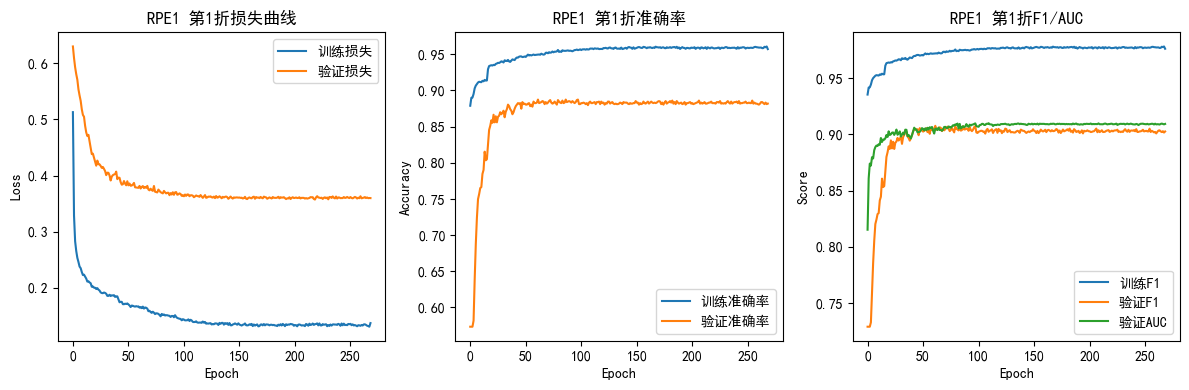

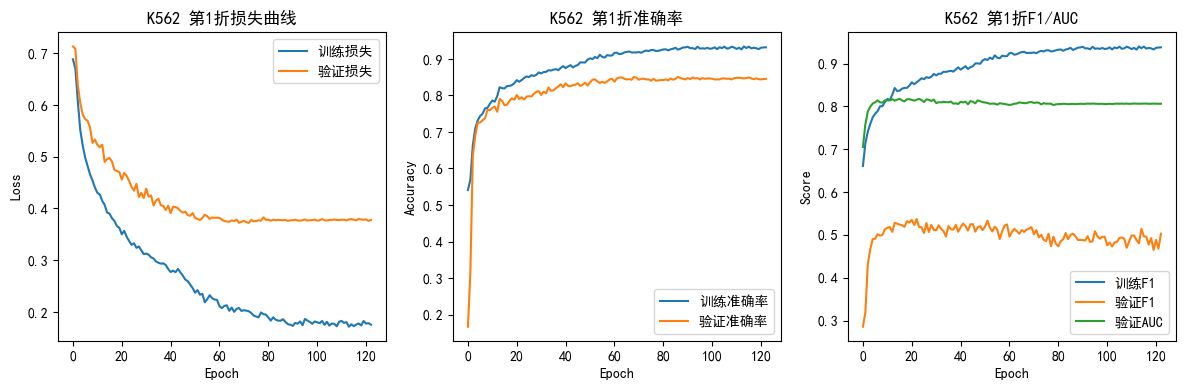

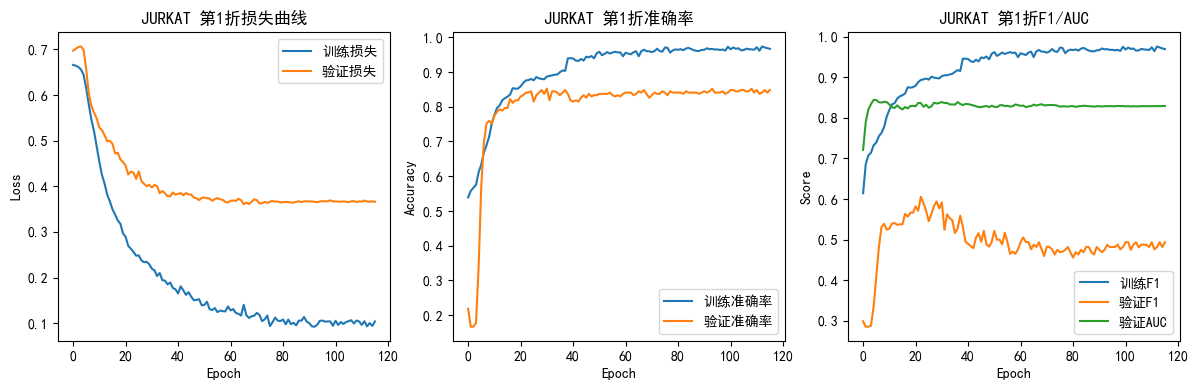

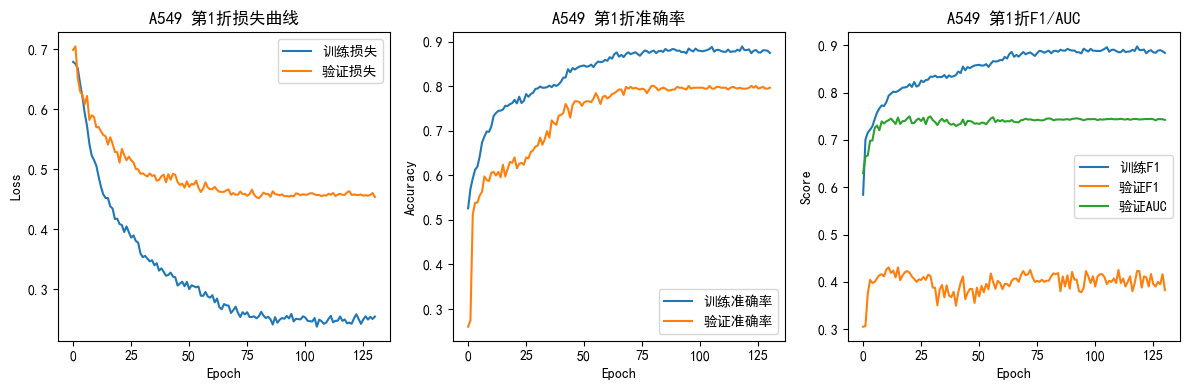

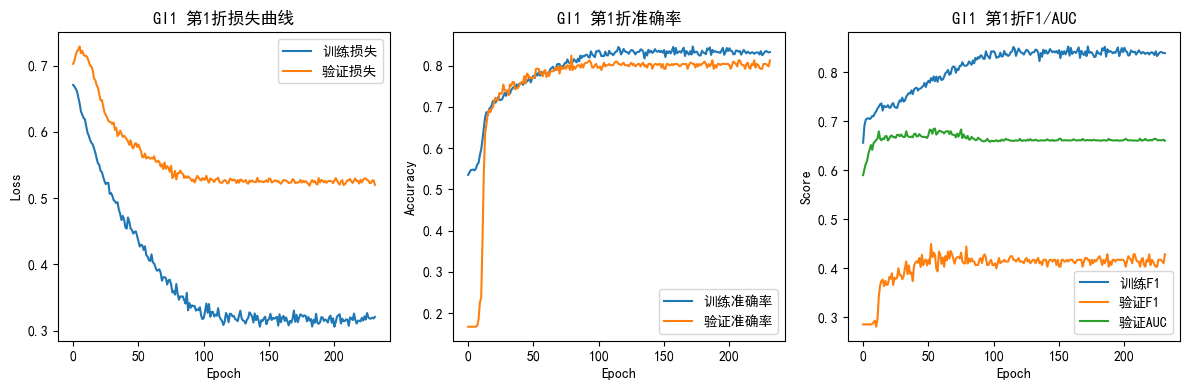

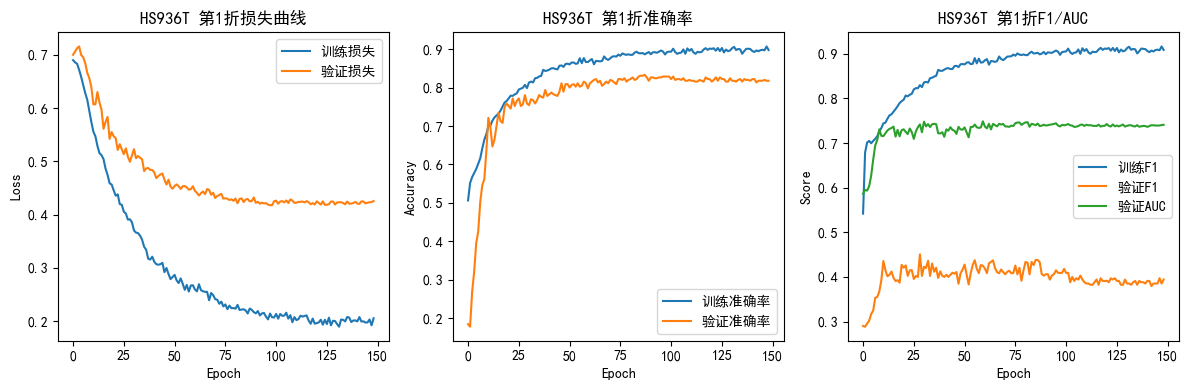

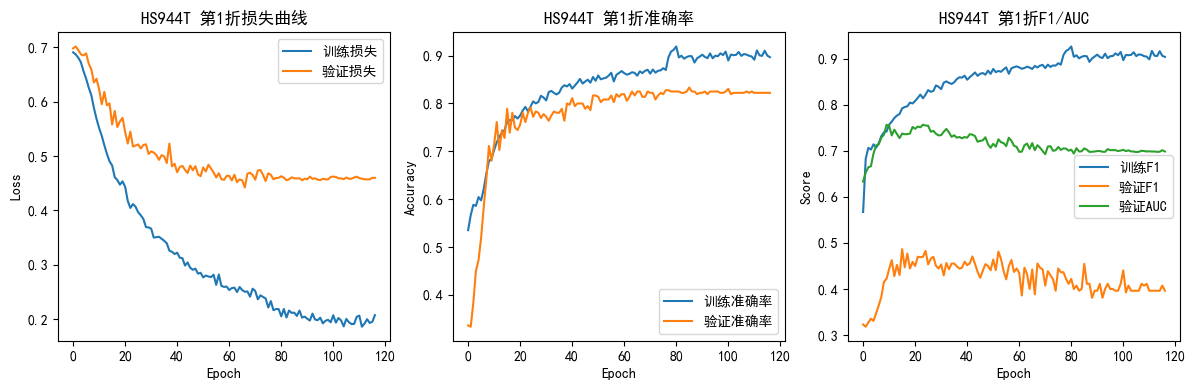

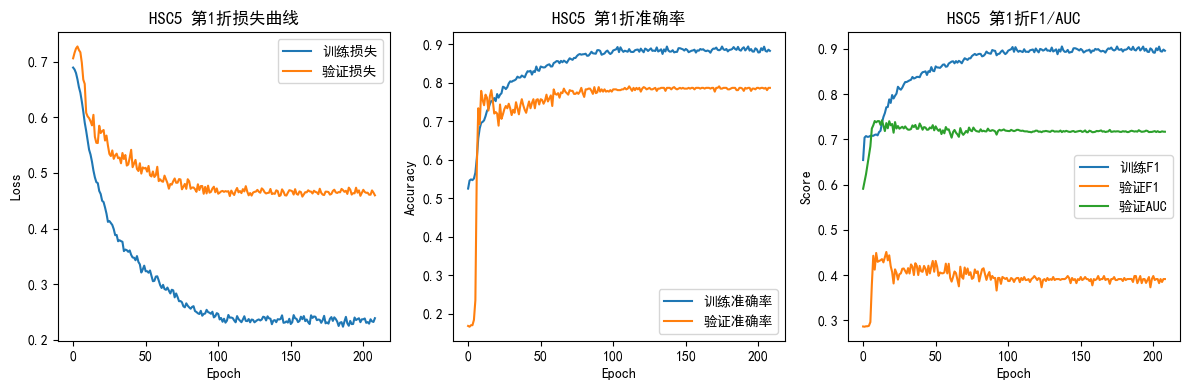

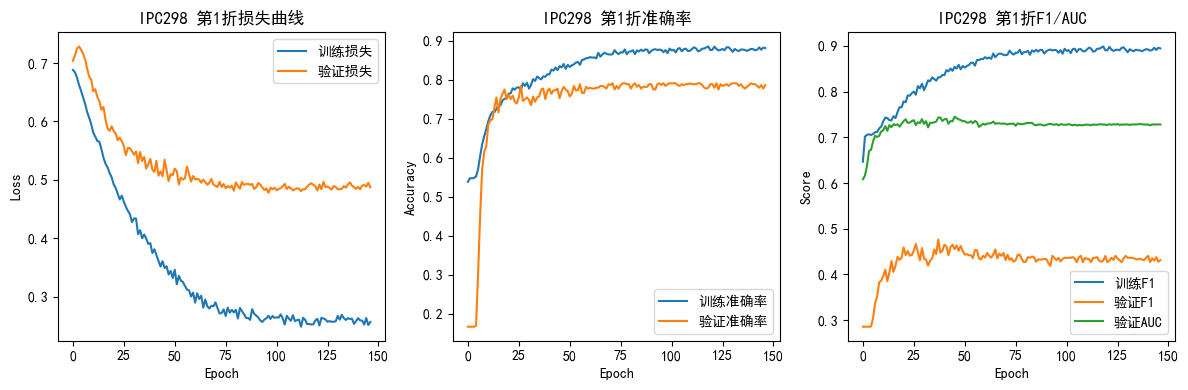

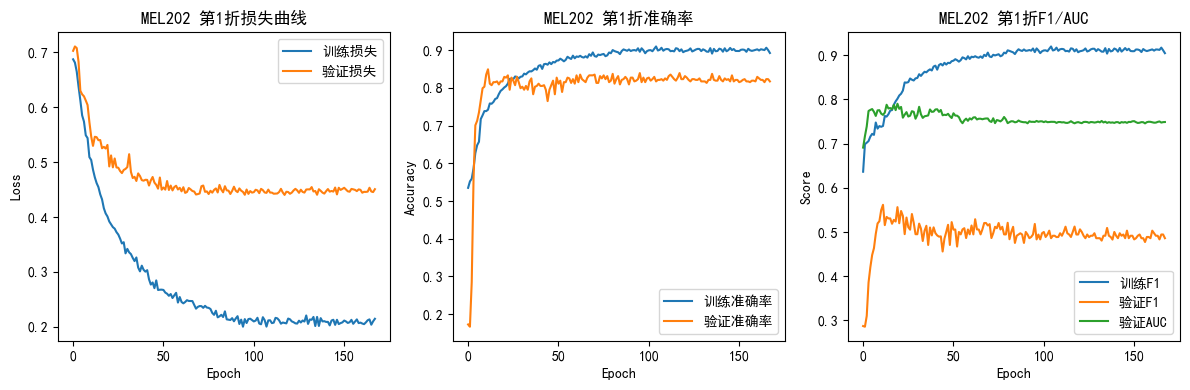

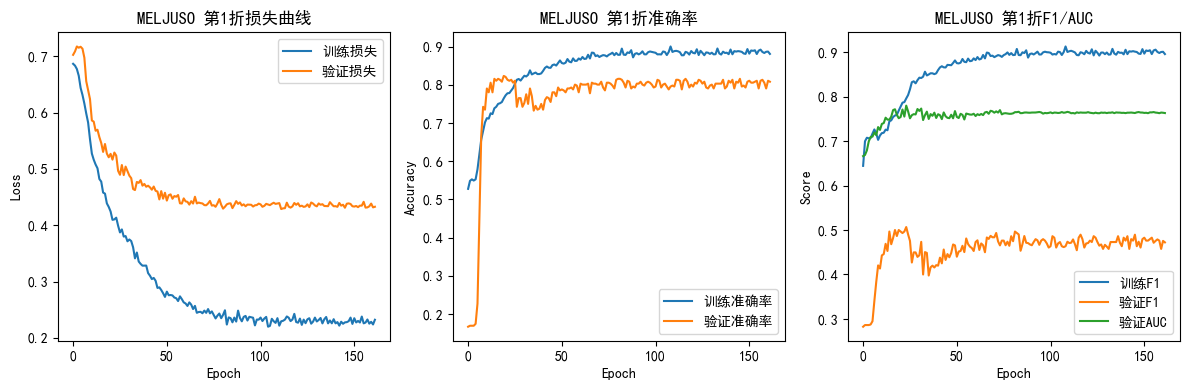

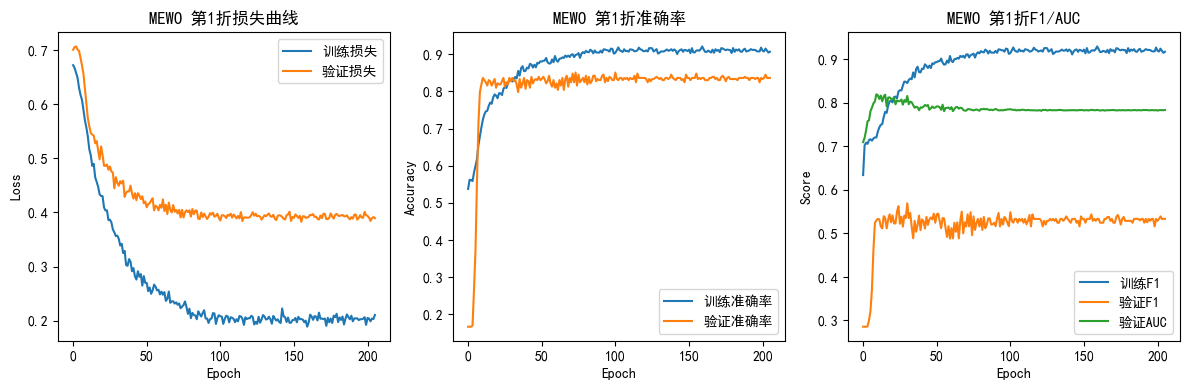

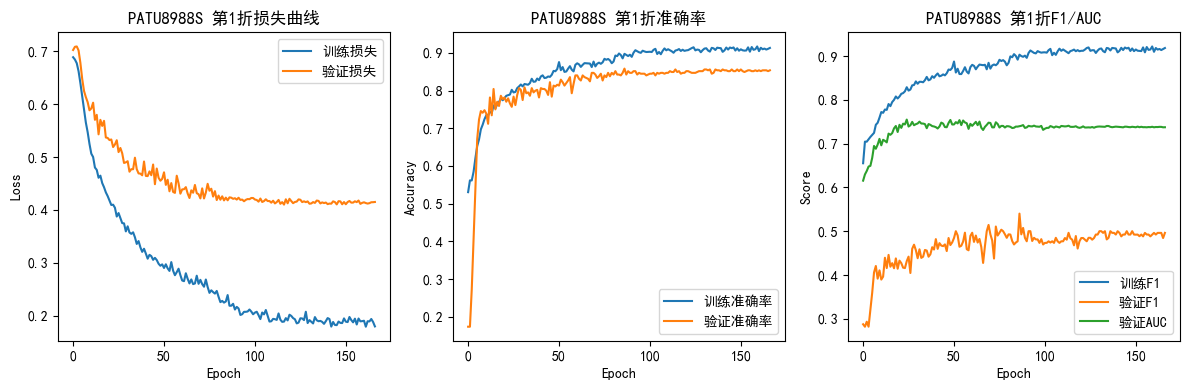

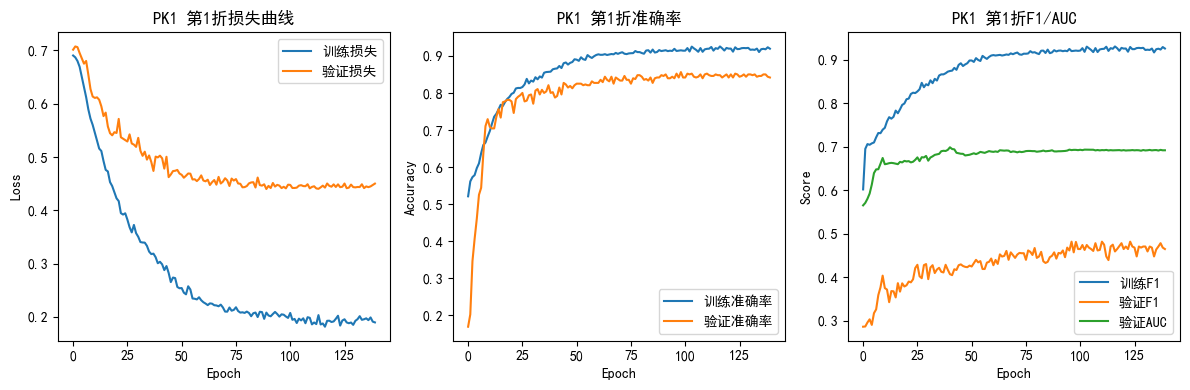

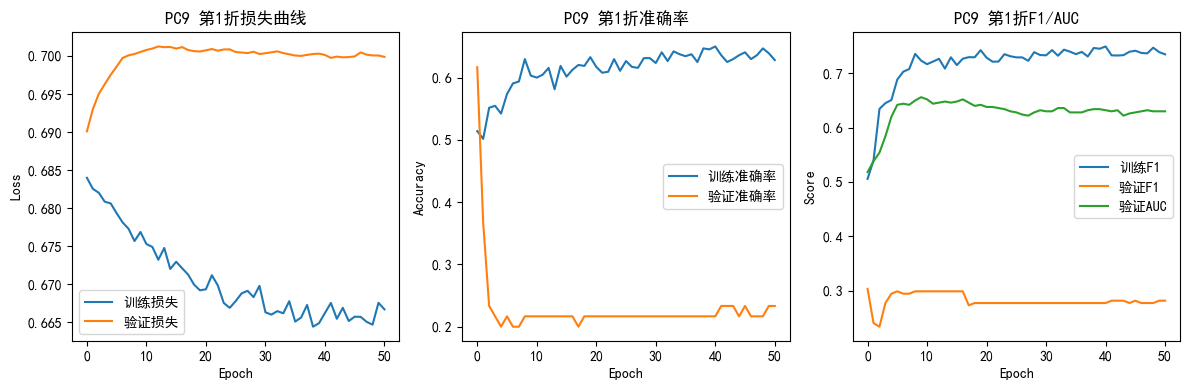

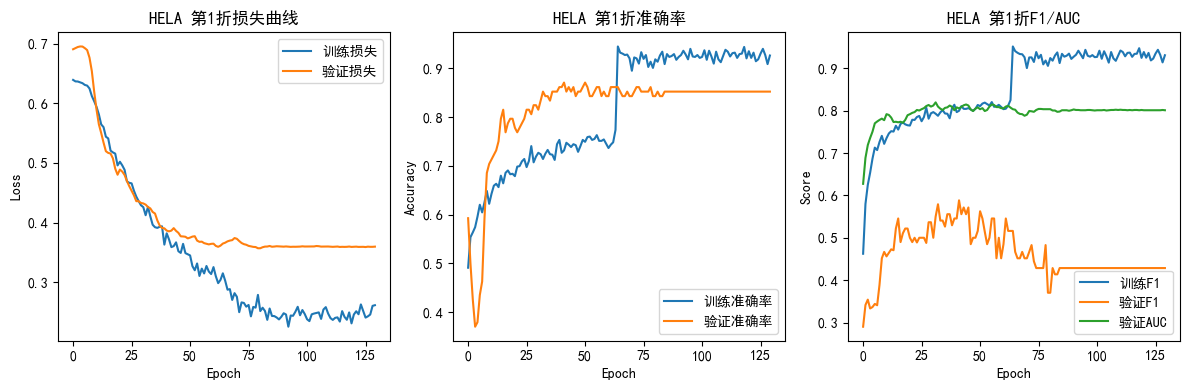

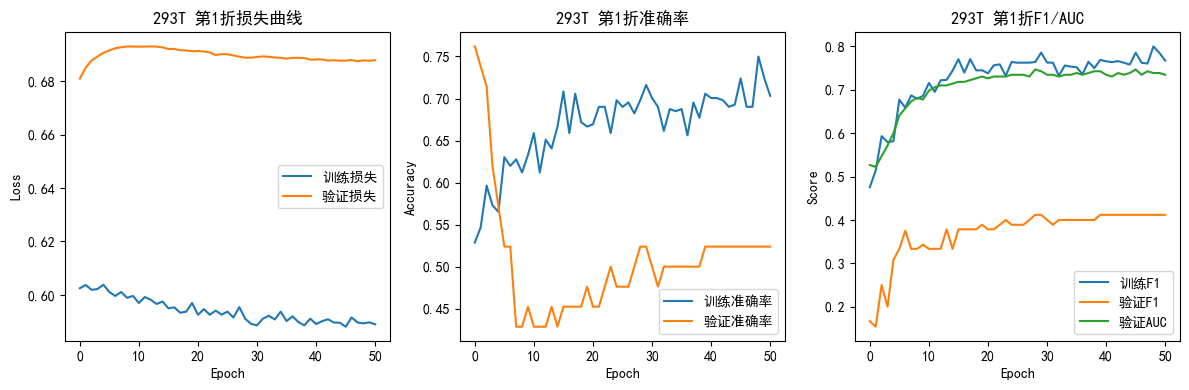

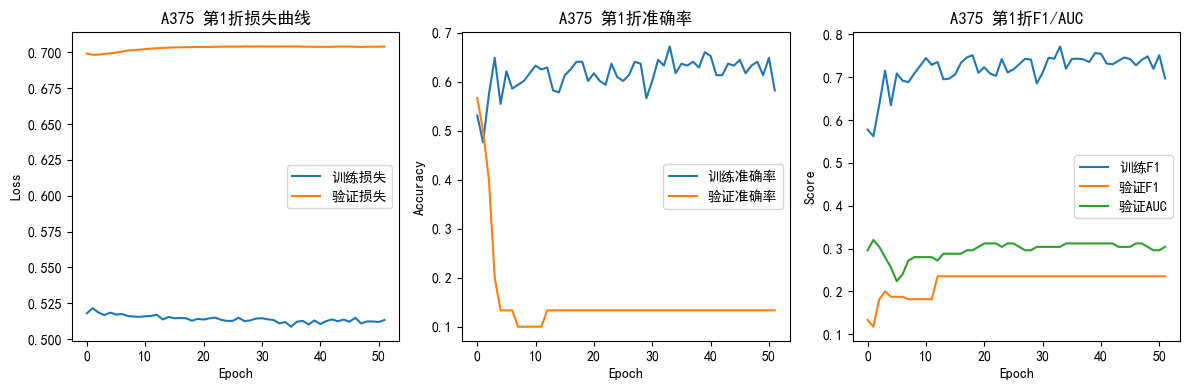

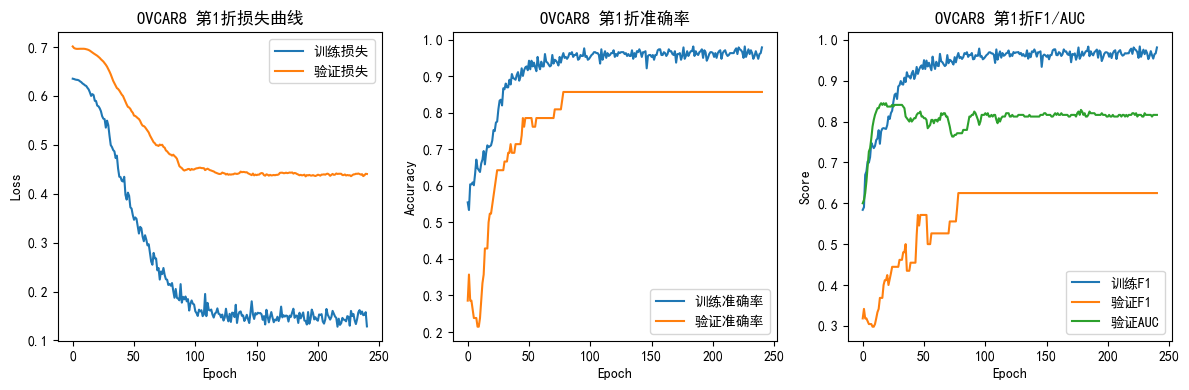

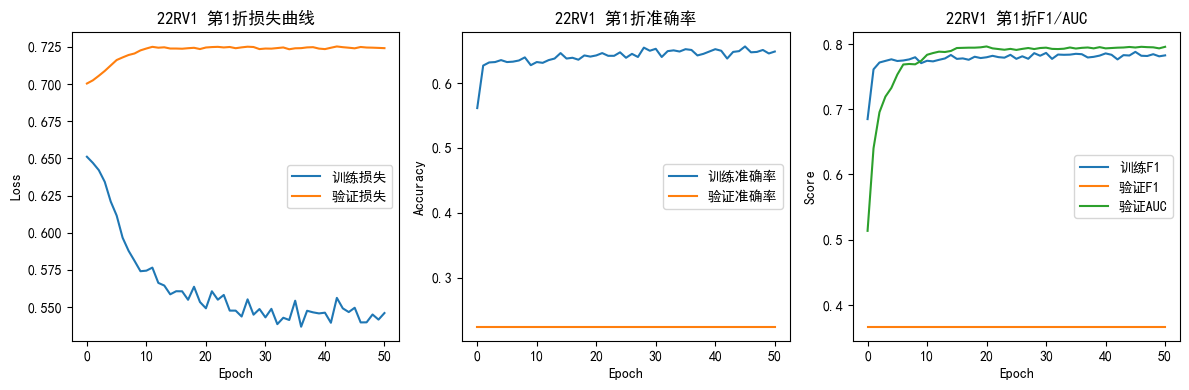

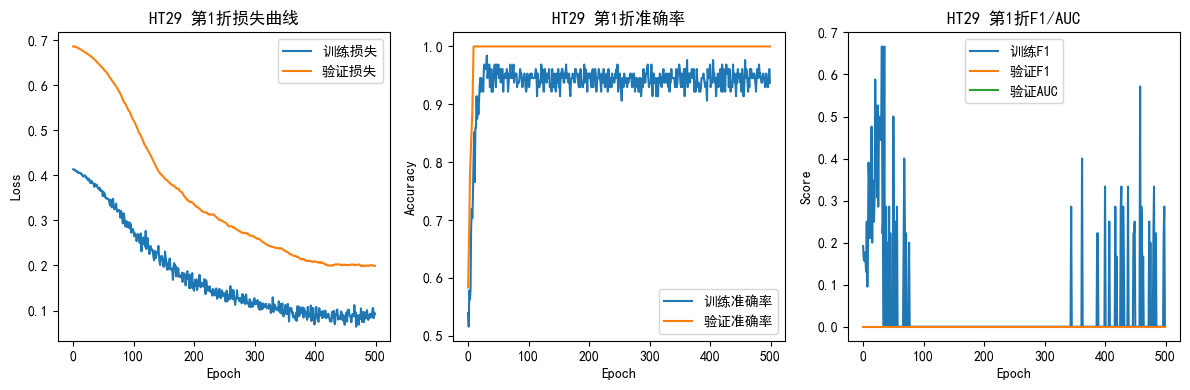

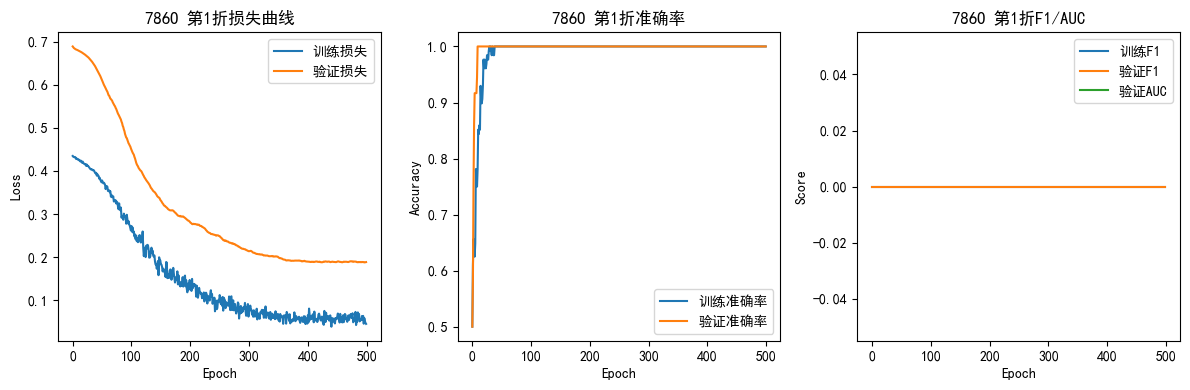

RPE1:
  Loss: 0.3713  Accuracy: 0.8734
  AUC: 0.9028  Precision: 0.8483  Recall: 0.9491
  F1: 0.8958  BACC: 0.8603
K562:
  Loss: 0.2201  Accuracy: 0.9078
  AUC: 0.8190  Precision: 0.0700  Recall: 0.4894
  F1: 0.1220  BACC: 0.7013
JURKAT:
  Loss: 0.2190  Accuracy: 0.9273
  AUC: 0.8142  Precision: 0.0329  Recall: 0.4758
  F1: 0.0615  BACC: 0.7027
A549:
  Loss: 0.3760  Accuracy: 0.8248
  AUC: 0.7543  Precision: 0.2122  Recall: 0.4547
  F1: 0.2841  BACC: 0.6548
GI1:
  Loss: 0.4638  Accuracy: 0.8389
  AUC: 0.6947  Precision: 0.2937  Recall: 0.3845
  F1: 0.3277  BACC: 0.6363
HS936T:
  Loss: 0.4612  Accuracy: 0.8113
  AUC: 0.6989  Precision: 0.3390  Recall: 0.4244
  F1: 0.3714  BACC: 0.6469
HS944T:
  Loss: 0.3722  Accuracy: 0.8782
  AUC: 0.7337  Precision: 0.4040  Recall: 0.3945
  F1: 0.3980  BACC: 0.6639
HSC5:
  Loss: 0.4359  Accuracy: 0.8298
  AUC: 0.7265  Precision: 0.4160  Recall: 0.4170
  F1: 0.4144  BACC: 0.6584
IPC298:
  Loss: 0.4280  Accuracy: 0.8242
  AUC: 0.7354  Precision: 0.3576  

In [21]:
# 训练历史
for cell_line in all_histories:
    if len(all_histories[cell_line]) > 0:
        first_fold_history = all_histories[cell_line][0]
        plot_training_curves(first_fold_history, cell_line, 1)
        
# 测试集结果
for cell_line, metrics in final_results.items():
    print(f"{cell_line}:")
    print(f"  Loss: {metrics['loss']:.4f}  Accuracy: {metrics['acc']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}  Precision: {metrics['precision']:.4f}  Recall: {metrics['recall']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}  BACC: {metrics['bacc']:.4f}")

细胞系与 F1 值对应表：
    Cell Line  F1 Score
0        RPE1    0.8958
1        K562    0.1220
2      JURKAT    0.0615
3        A549    0.2841
4         GI1    0.3277
5      HS936T    0.3714
6      HS944T    0.3980
7        HSC5    0.4144
8      IPC298    0.3970
9      MEL202    0.5158
10    MELJUSO    0.3852
11       MEWO    0.4224
12  PATU8988S    0.4458
13        PK1    0.3995
14        PC9    0.1579
15       HELA    0.1027
16       293T    0.0314
17       A375    0.0698
18     OVCAR8    0.1688
19      22RV1    0.4284
20       HT29    0.0000
21       786O    0.0000


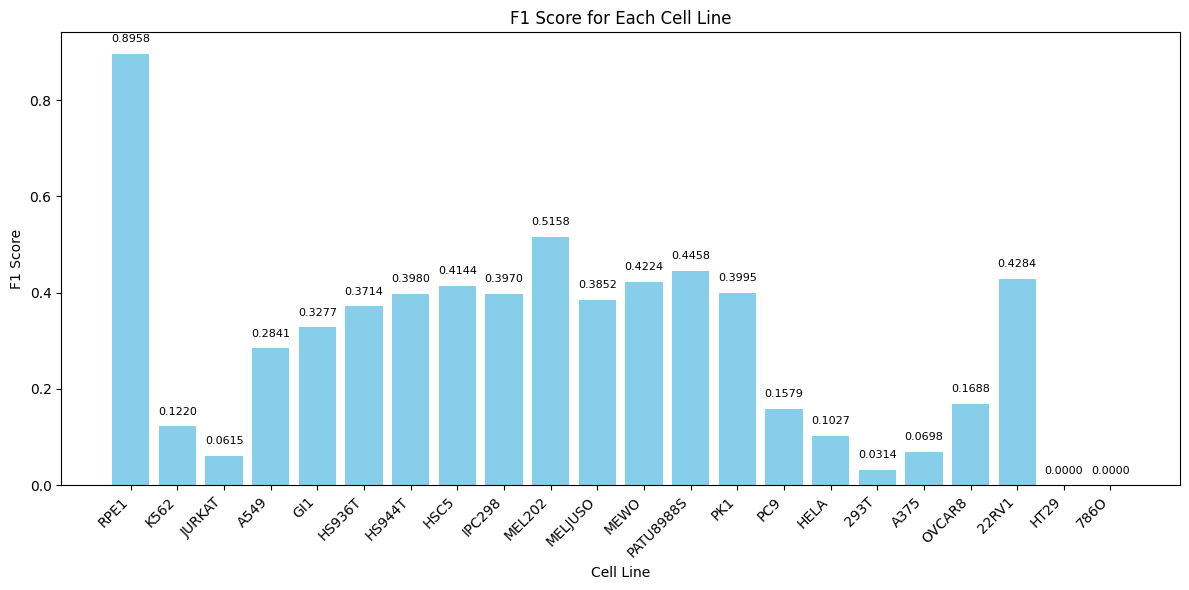

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 从打印结果手动提取的细胞系和 F1 值
data = {
    "Cell Line": [
        "RPE1", "K562", "JURKAT", "A549", "GI1", "HS936T", "HS944T", "HSC5", "IPC298", 
        "MEL202", "MELJUSO", "MEWO", "PATU8988S", "PK1", "PC9", "HELA", "293T", "A375", 
        "OVCAR8", "22RV1", "HT29", "786O"
    ],
    "F1 Score": [
        0.8958, 0.1220, 0.0615, 0.2841, 0.3277, 0.3714, 0.3980, 0.4144, 0.3970, 
        0.5158, 0.3852, 0.4224, 0.4458, 0.3995, 0.1579, 0.1027, 0.0314, 0.0698, 
        0.1688, 0.4284, 0.0000, 0.0000
    ]
}

# 创建 Pandas 数据框
df = pd.DataFrame(data)

# 打印表格
print("细胞系与 F1 值对应表：")
print(df)

# 可视化 F1 值
plt.figure(figsize=(12, 6))
bars = plt.bar(df["Cell Line"], df["F1 Score"], color="skyblue")

# 在每个柱子上方显示对应的 F1 值
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X 坐标
        height + 0.02,                     # Y 坐标（略高于柱子）
        f"{height:.4f}",                   # 显示的文本
        ha="center", va="bottom", fontsize=8
    )

plt.xlabel("Cell Line")
plt.ylabel("F1 Score")
plt.title("F1 Score for Each Cell Line")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# 显示图表
plt.show()